In [26]:
import copy

import sklearn.metrics
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
from os.path import join as oj
from tqdm import tqdm
import pickle

from imodels.importance import R2FExp, GeneralizedMDI, GeneralizedMDIJoint
from imodels.importance import LassoScorer, RidgeScorer, ElasticNetScorer, RobustScorer, LogisticScorer, JointRidgeScorer, JointLogisticScorer, JointRobustScorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import shap
import sys
sys.path.append("../../..")
from feature_importance.scripts.mda import MDA
import sklearn.metrics as metrics

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar, theme, element_text

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
DATA_DIR = "../../data"
RESULTS_DIR = "../../results/tcga_brca"
# RESULTS_DIR = "../../results/tcga_brca_normalized"
N_REPS = 10
# FI_MODELS = ["gjmdi_ridge_loocv", "gjmdi_logistic_loocv", "mdi", "perm", "mda"]#, "shap"]
SUBTYPES = ["Basal", "Her2", "LumA", "LumB"]
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR, exist_ok=True)

## Helper Functions

In [28]:
# f1 score for multi-class classification
def multiclass_f1_score(y_onehot, ypreds, sample_weight=None):
    ypreds_label = ypreds.argmax(axis=1)
    y_label = y_onehot.argmax(axis=1)
    results = np.zeros(ypreds.shape[1])
    for k in range(ypreds.shape[1]):
        ypreds_k = (ypreds_label == k).astype(int)
        y_k = (y_label == k).astype(int)
        results[k] = metrics.f1_score(y_k, ypreds_k)
    return results

In [29]:
# helper functions to reformat results
def importance_dict_to_df(d, X_df):
    df = pd.DataFrame(d)
    df["feature"] = X_df.columns
    return df


def class_scores_dict_to_df(d, X_df):
    df_ls = []
    for i, df in enumerate(d.values()):
        df["rep"] = i
        df["feature"] = X_df.columns
        df_ls.append(df)
    df = pd.concat(df_ls).reset_index(drop=True)
    return df


def dict_to_df(d, col_id):
    df_ls = []
    for key, df in d.items():
        df[col_id] = key
        df_ls.append(df)
    df = pd.concat(df_ls).reset_index(drop=True)
    return df

In [31]:
# check if in top r
def isin_top_r(x, r=10, ascending=False):
    if ascending:
        x[x == -np.inf] = np.NaN
        return x <= x.sort_values(ascending=ascending).values[r-1]
    else:
        return x >= x.sort_values(ascending=ascending).values[r-1]


# count frequency in top r
def top_r_stability(df, r=10, ascending=False):
    drop_features = [col_name for col_name in ["feature", "method"] if col_name in df.columns]
    top_r_df = pd.DataFrame({
        "feature": df["feature"],
        "top_r_stability": df.drop(drop_features, axis=1).
            apply(isin_top_r, axis=0, r=r, ascending=ascending).mean(axis=1)
    })
    return top_r_df.sort_values("top_r_stability", ascending=False)

## Load in stability analysis results

In [32]:
X_df = pd.read_csv(oj(DATA_DIR, "X_tcga_var_filtered_log_transformed.csv"))

In [33]:
results_dict = {}
for subtype in SUBTYPES:
    results_dict[subtype] = {}
    for rep in range(N_REPS):
        results_fname = oj(RESULTS_DIR, subtype, "rep{}".format(rep), "imp_values_dict.pickle")
        if os.path.exists(results_fname):
            results_rep = pickle.load(open(results_fname, "rb"))
            for method_name, df in results_rep.items():
                if method_name in results_dict[subtype].keys():
                    results_dict[subtype][method_name][rep] = df
                else:
                    results_dict[subtype][method_name] = {rep: df}
    results_dict[subtype] = {method_name: importance_dict_to_df(results, X_df)\
                             for method_name, results in results_dict[subtype].items()}

In [34]:
results_dict["Basal"].keys()

dict_keys(['gjmdi_ridge_loocv', 'gjmdi_elastic_loocv_logloss', 'gjmdi_elastic_loocv_auprc', 'gjmdi_elastic_loocv_auroc', 'gjmdi_logistic_loocv_logloss', 'gjmdi_logistic_loocv_auprc', 'gjmdi_logistic_loocv_auroc', 'mdi', 'shap', 'permutation', 'mda'])

In [35]:
results_dict["Basal"]["gjmdi_ridge_loocv"].head()

0             1             2             3             4  \
0  9.103829e-17  1.054712e-16  9.325873e-17  1.010303e-16  9.436896e-17   
1  6.664260e-03  1.138272e-02  2.511763e-03  7.341179e-03  3.319730e-03   
2  9.103829e-17  1.054712e-16  9.325873e-17  1.010303e-16  9.436896e-17   
3  9.103829e-17  1.054712e-16  9.325873e-17  1.010303e-16  9.436896e-17   
4  9.103829e-17  2.077540e-04  9.325873e-17  1.010303e-16  9.436896e-17   

              5             6             7             8             9  \
0  8.881784e-17  1.076916e-16  1.054712e-16  8.104628e-17 -8.629895e-05   
1  1.263859e-02  9.399495e-04  6.173816e-04  6.575149e-03  2.193228e-03   
2  8.881784e-17 -8.033742e-05  1.054712e-16 -3.113096e-05  1.154632e-16   
3 -5.243447e-06  1.076916e-16  1.054712e-16  8.104628e-17  1.154632e-16   
4  8.881784e-17  1.076916e-16  1.054712e-16  8.104628e-17  4.653352e-04   

        feature  
0           A2M  
1          NAT1  
2  RP11.986E7.7  
3          AAMP  
4          AARS

In [36]:
results_dict["Basal"]["gjmdi_logistic_loocv_logloss"].head()

0         1         2         3         4         5         6  \
0      -inf      -inf      -inf      -inf      -inf      -inf      -inf   
1  0.604196  0.548124  0.709311  0.473334  0.654239  0.594191  0.587707   
2      -inf      -inf      -inf      -inf      -inf      -inf  0.840154   
3      -inf      -inf      -inf      -inf      -inf  0.822028      -inf   
4      -inf  0.842162      -inf      -inf      -inf      -inf      -inf   

          7         8         9       feature  
0      -inf      -inf  0.853131           A2M  
1  0.717864  0.647278  0.664364          NAT1  
2      -inf  0.762175      -inf  RP11.986E7.7  
3      -inf      -inf      -inf          AAMP  
4      -inf      -inf  0.797609          AARS

In [37]:
results_dict["Basal"]["gjmdi_logistic_loocv_auroc"].head()

0         1         2         3         4         5         6  \
0      -inf      -inf      -inf      -inf      -inf      -inf      -inf   
1  0.635122  0.929499  0.641834  0.942185  0.633185  0.733717  0.945524   
2      -inf      -inf      -inf      -inf      -inf      -inf  0.100111   
3      -inf      -inf      -inf      -inf      -inf  0.001253      -inf   
4      -inf  0.021997      -inf      -inf      -inf      -inf      -inf   

          7         8         9       feature  
0      -inf      -inf  0.246400           A2M  
1  0.593656  0.695294  0.866370          NAT1  
2      -inf  0.002018      -inf  RP11.986E7.7  
3      -inf      -inf      -inf          AAMP  
4      -inf      -inf  0.025433          AARS

In [44]:
results_dict["Basal"]["gjmdi_elastic_loocv_logloss"].head()

0         1         2         3         4         5         6  \
0      -inf      -inf      -inf      -inf      -inf      -inf      -inf   
1  3.568569  5.144062  6.291819  4.521753  5.775673  5.549546  6.291879   
2      -inf      -inf      -inf      -inf      -inf      -inf      -inf   
3      -inf      -inf      -inf      -inf      -inf      -inf      -inf   
4      -inf  6.291819      -inf      -inf      -inf      -inf      -inf   

          7         8         9       feature  
0      -inf      -inf  6.293676           A2M  
1  6.291819  6.280082  6.291819          NAT1  
2      -inf      -inf      -inf  RP11.986E7.7  
3      -inf      -inf      -inf          AAMP  
4      -inf      -inf      -inf          AARS

## Visualize stability results

Check stability in top 10

In [38]:
DESCENDING_METHODS = [method for method in results_dict["Basal"] if "logloss" in method]
DESCENDING_METHODS

['gjmdi_elastic_loocv_logloss', 'gjmdi_logistic_loocv_logloss']

In [39]:
stability_dict = {
    subtype: {
        method_name: top_r_stability(df, r=10, ascending=method_name in DESCENDING_METHODS) for method_name, df in results_dict[subtype].items()
    } for subtype in results_dict.keys()
}

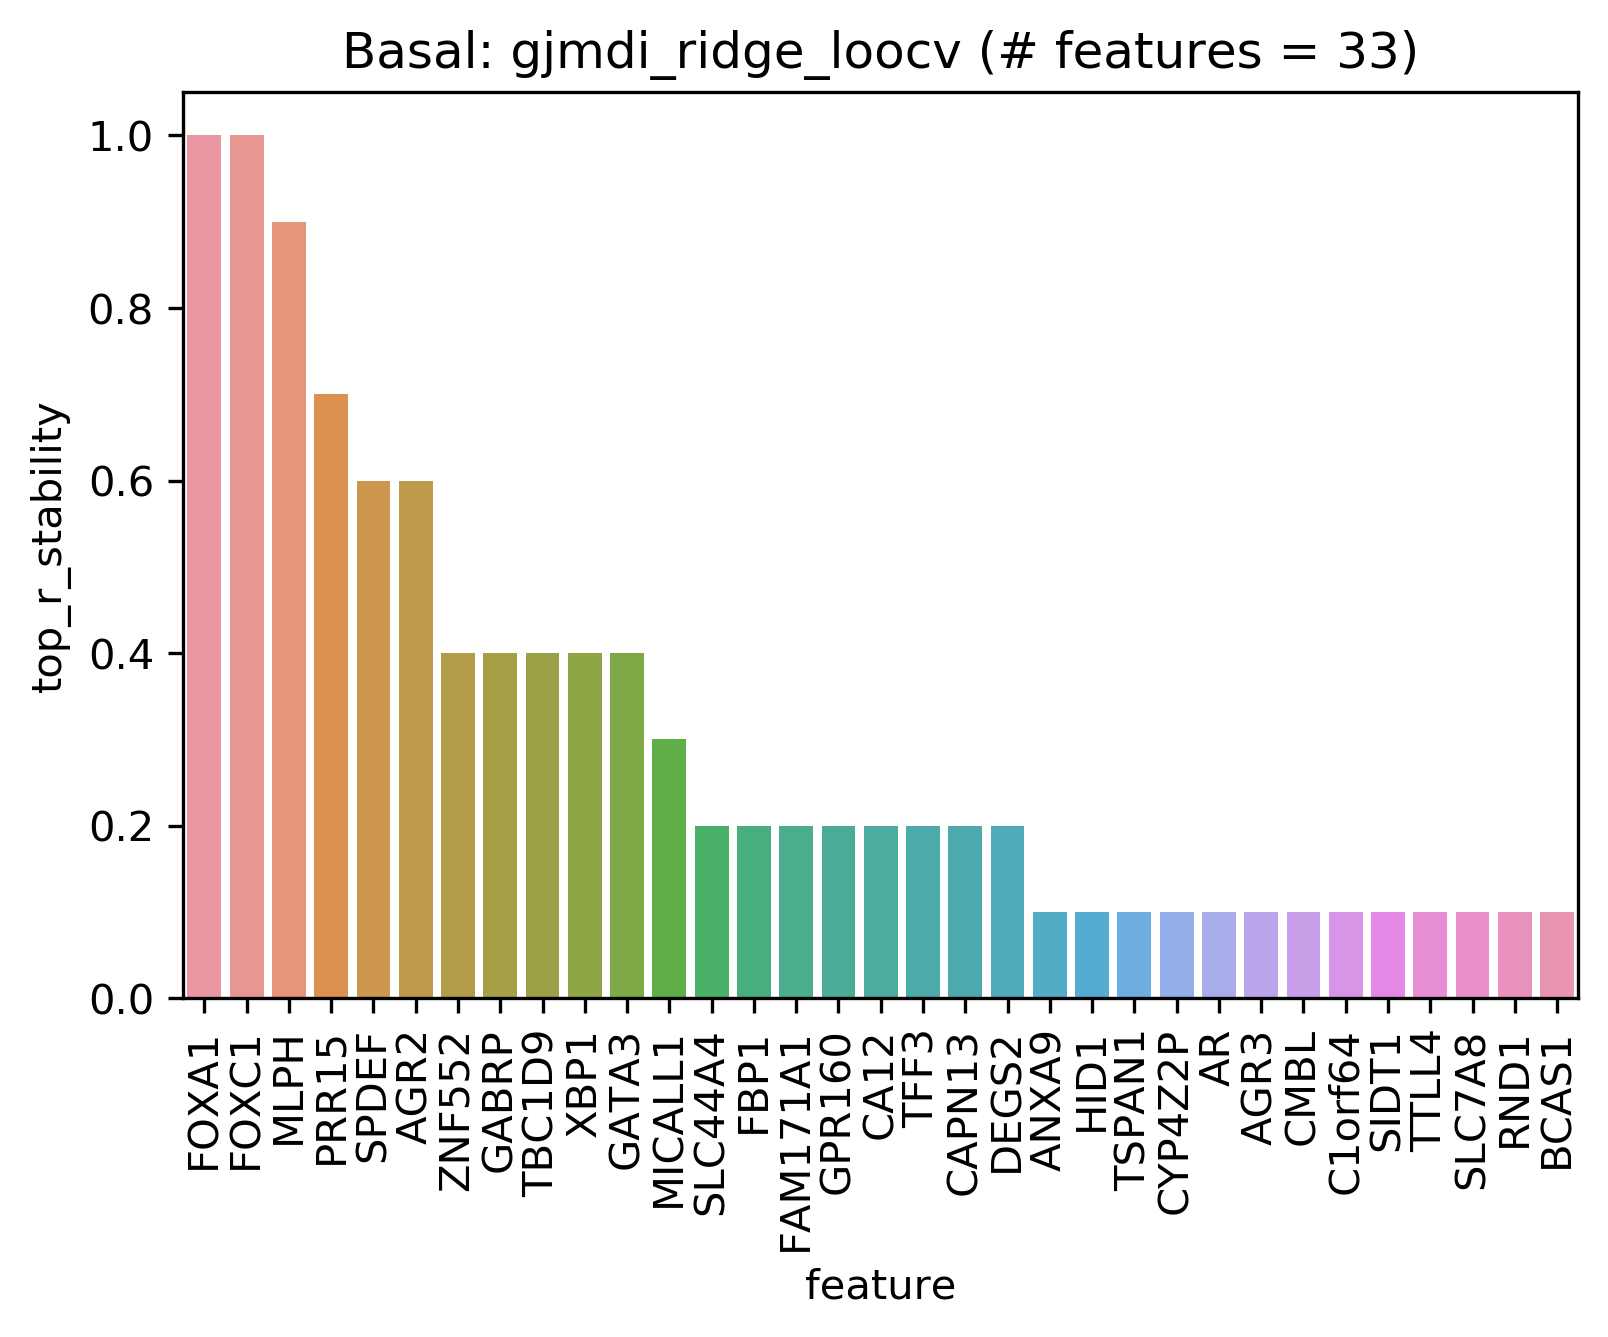

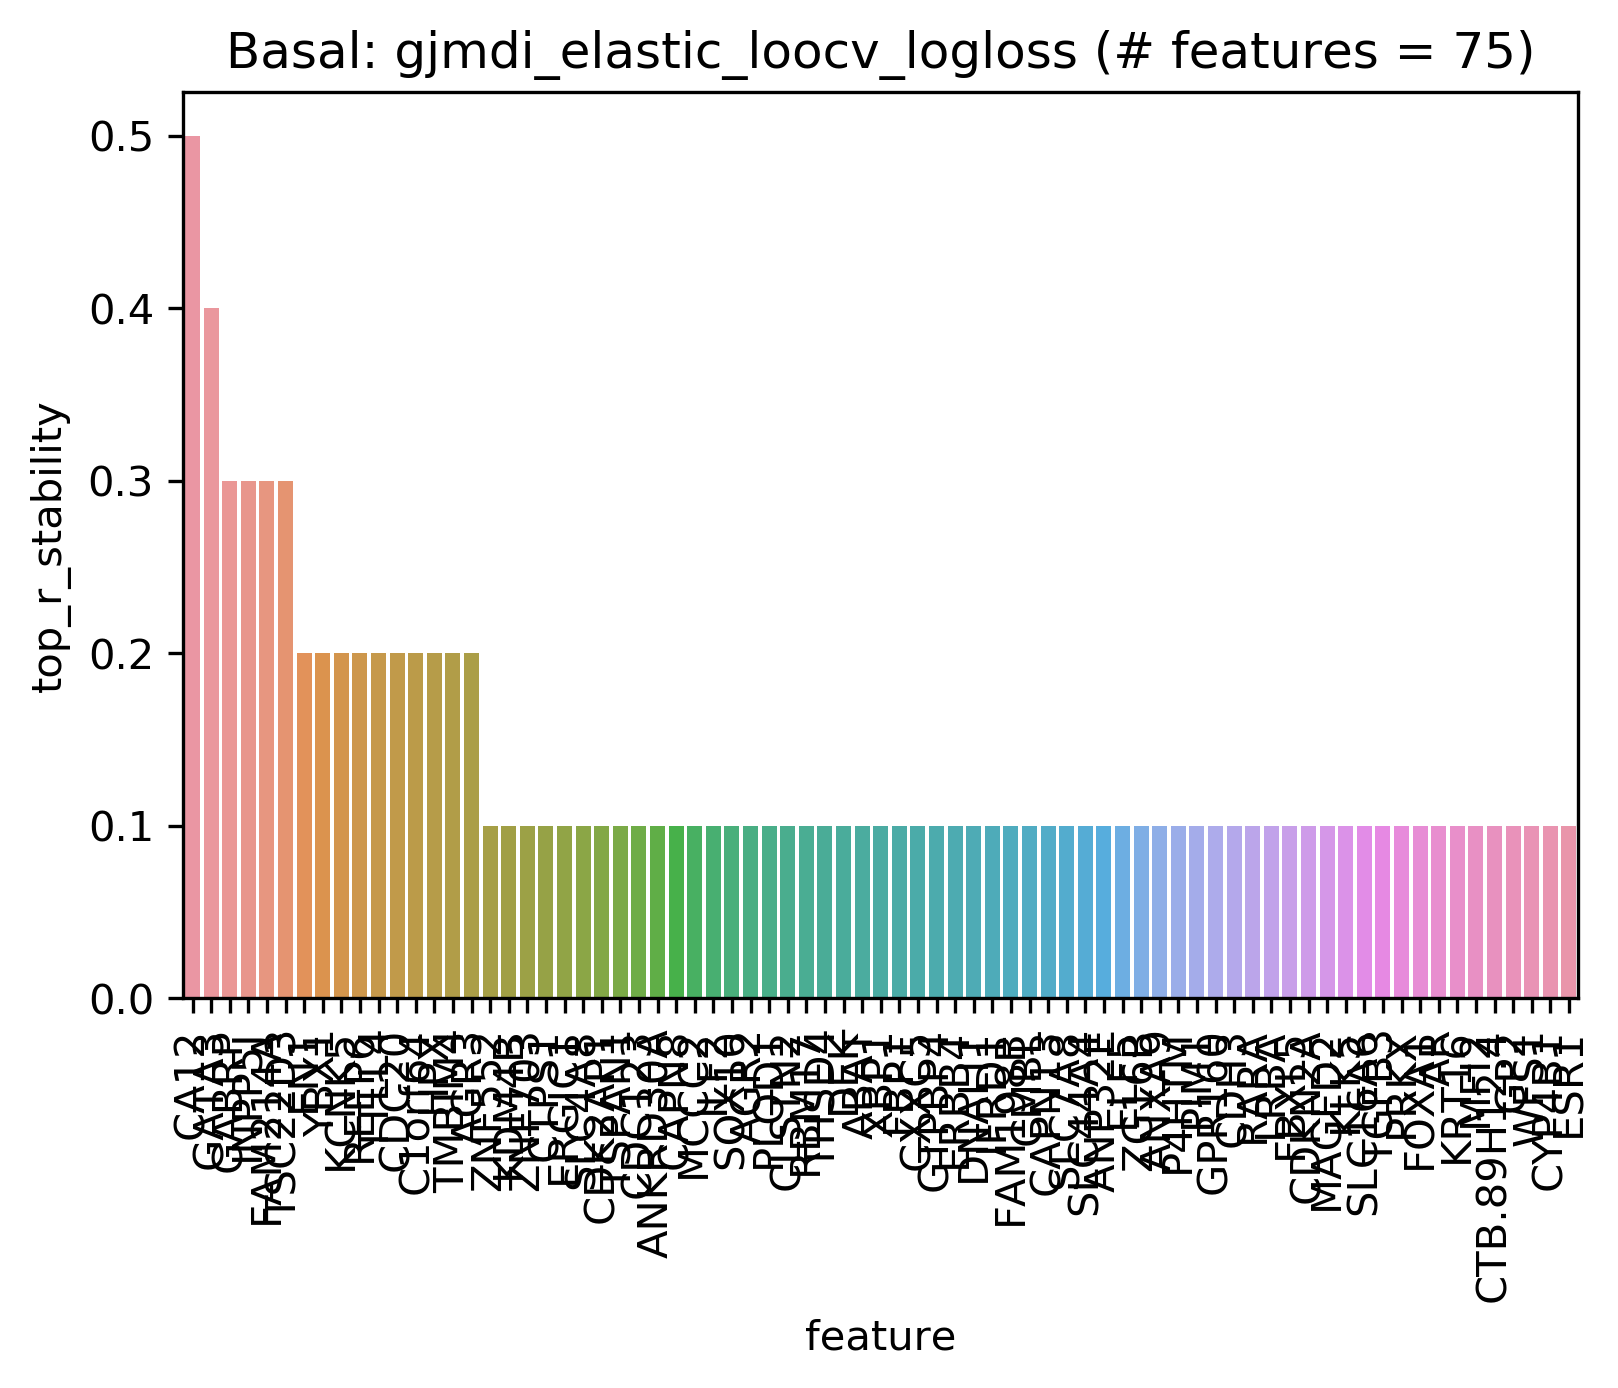

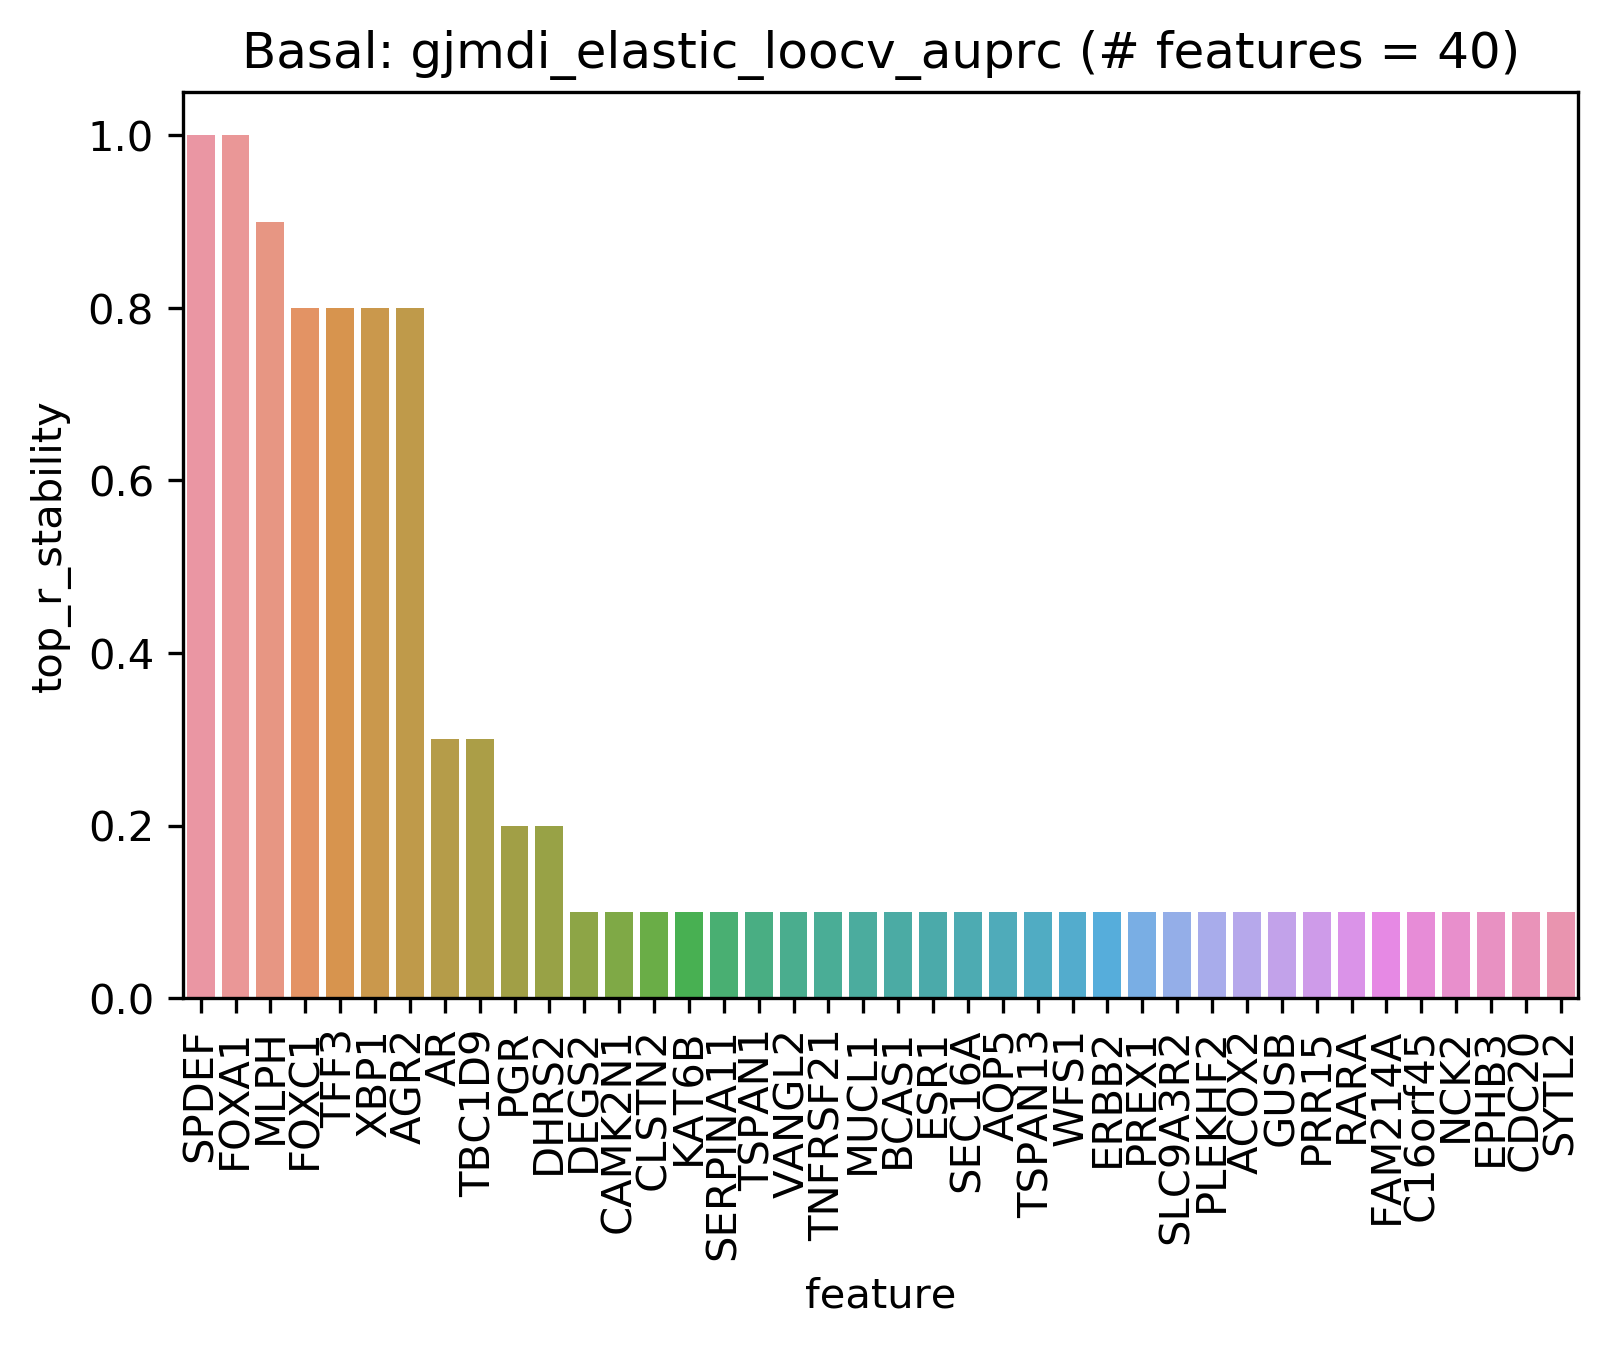

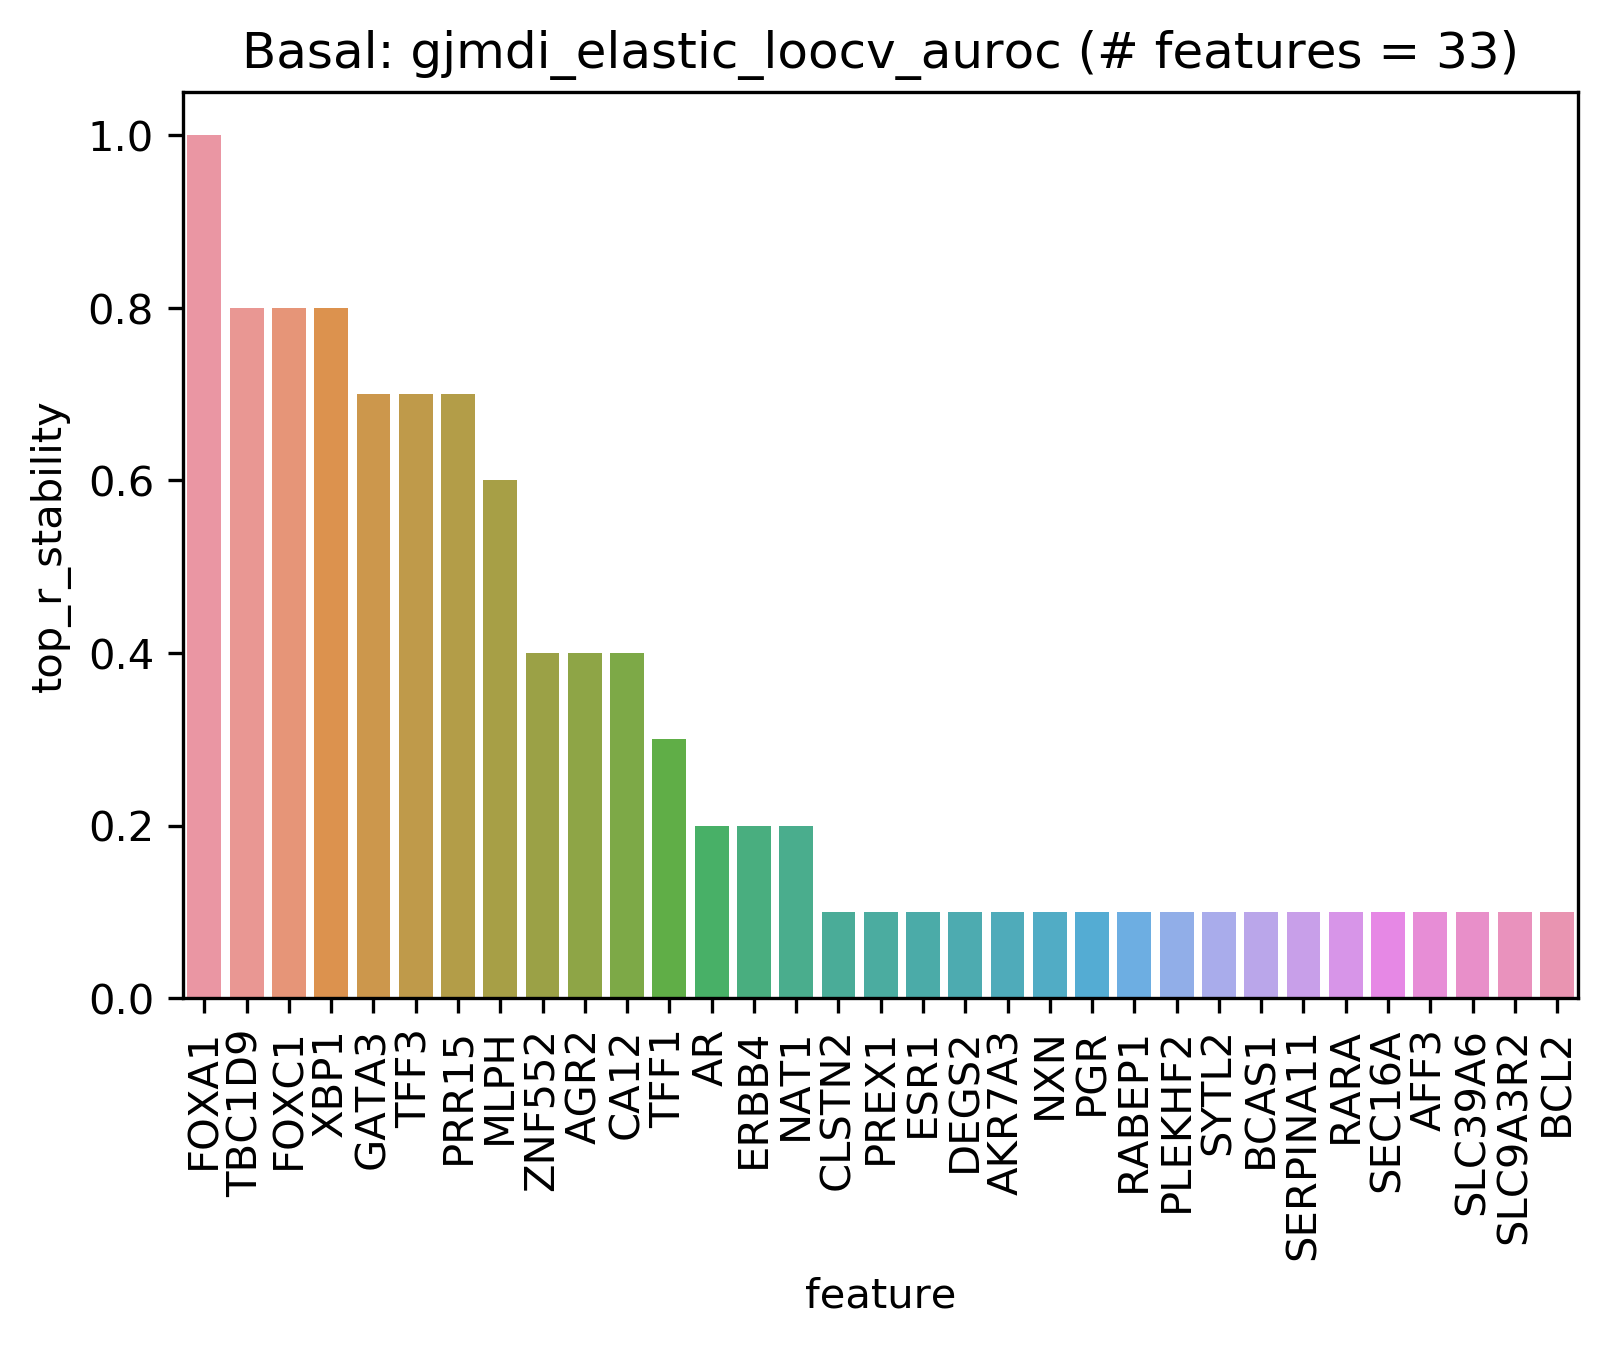

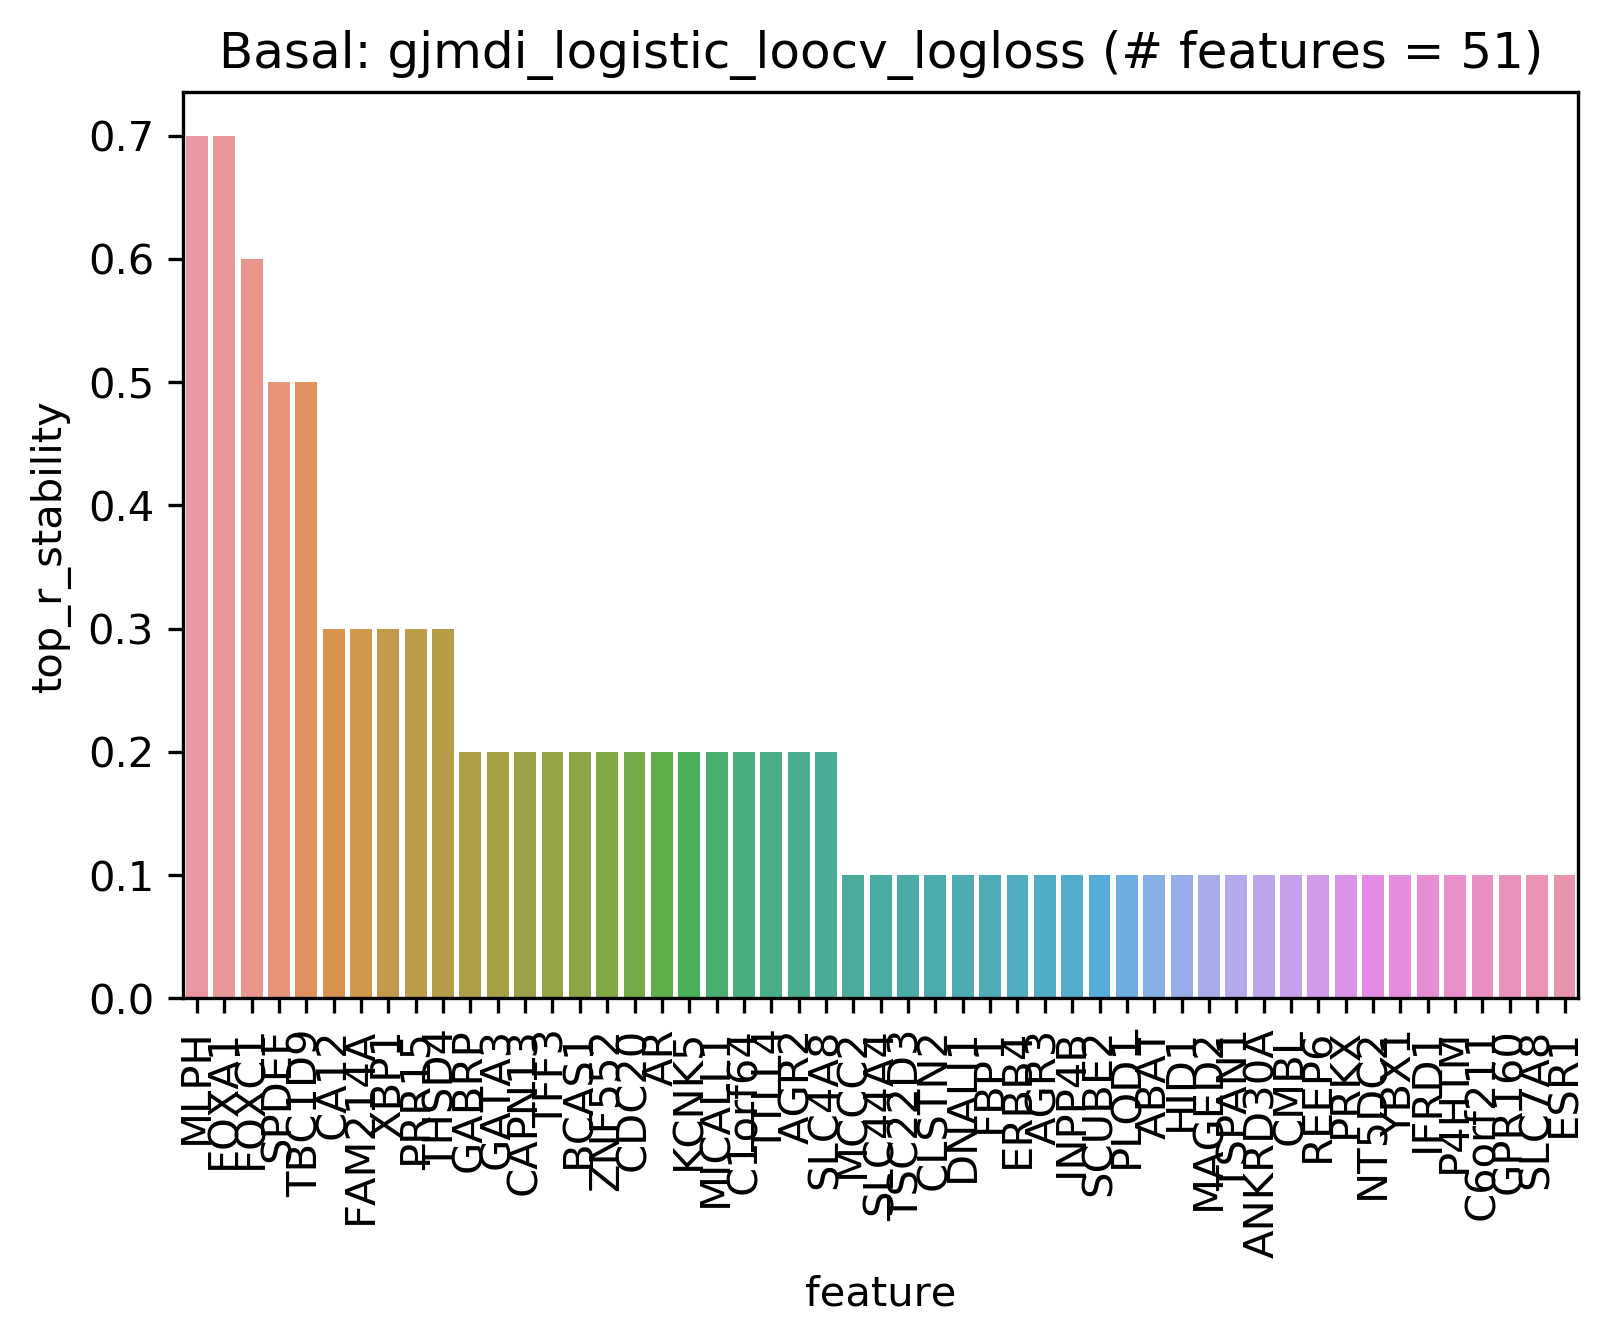

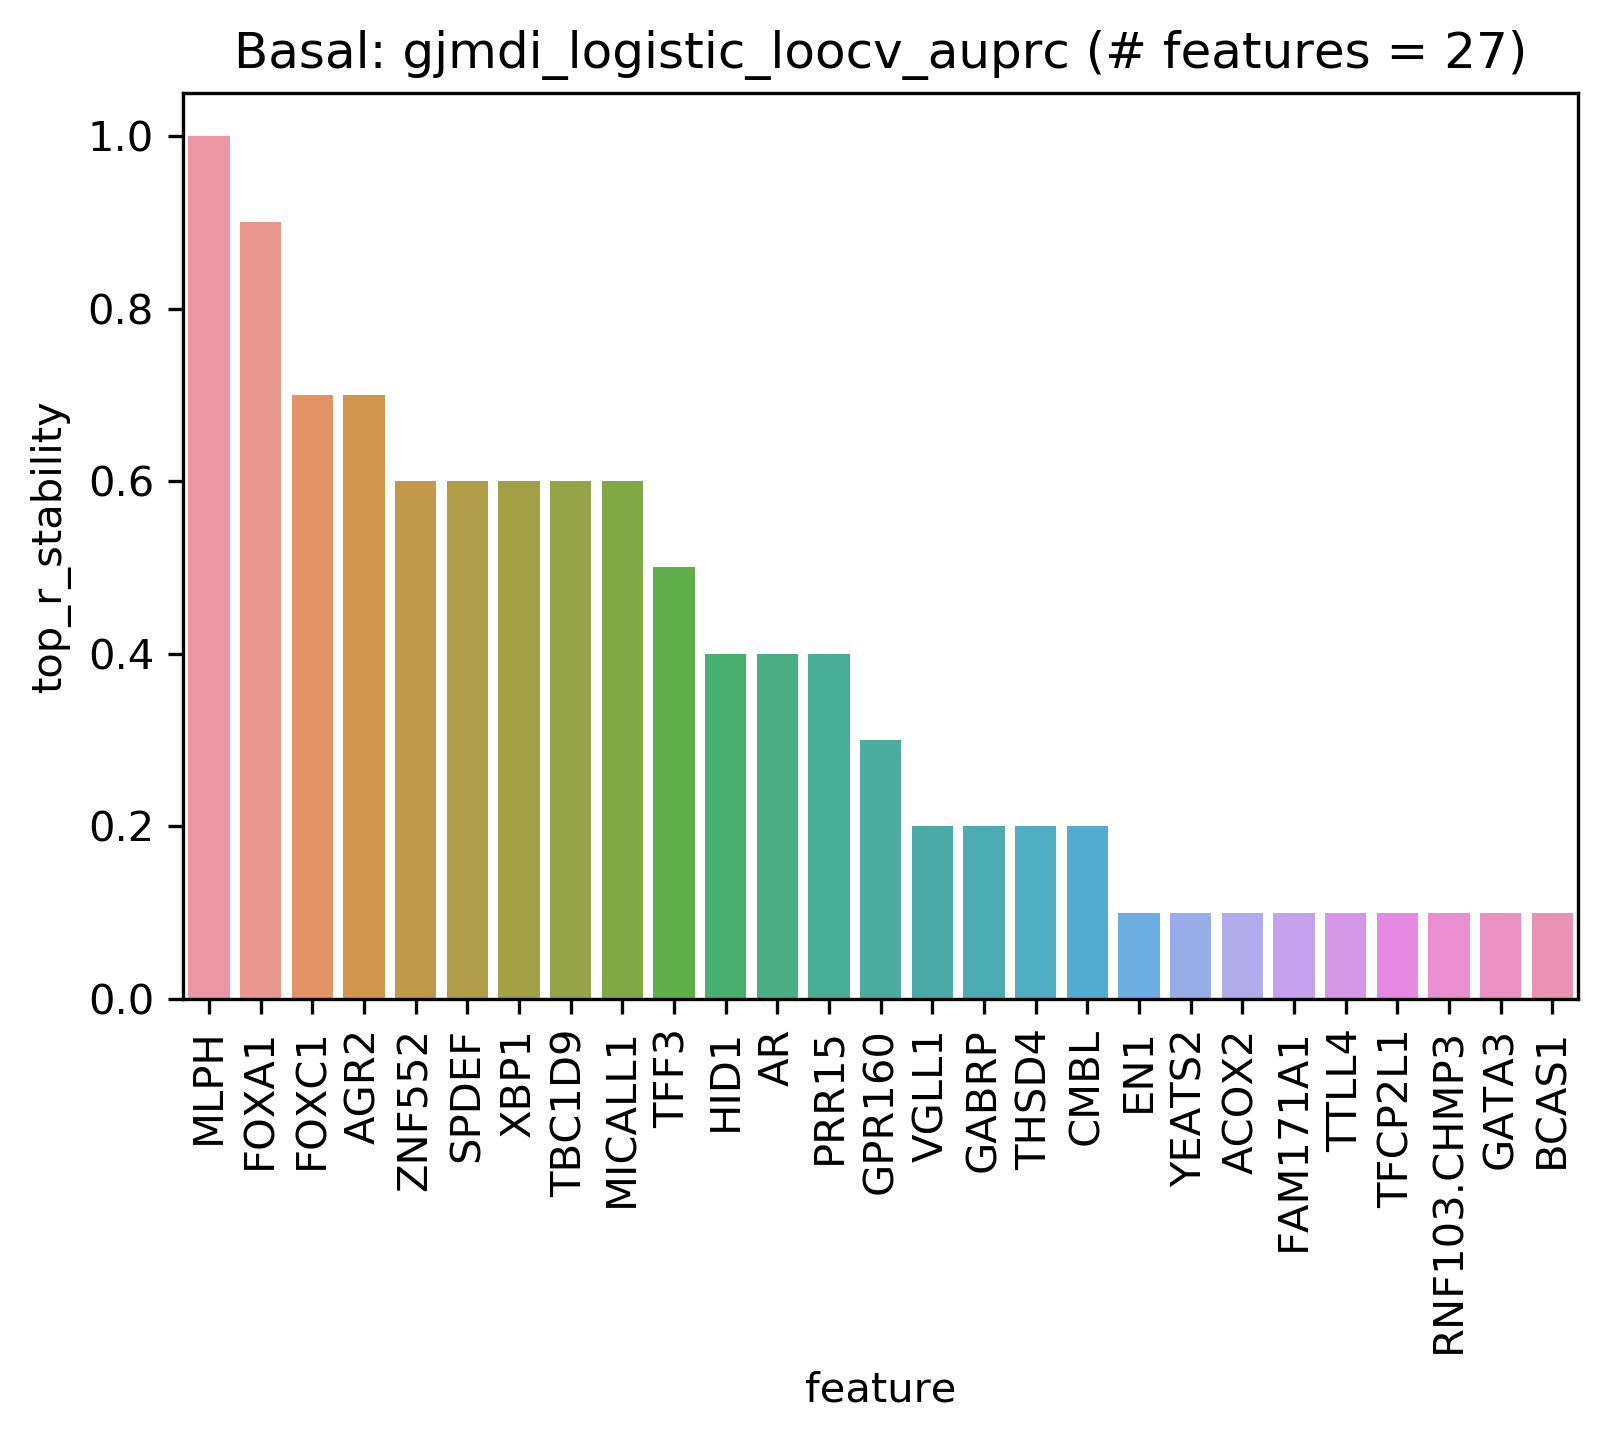

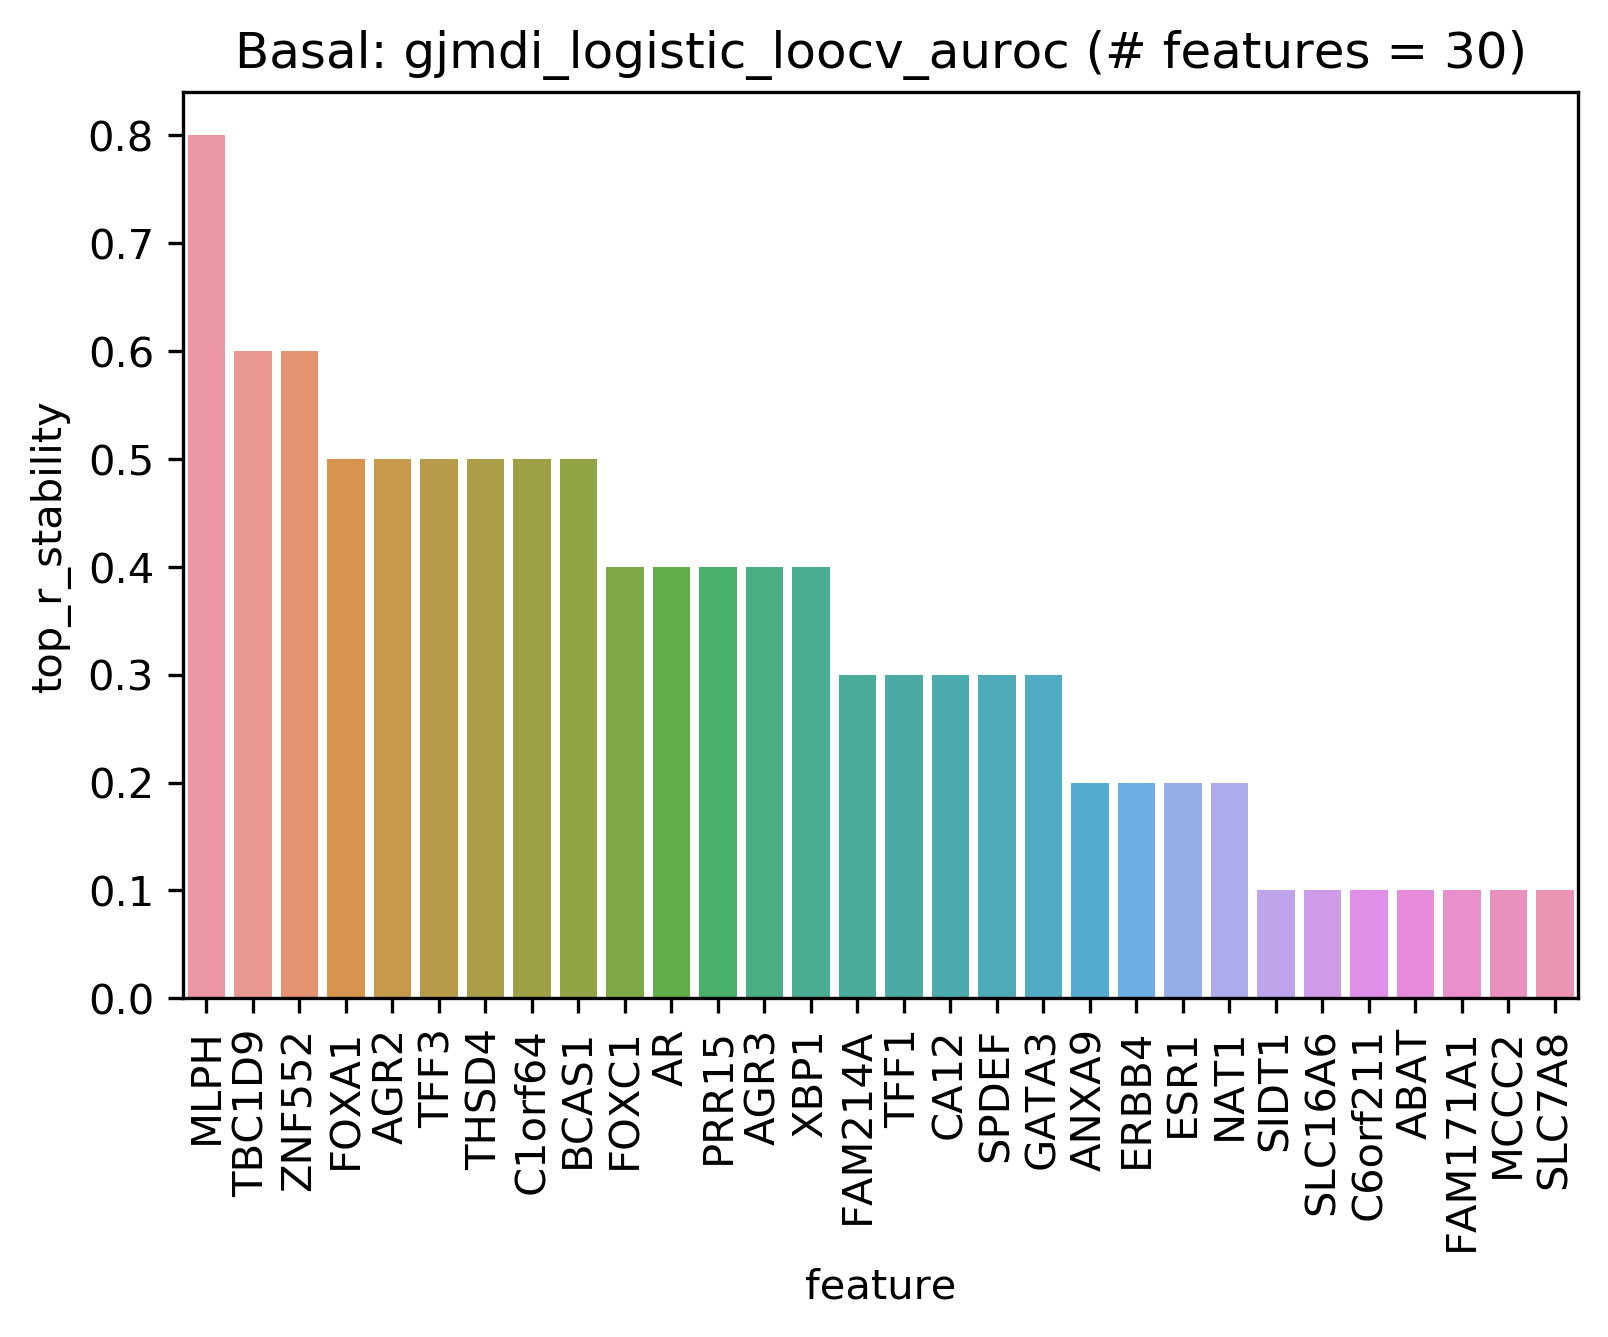

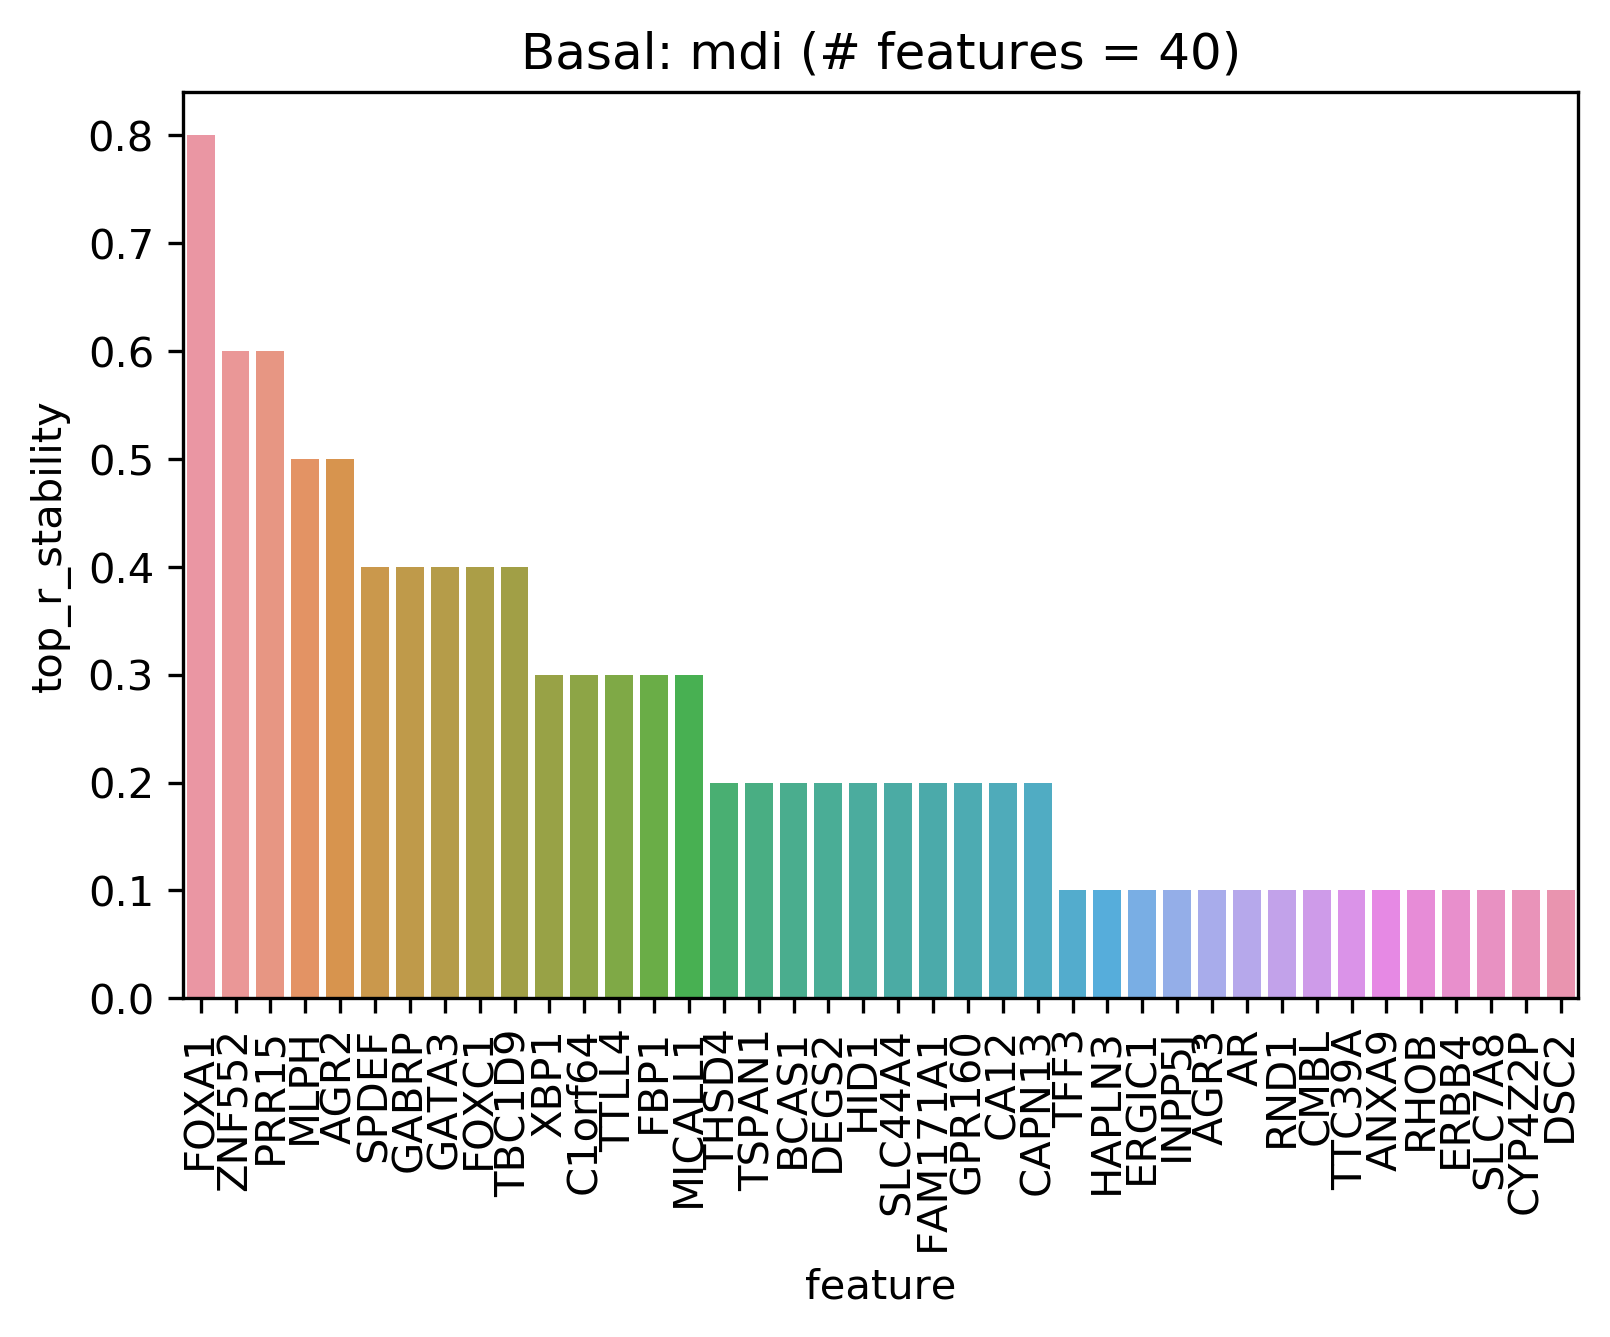

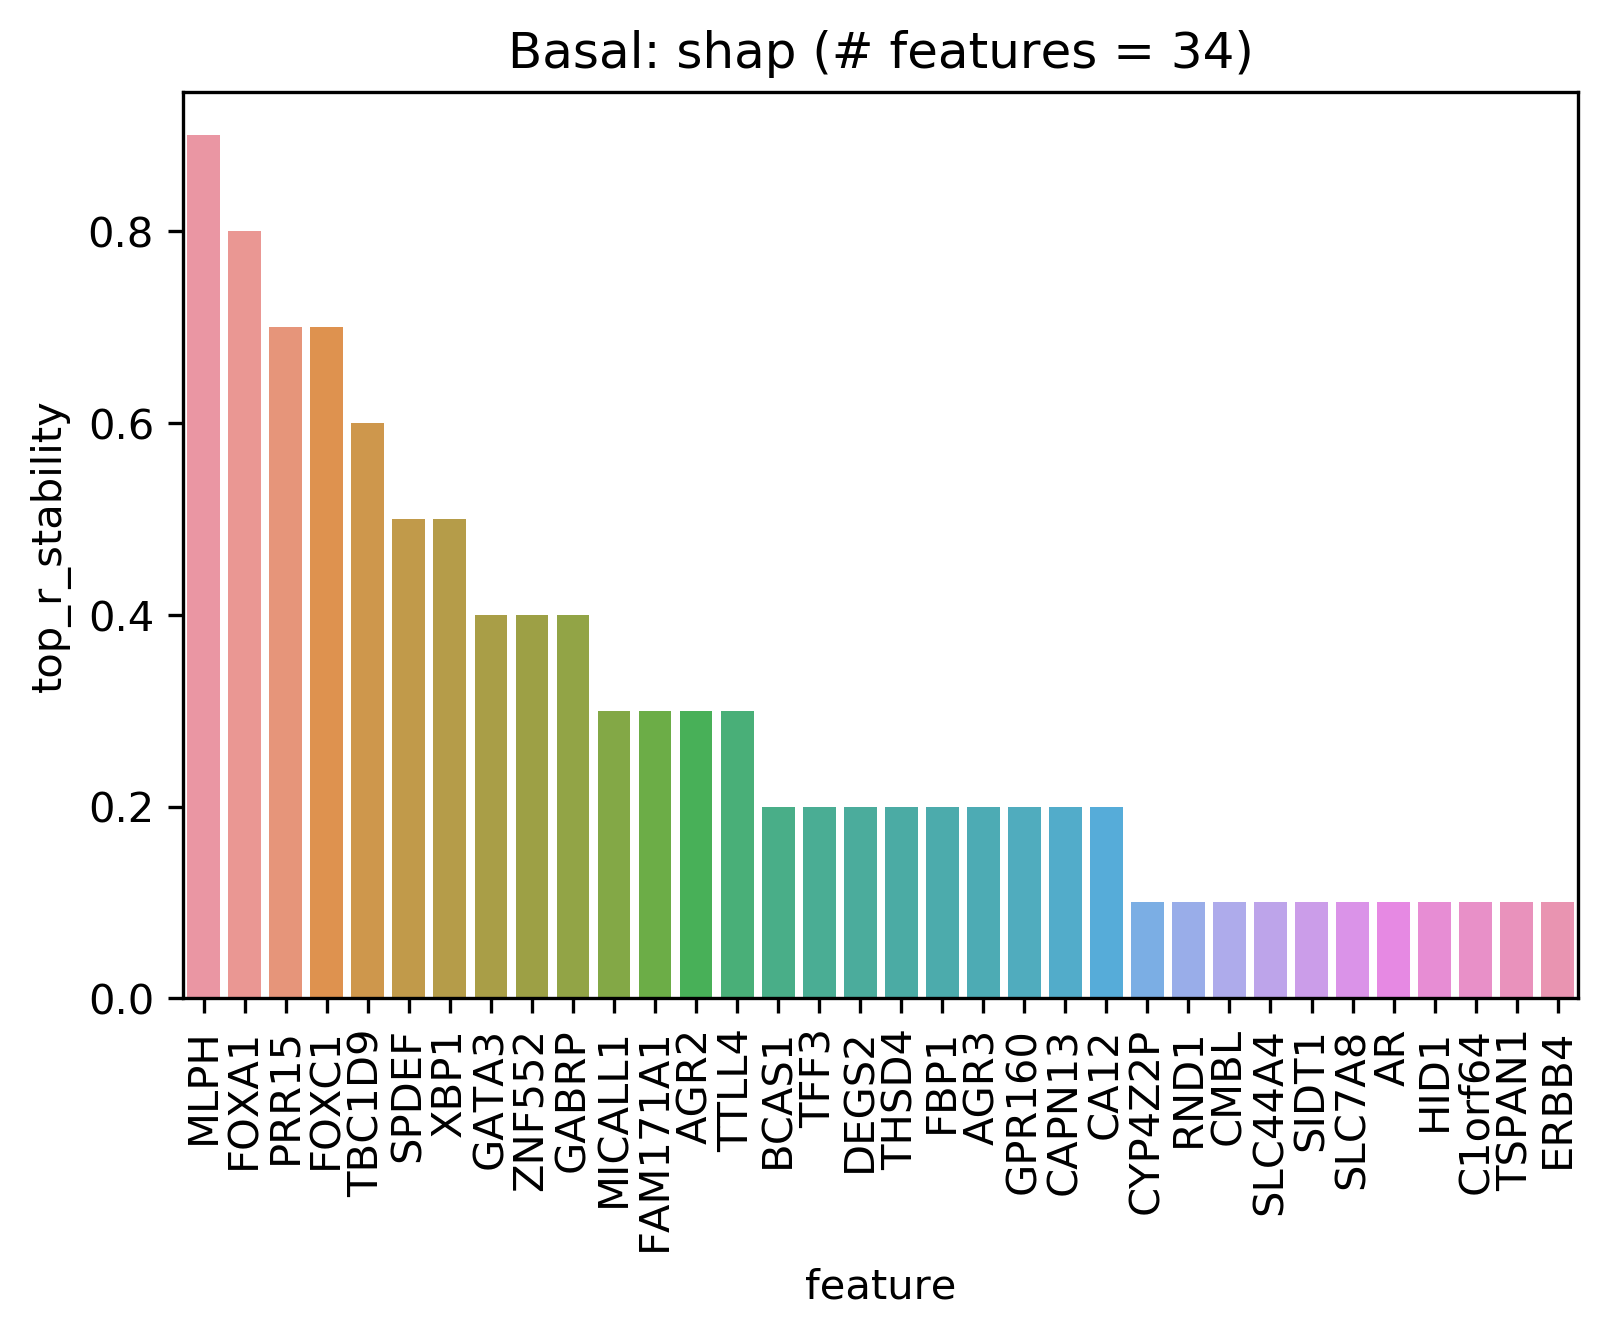

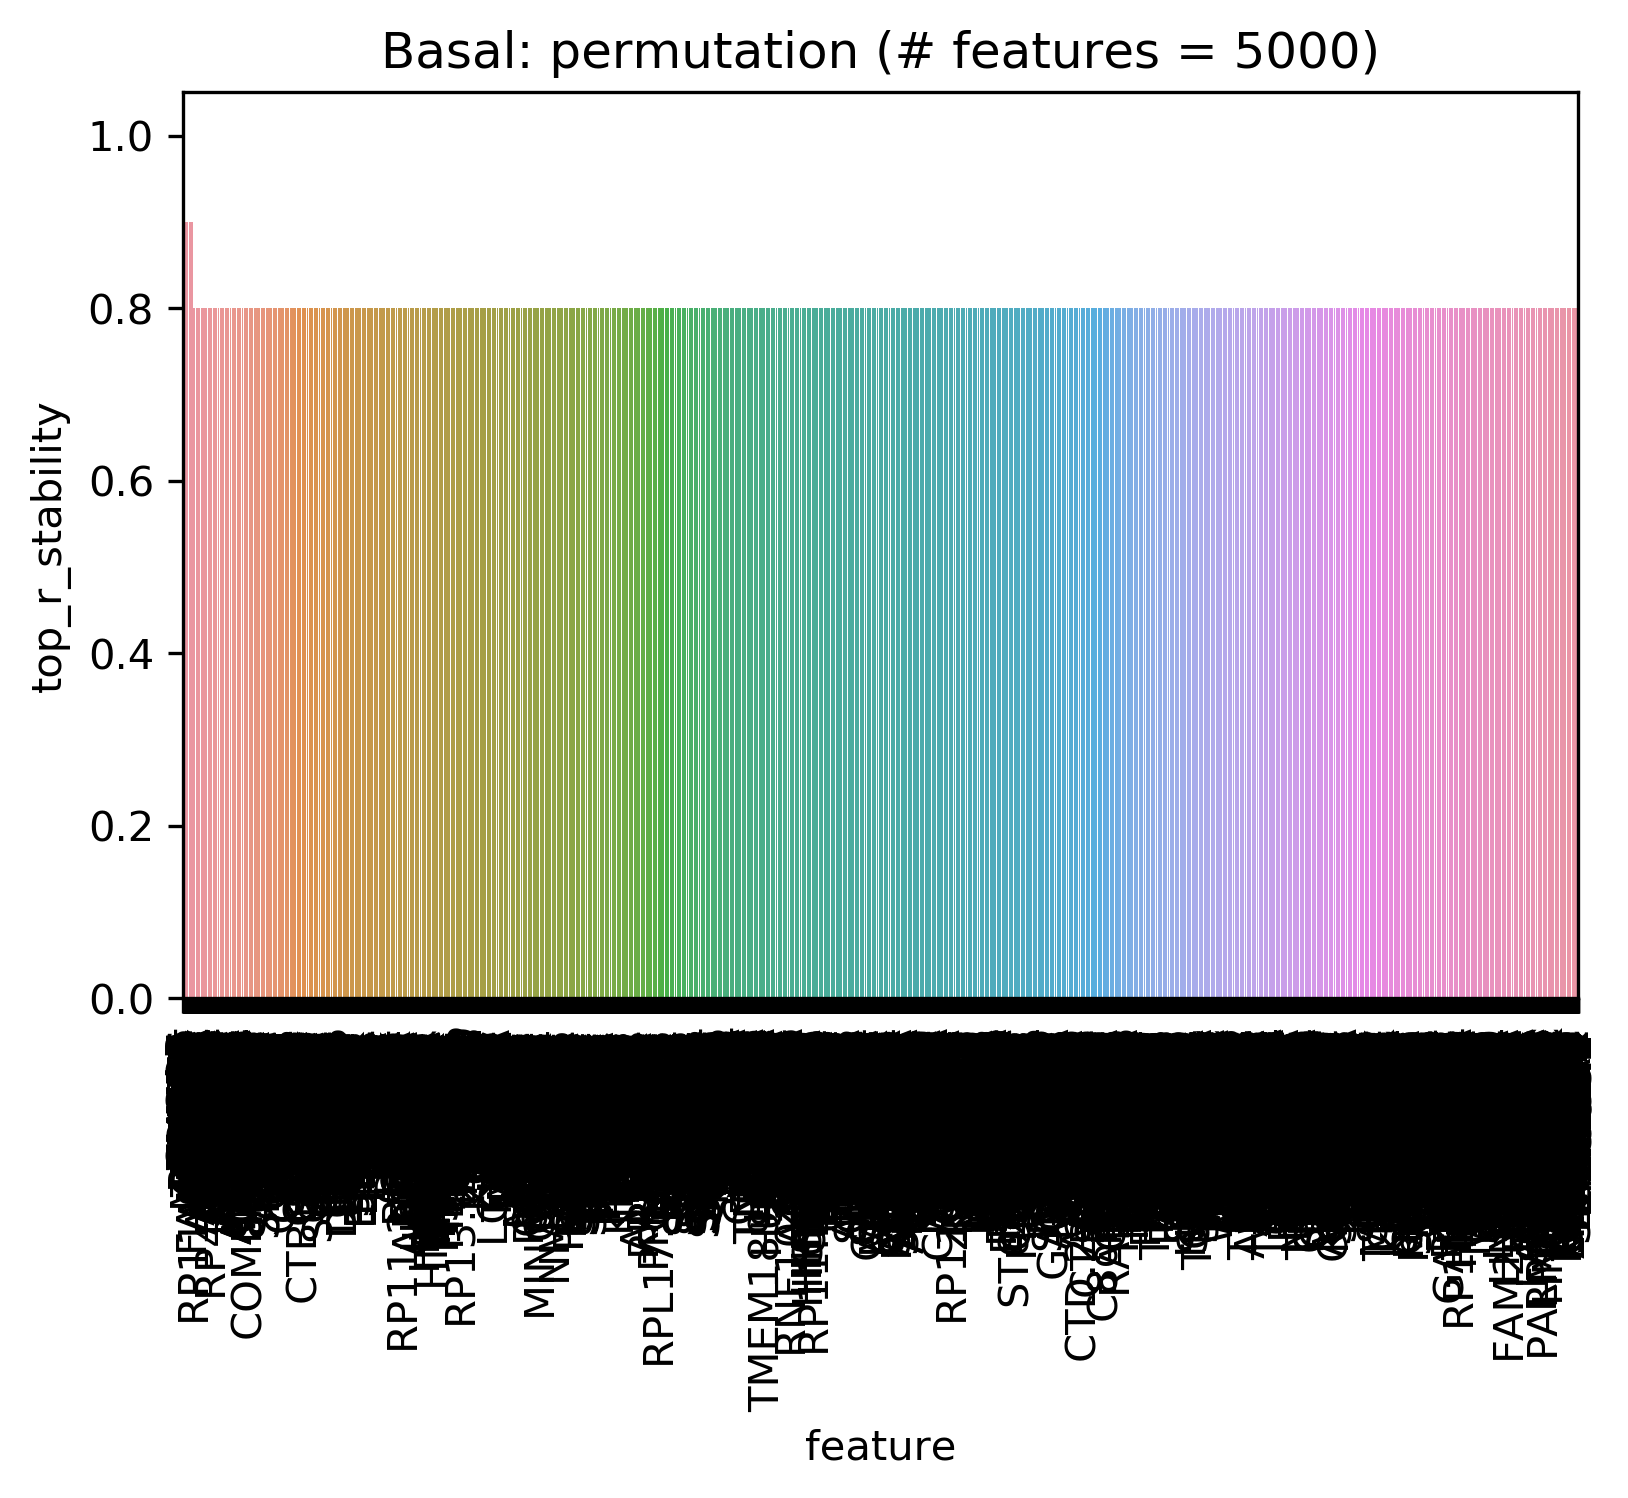

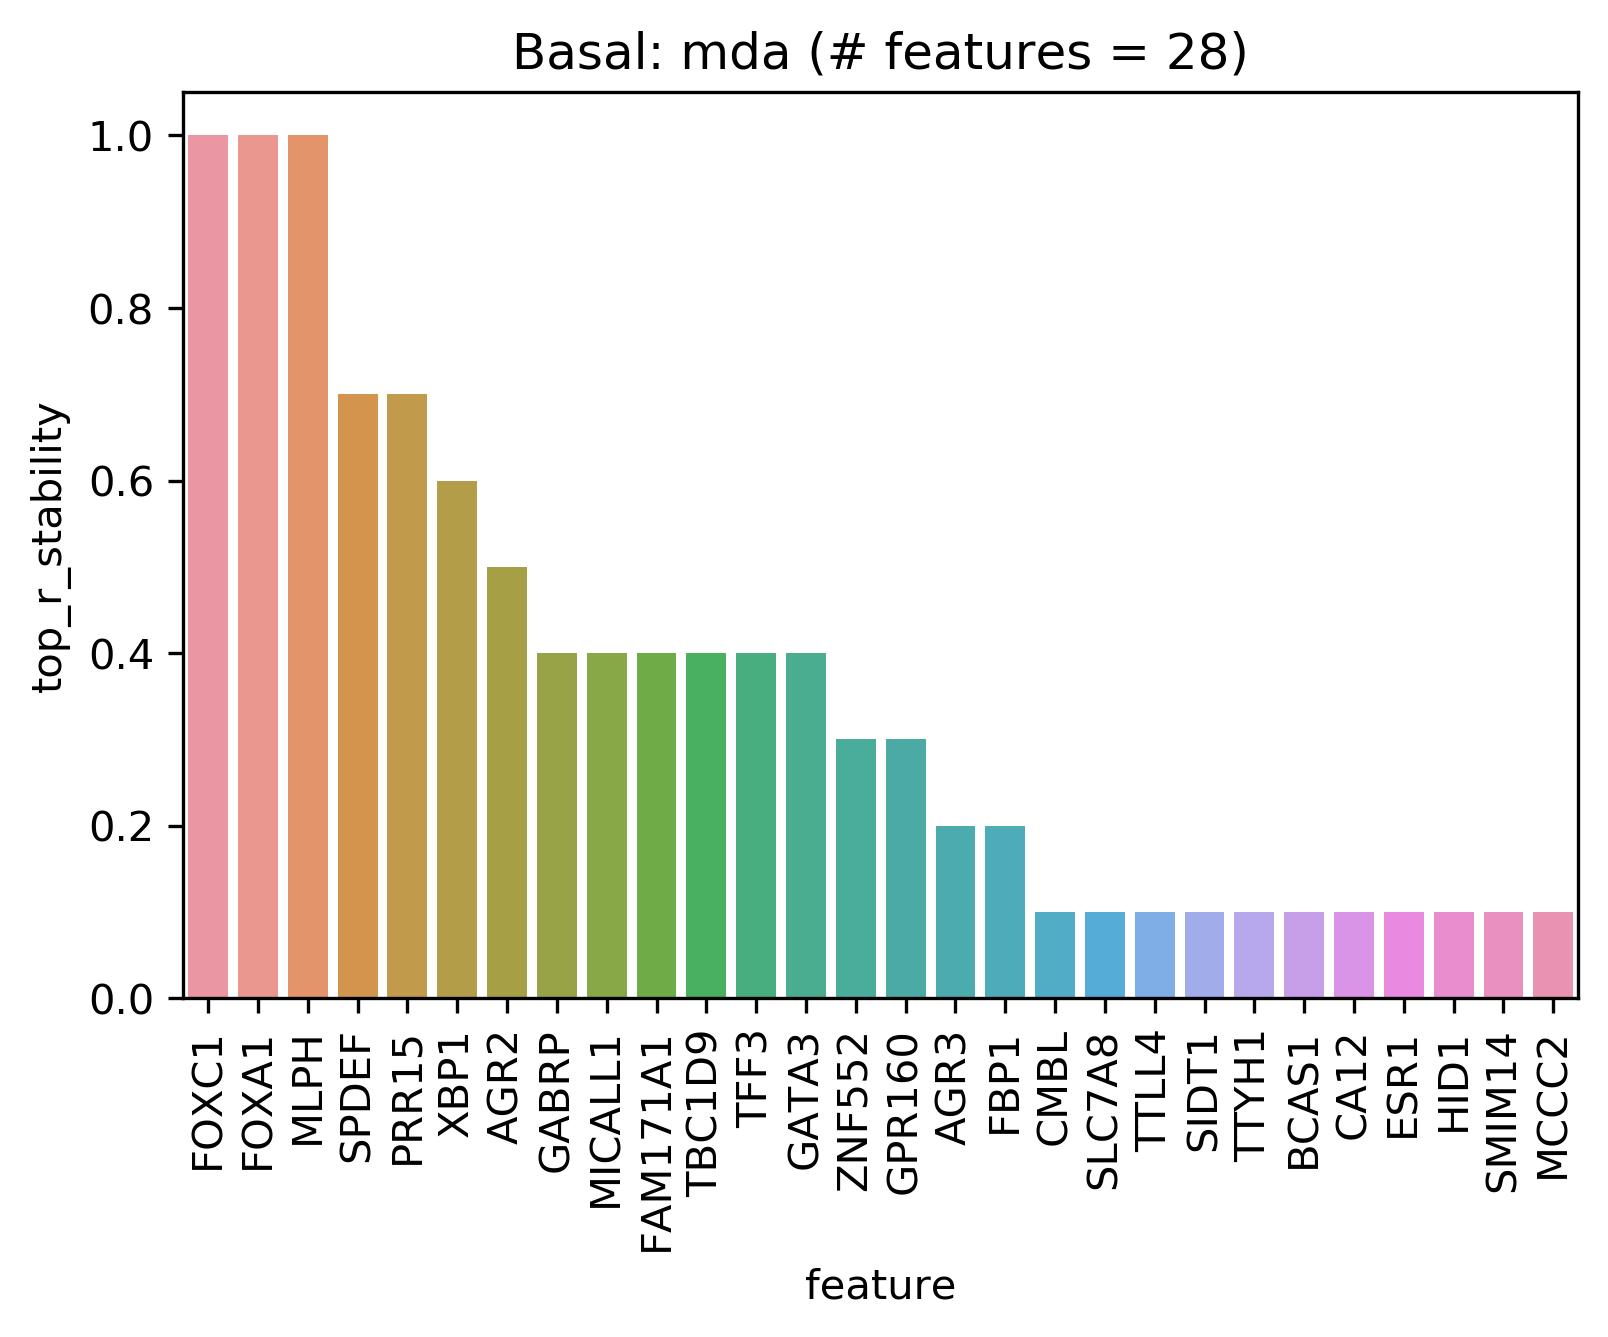

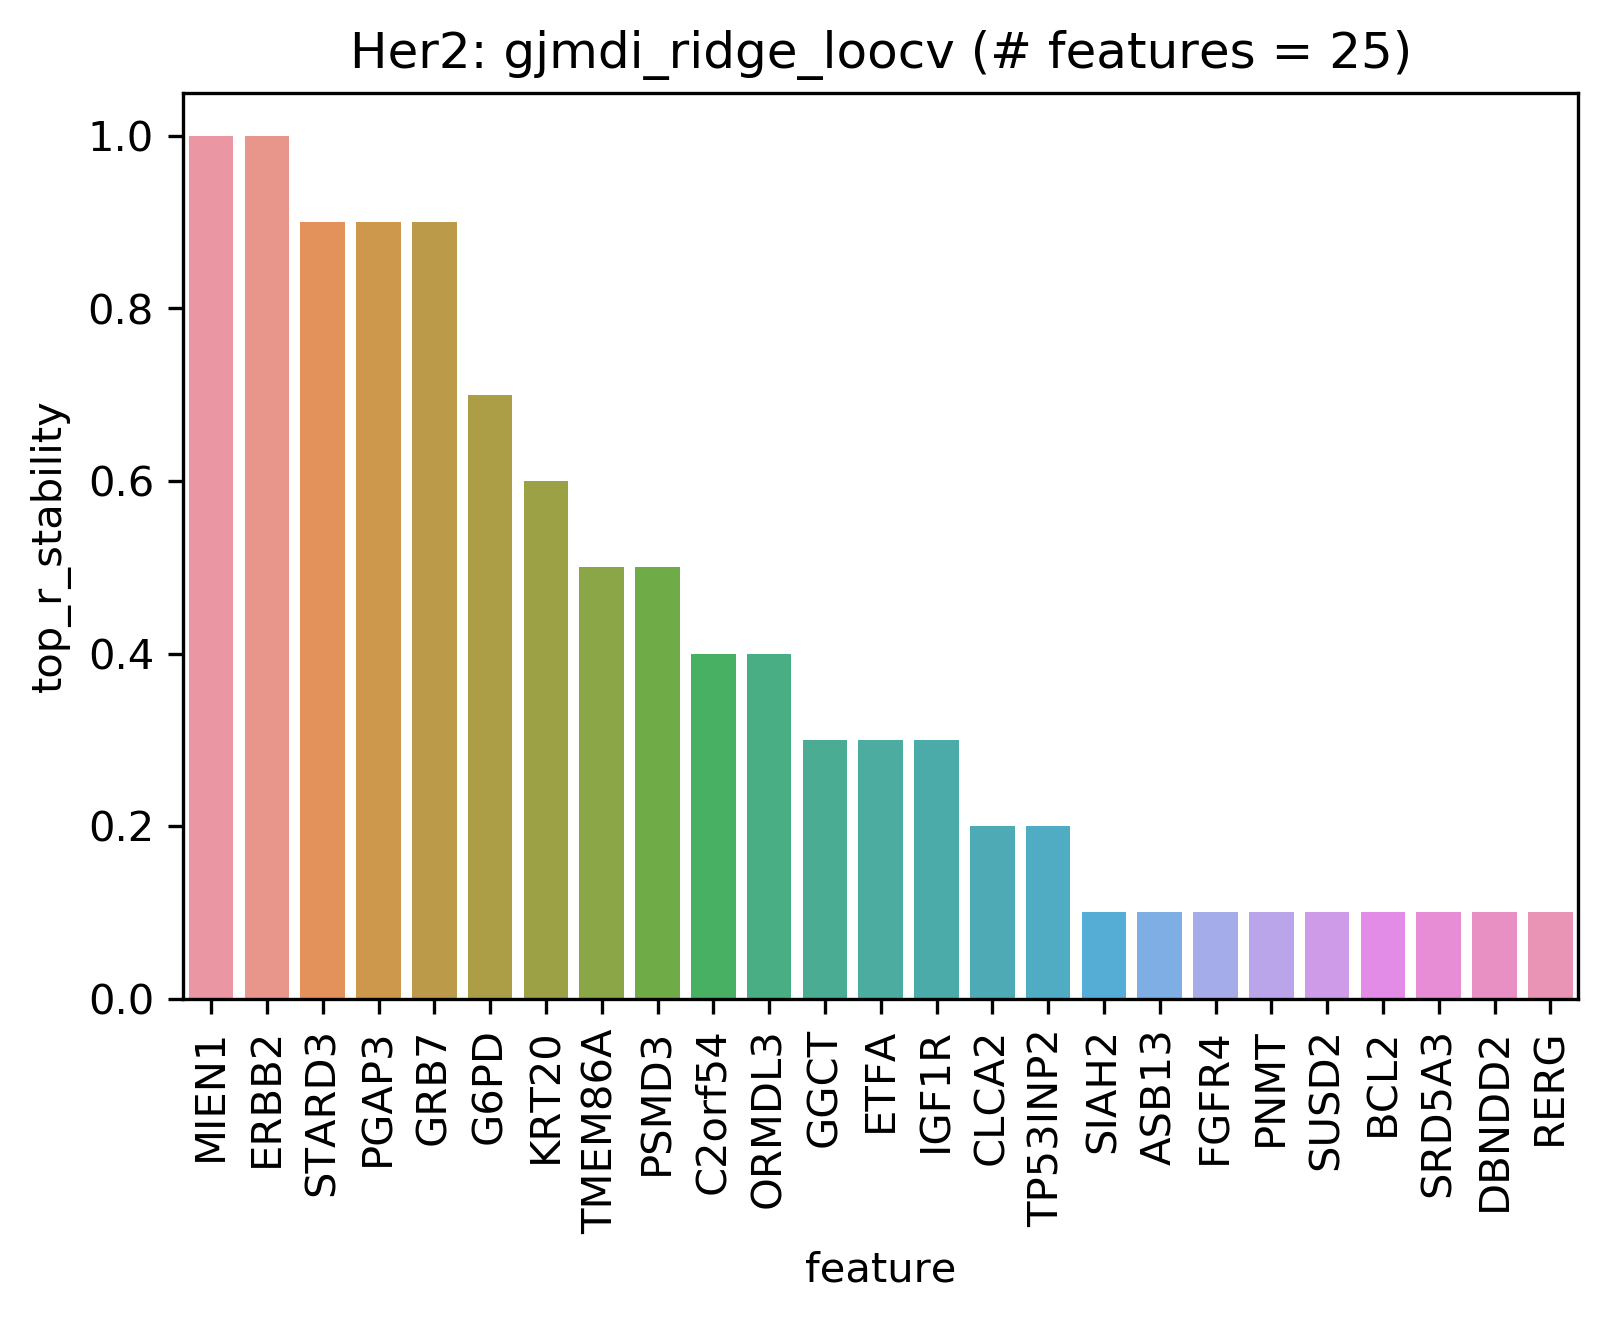

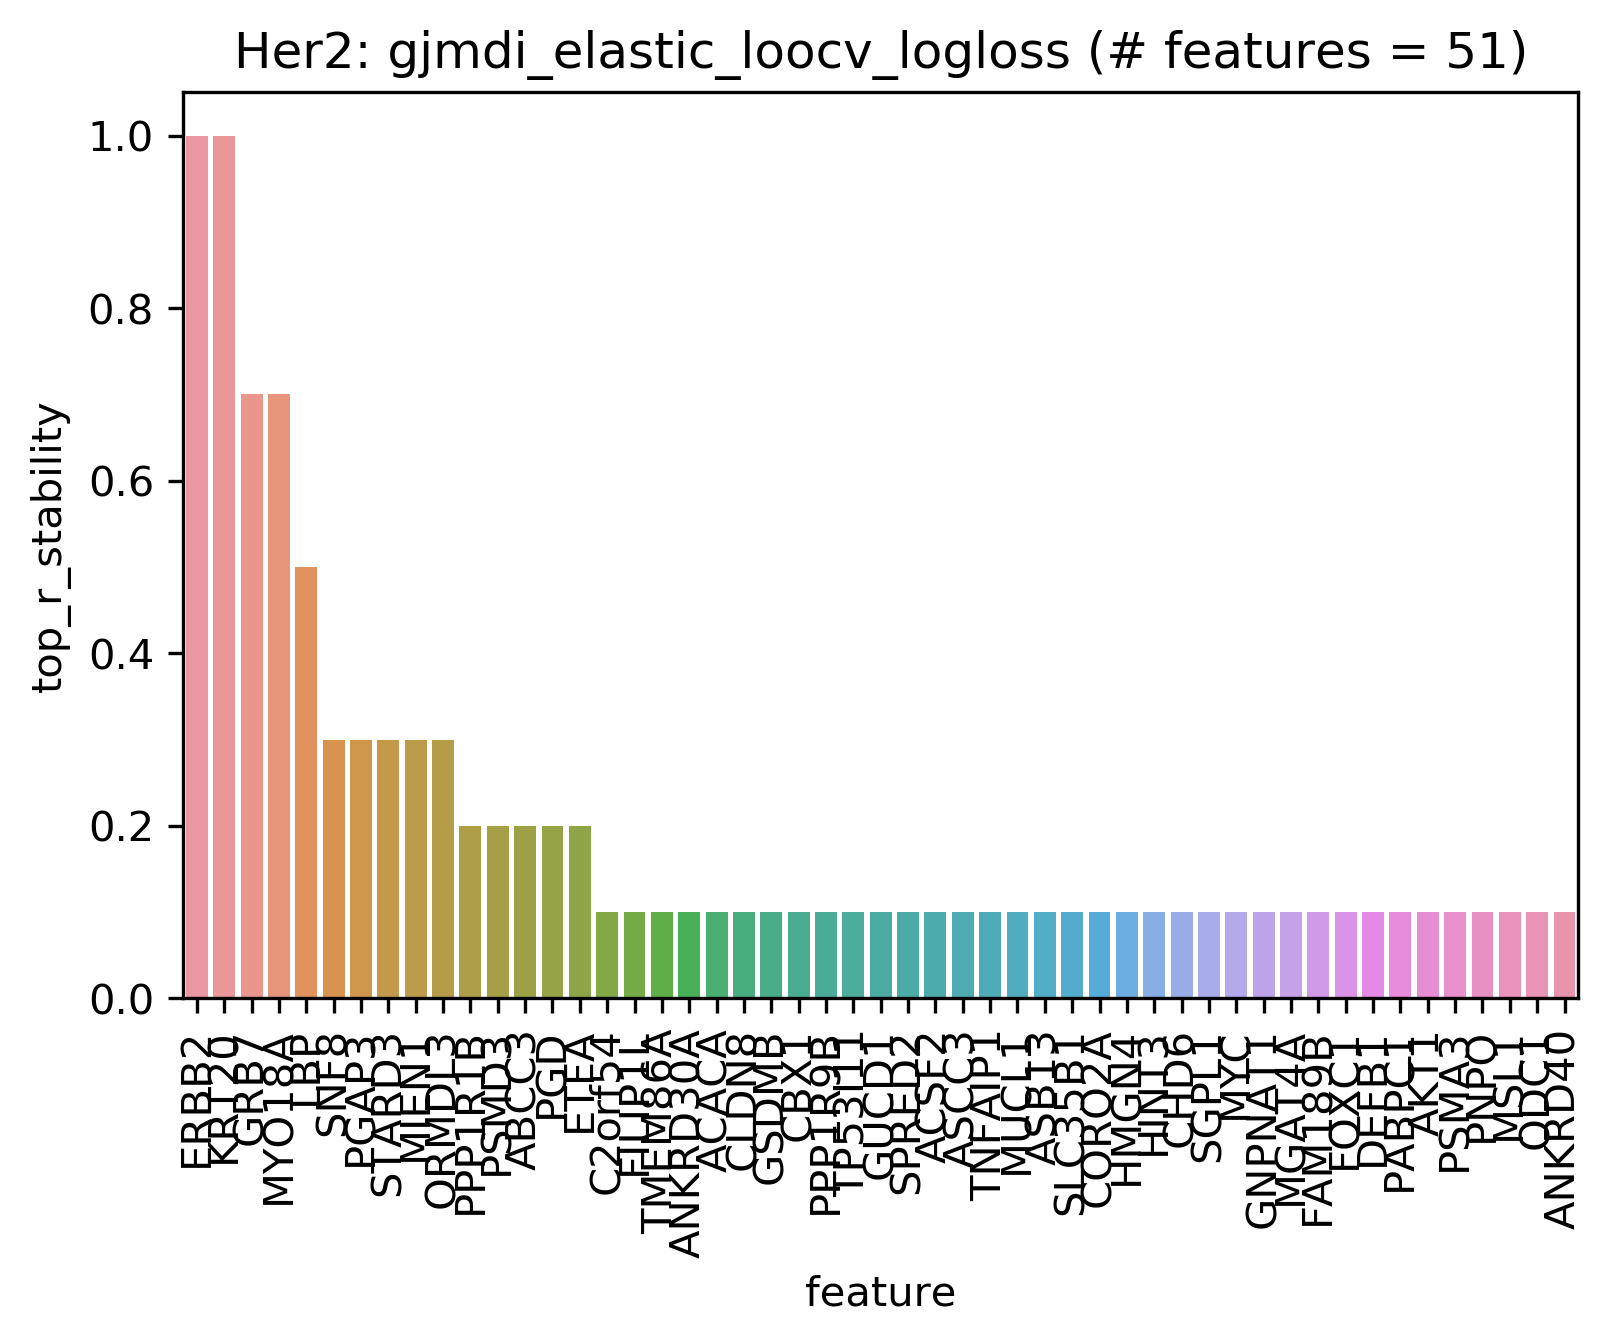

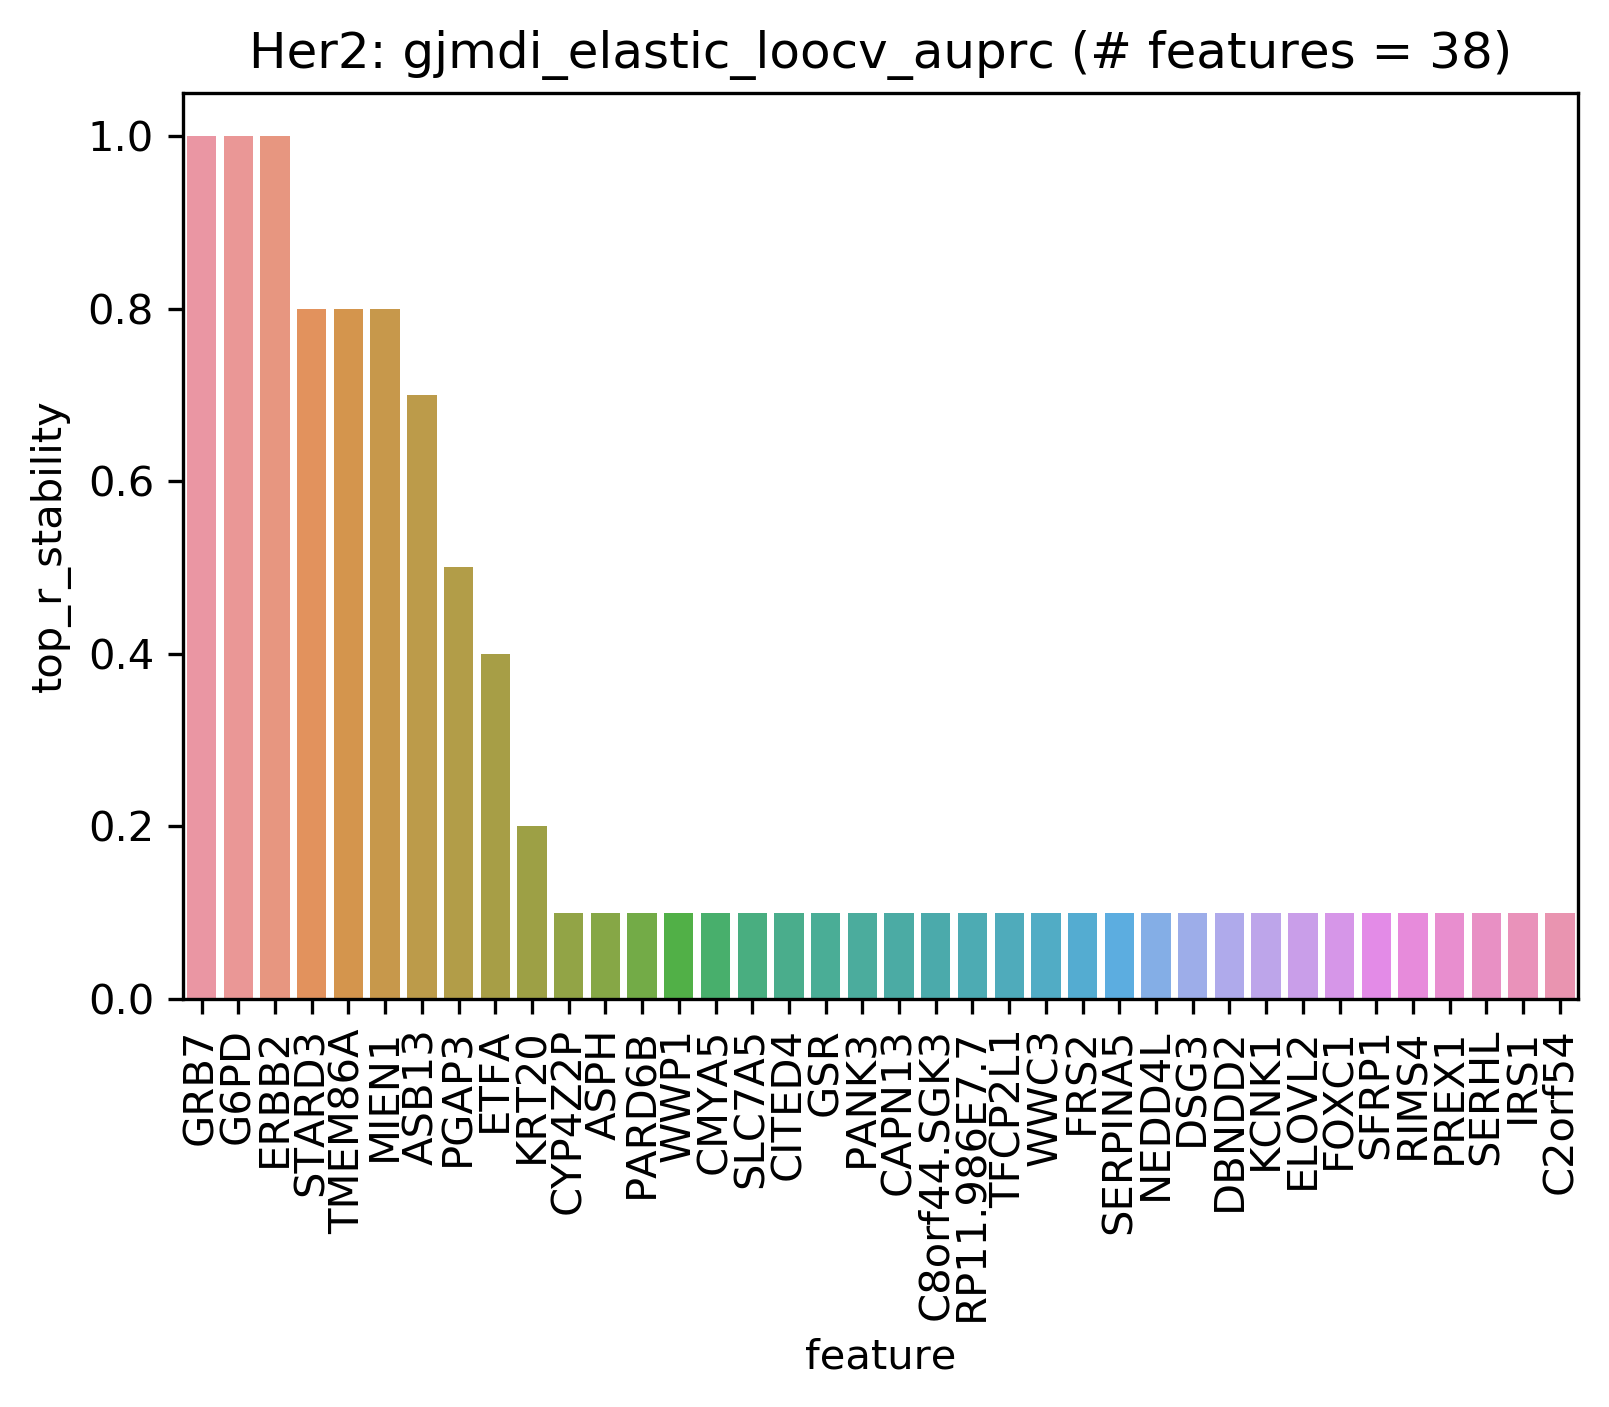

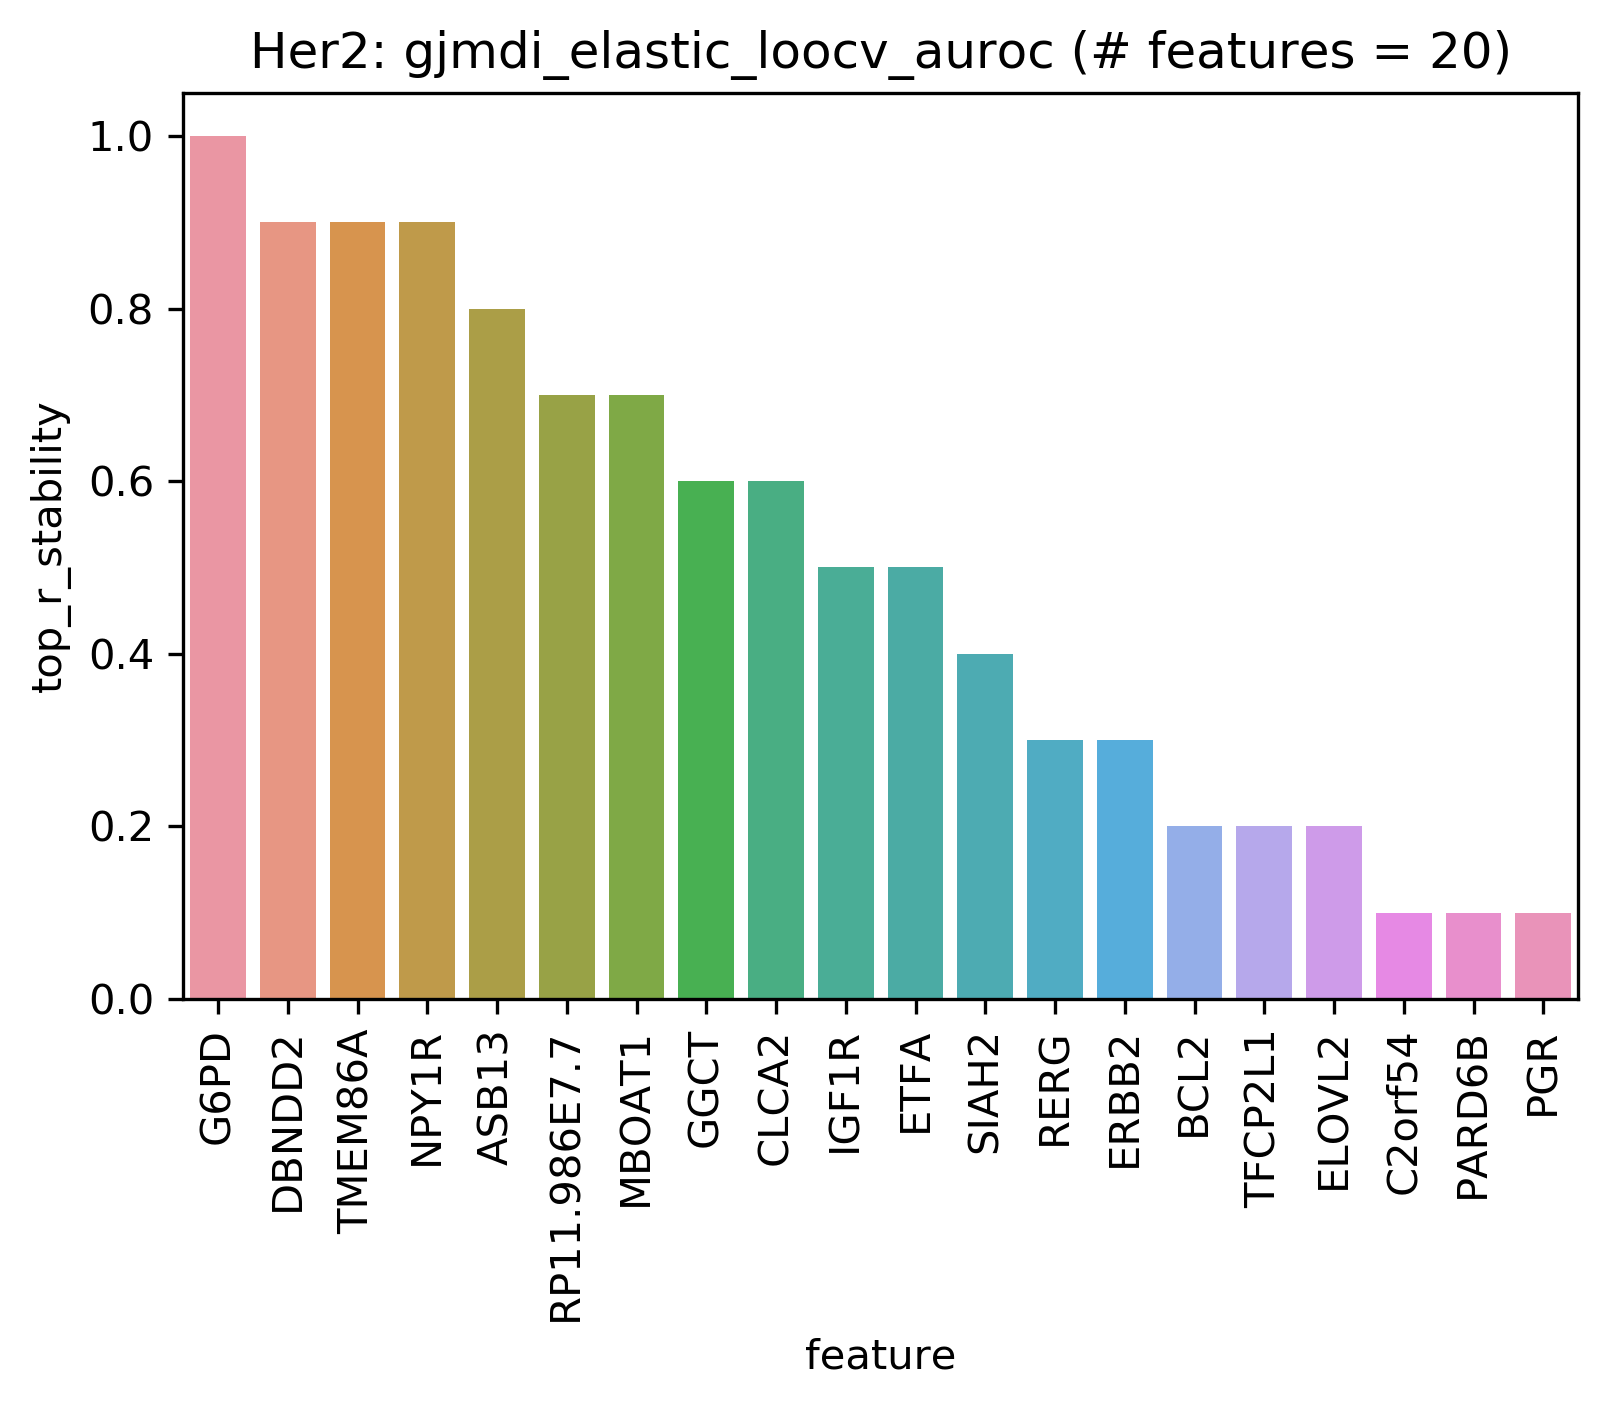

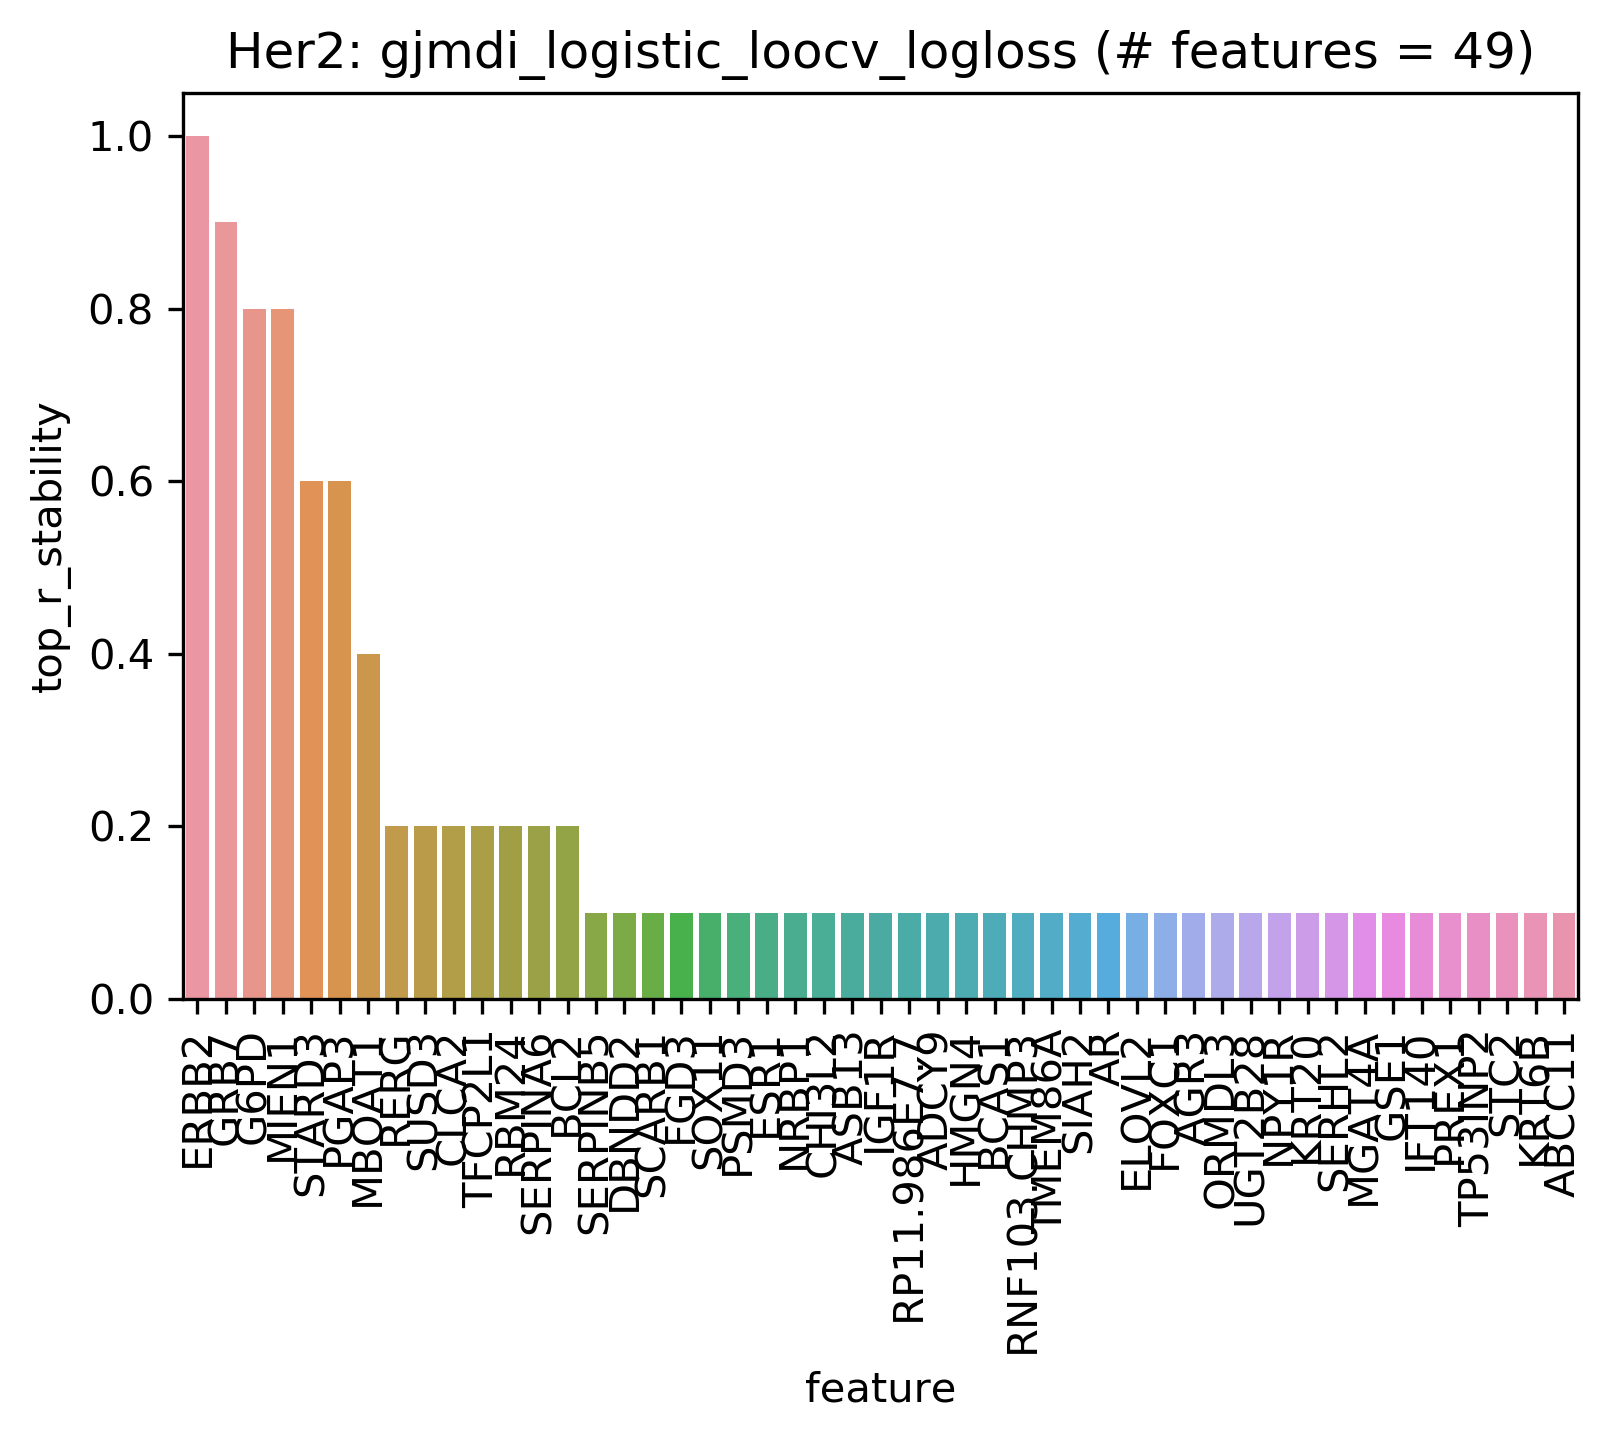

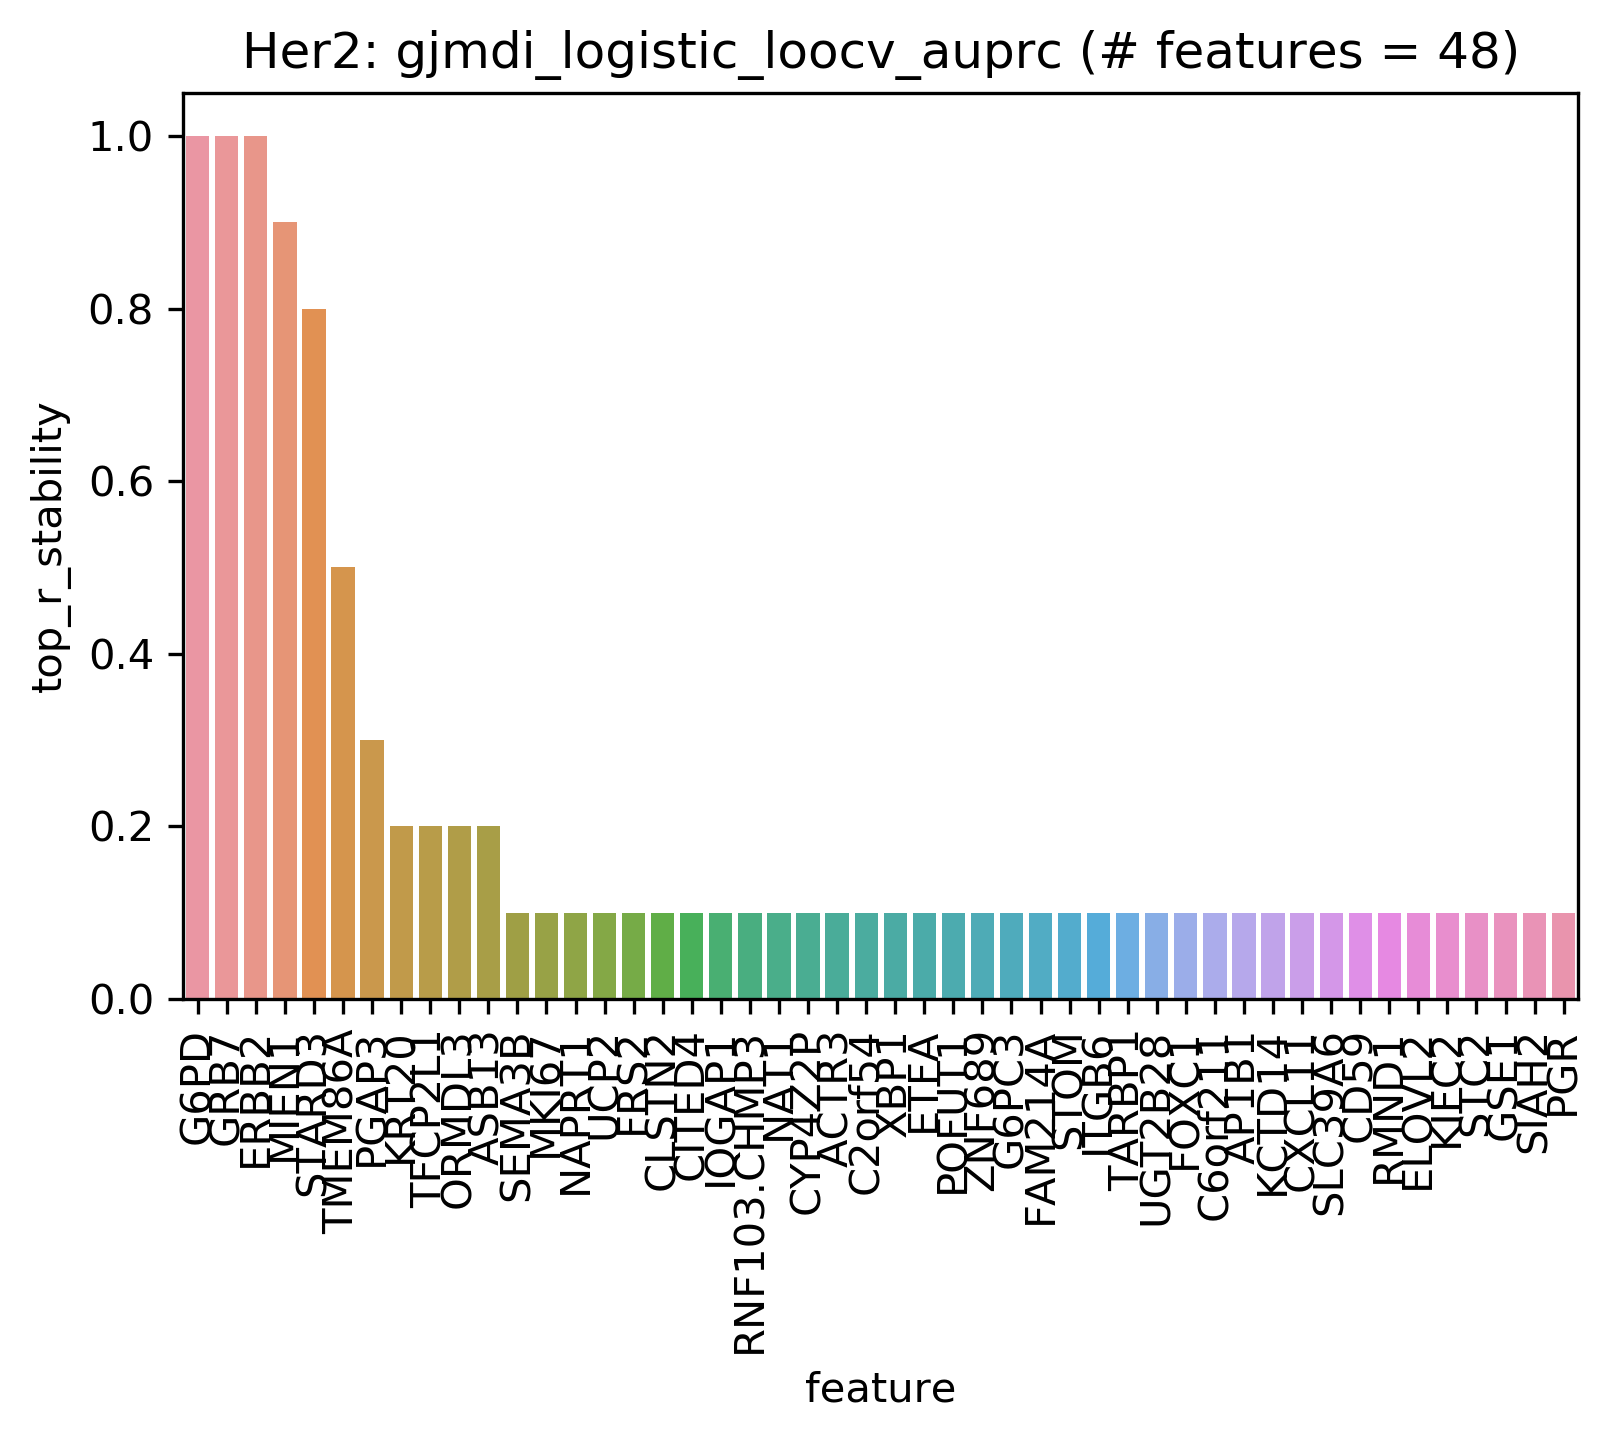

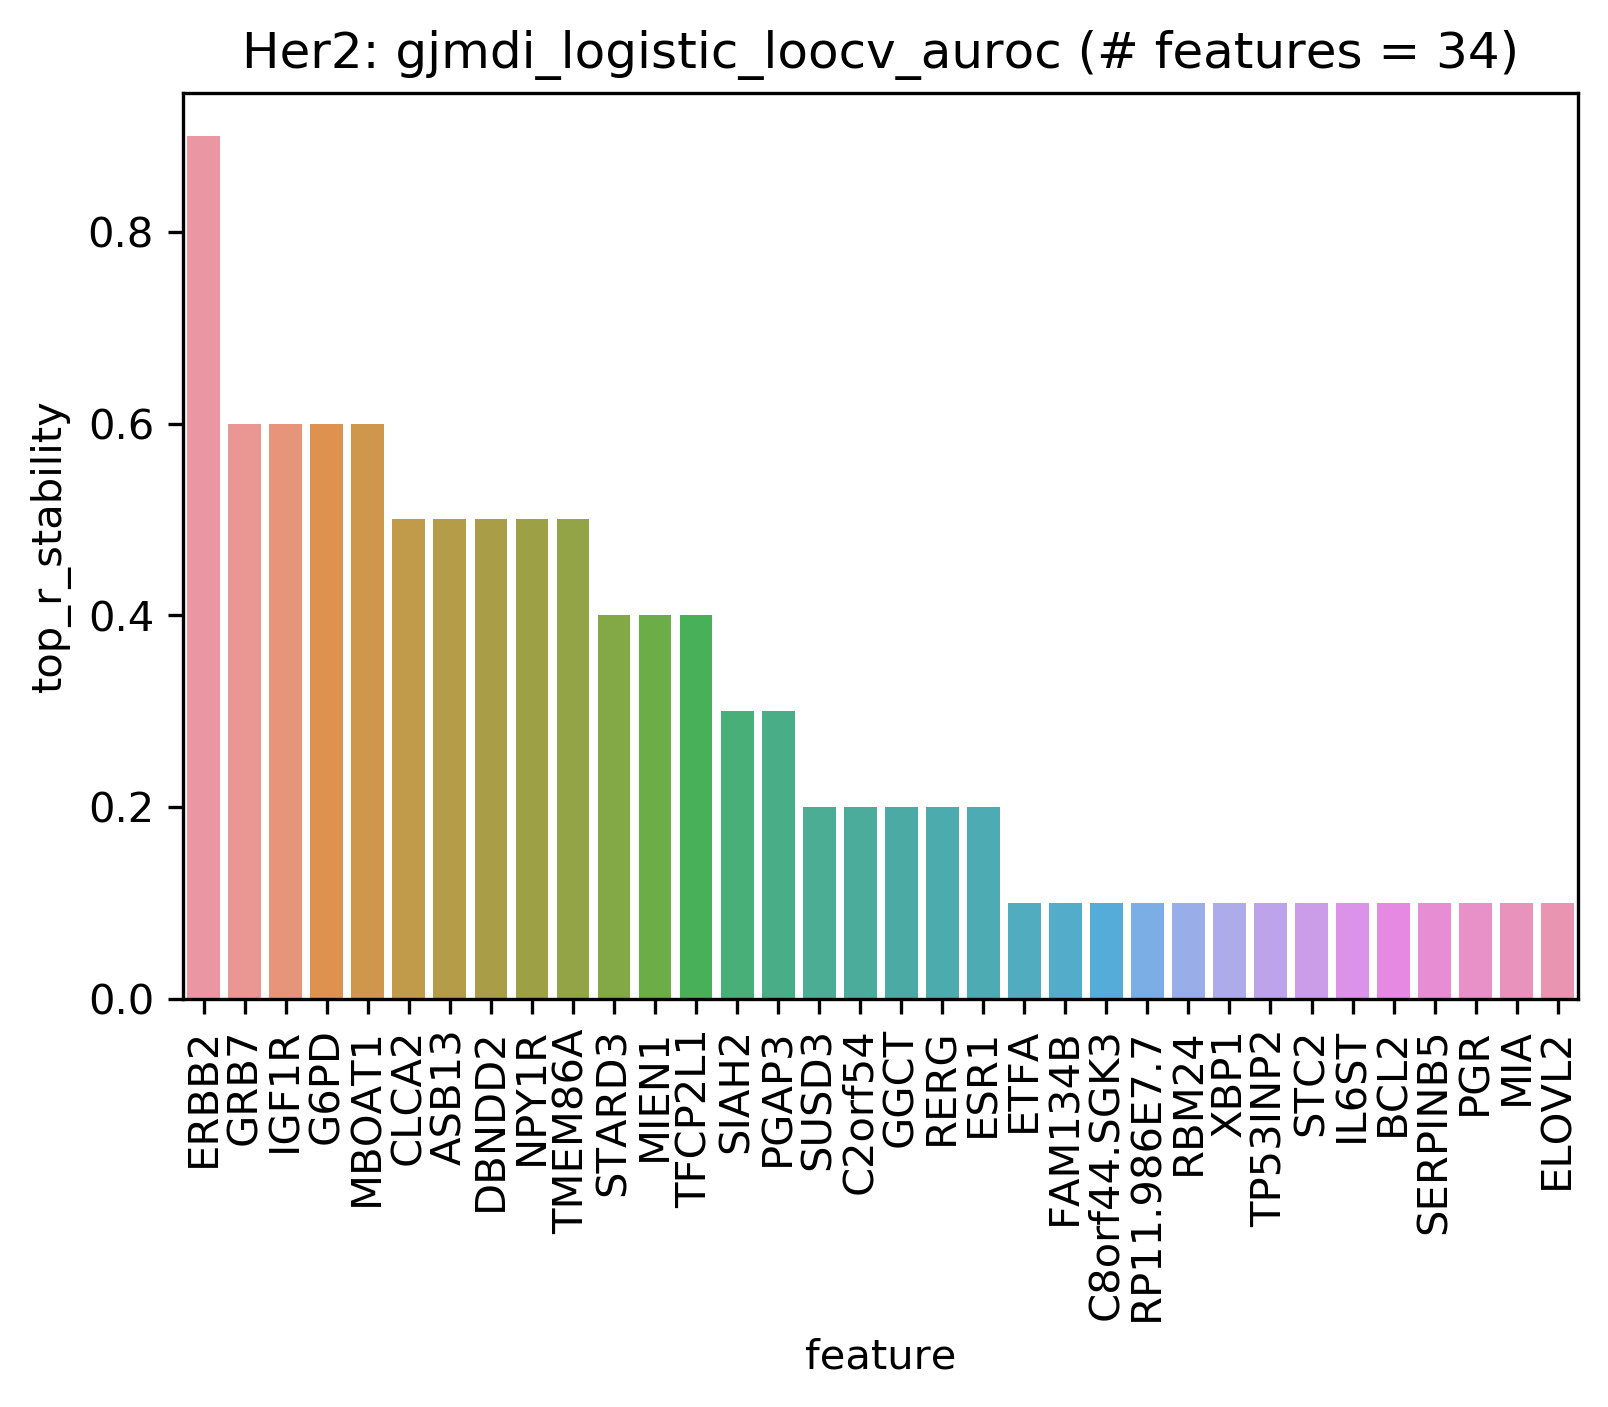

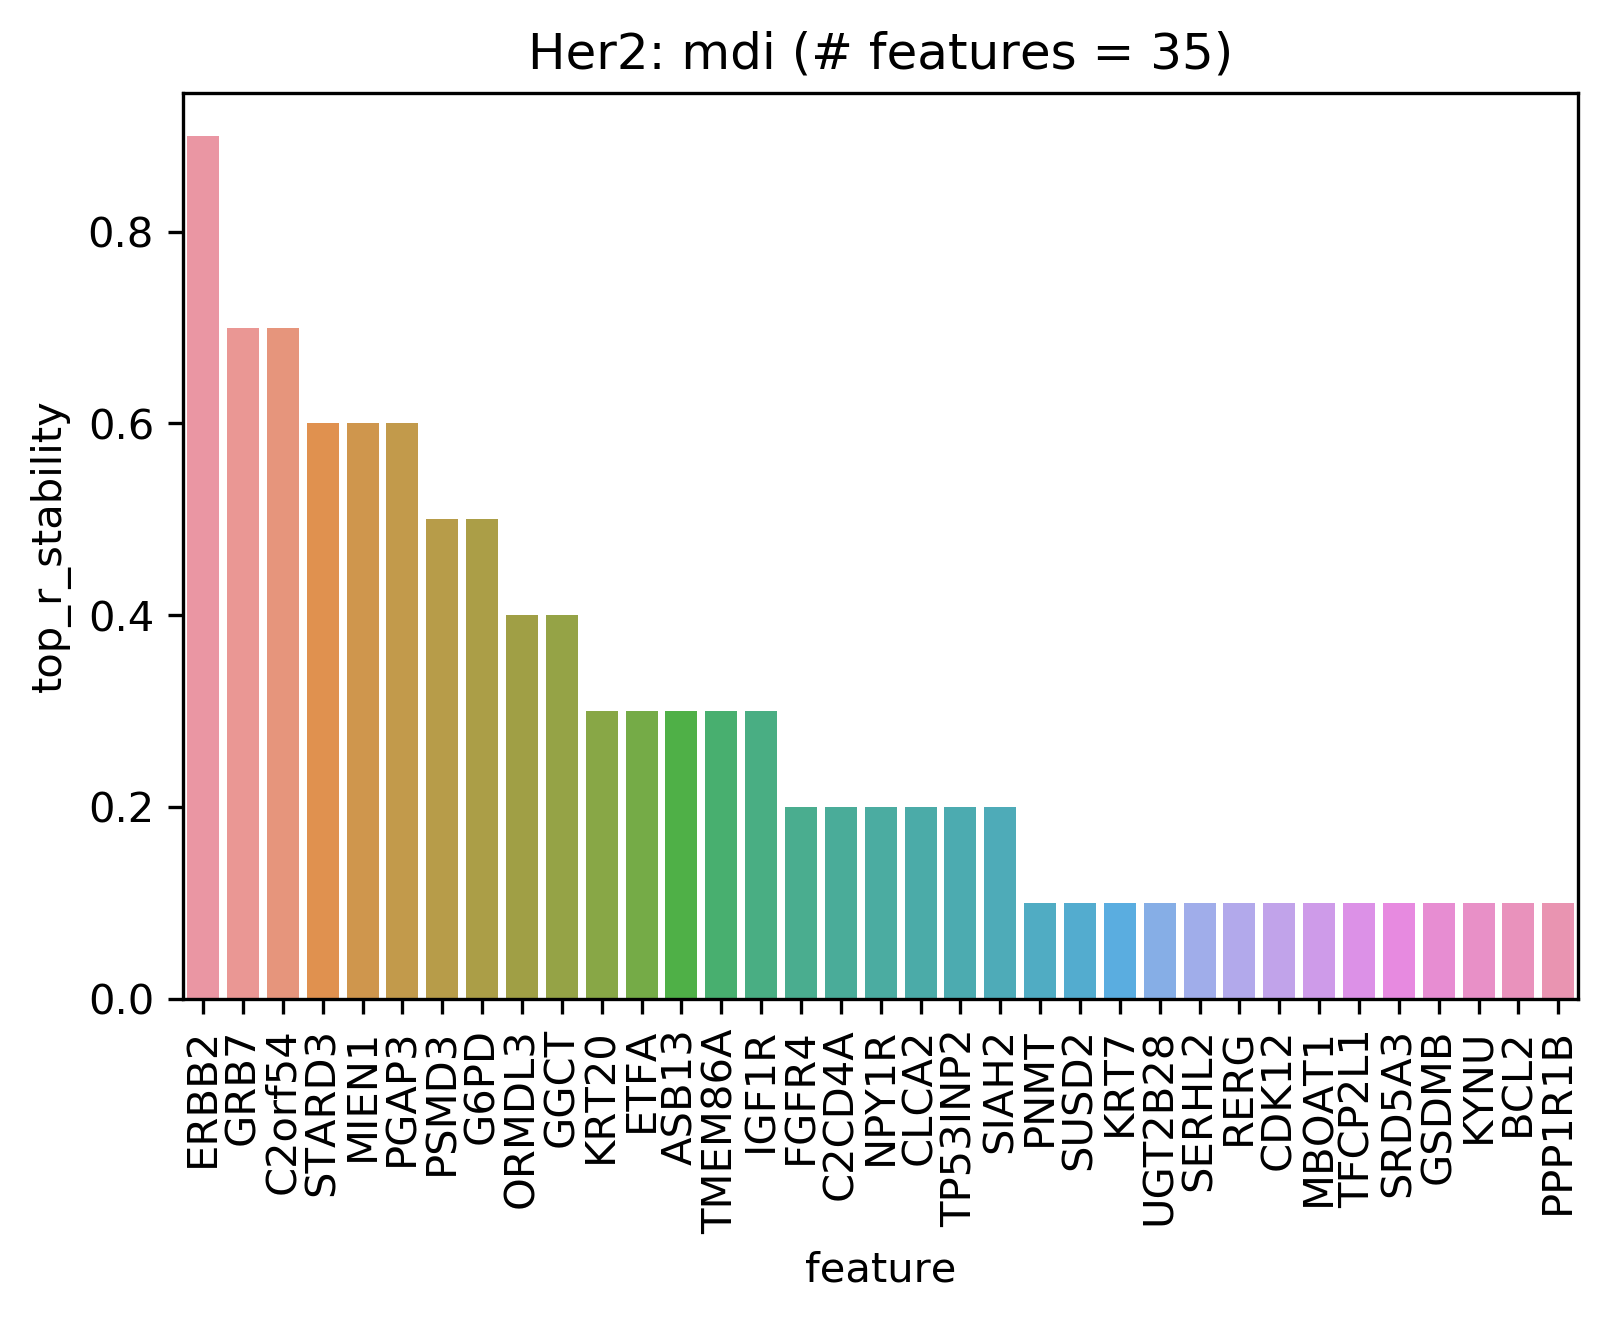

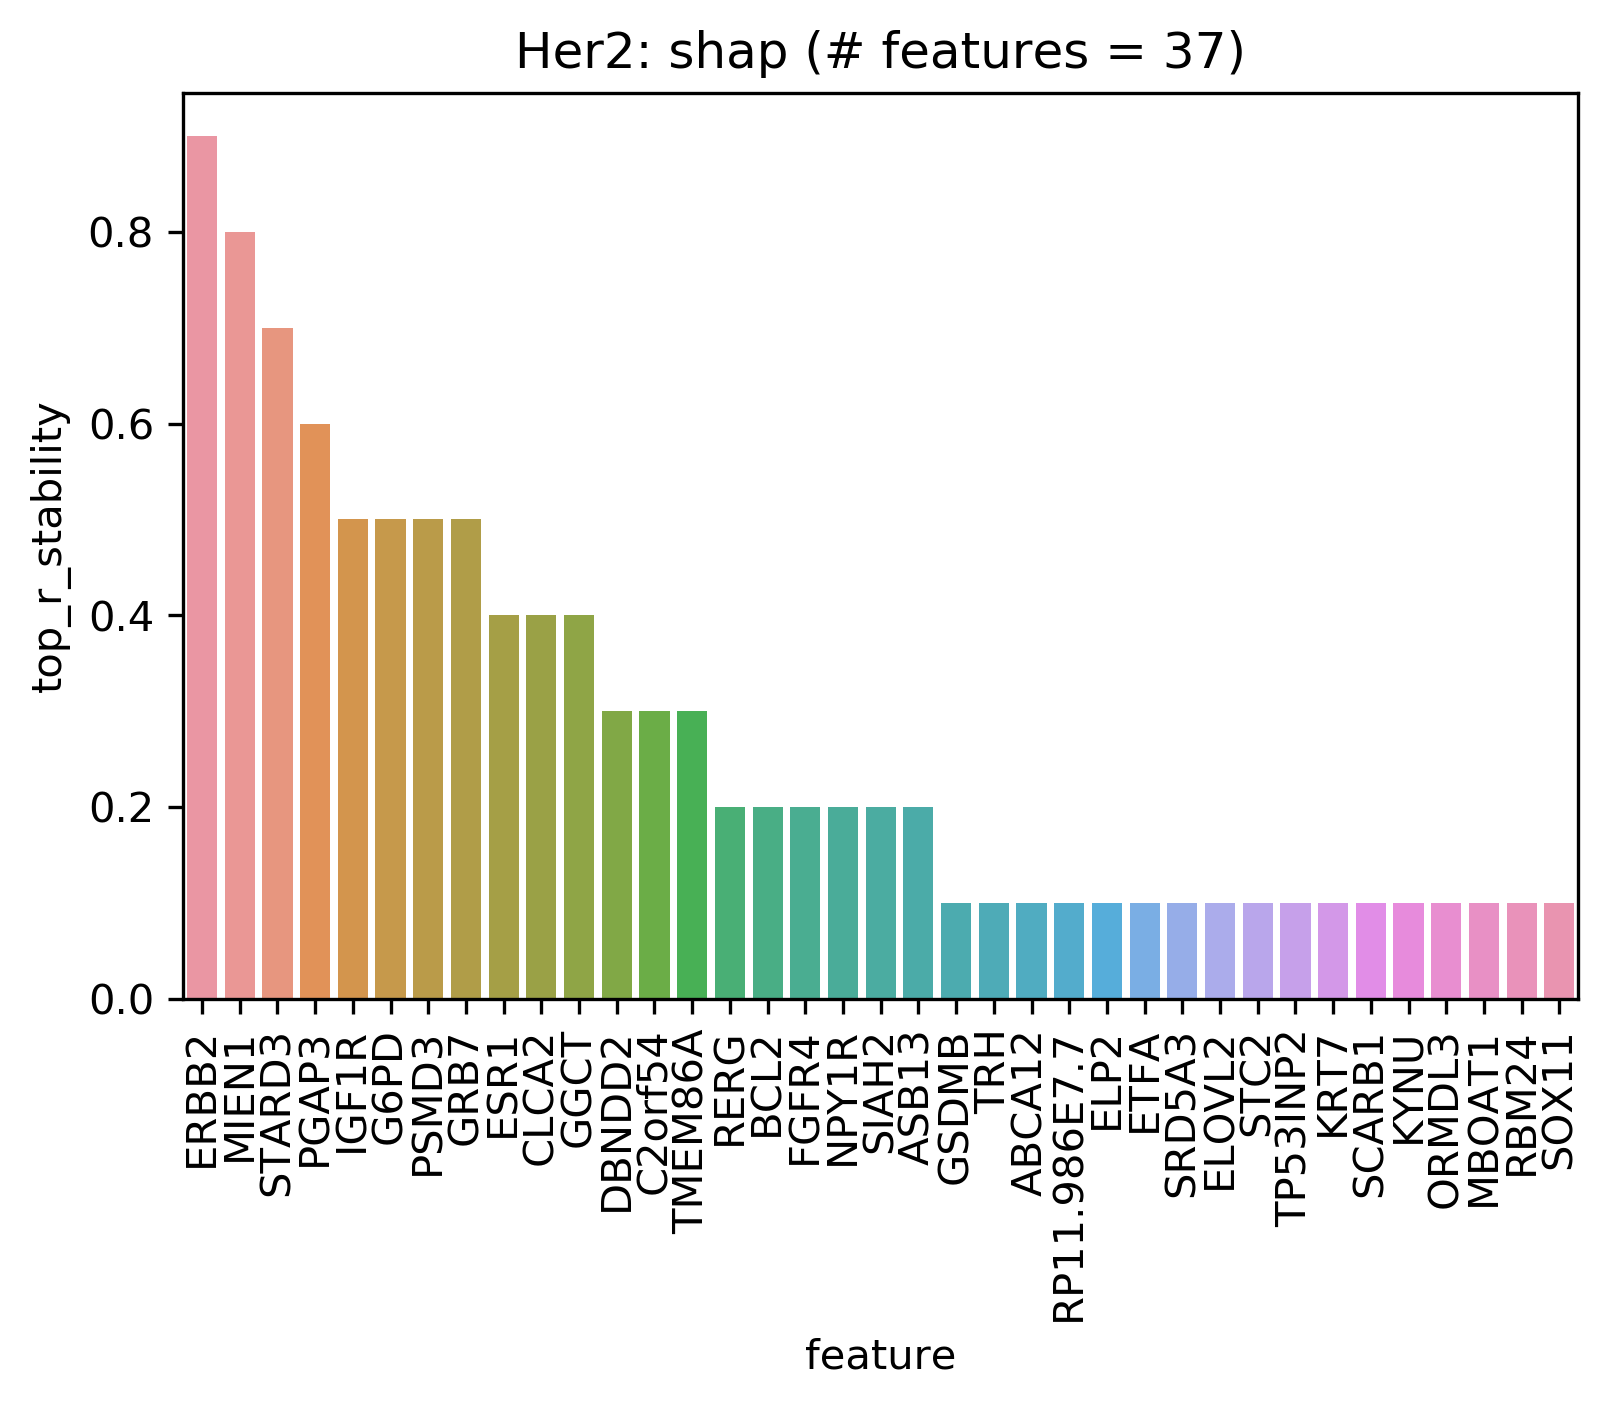

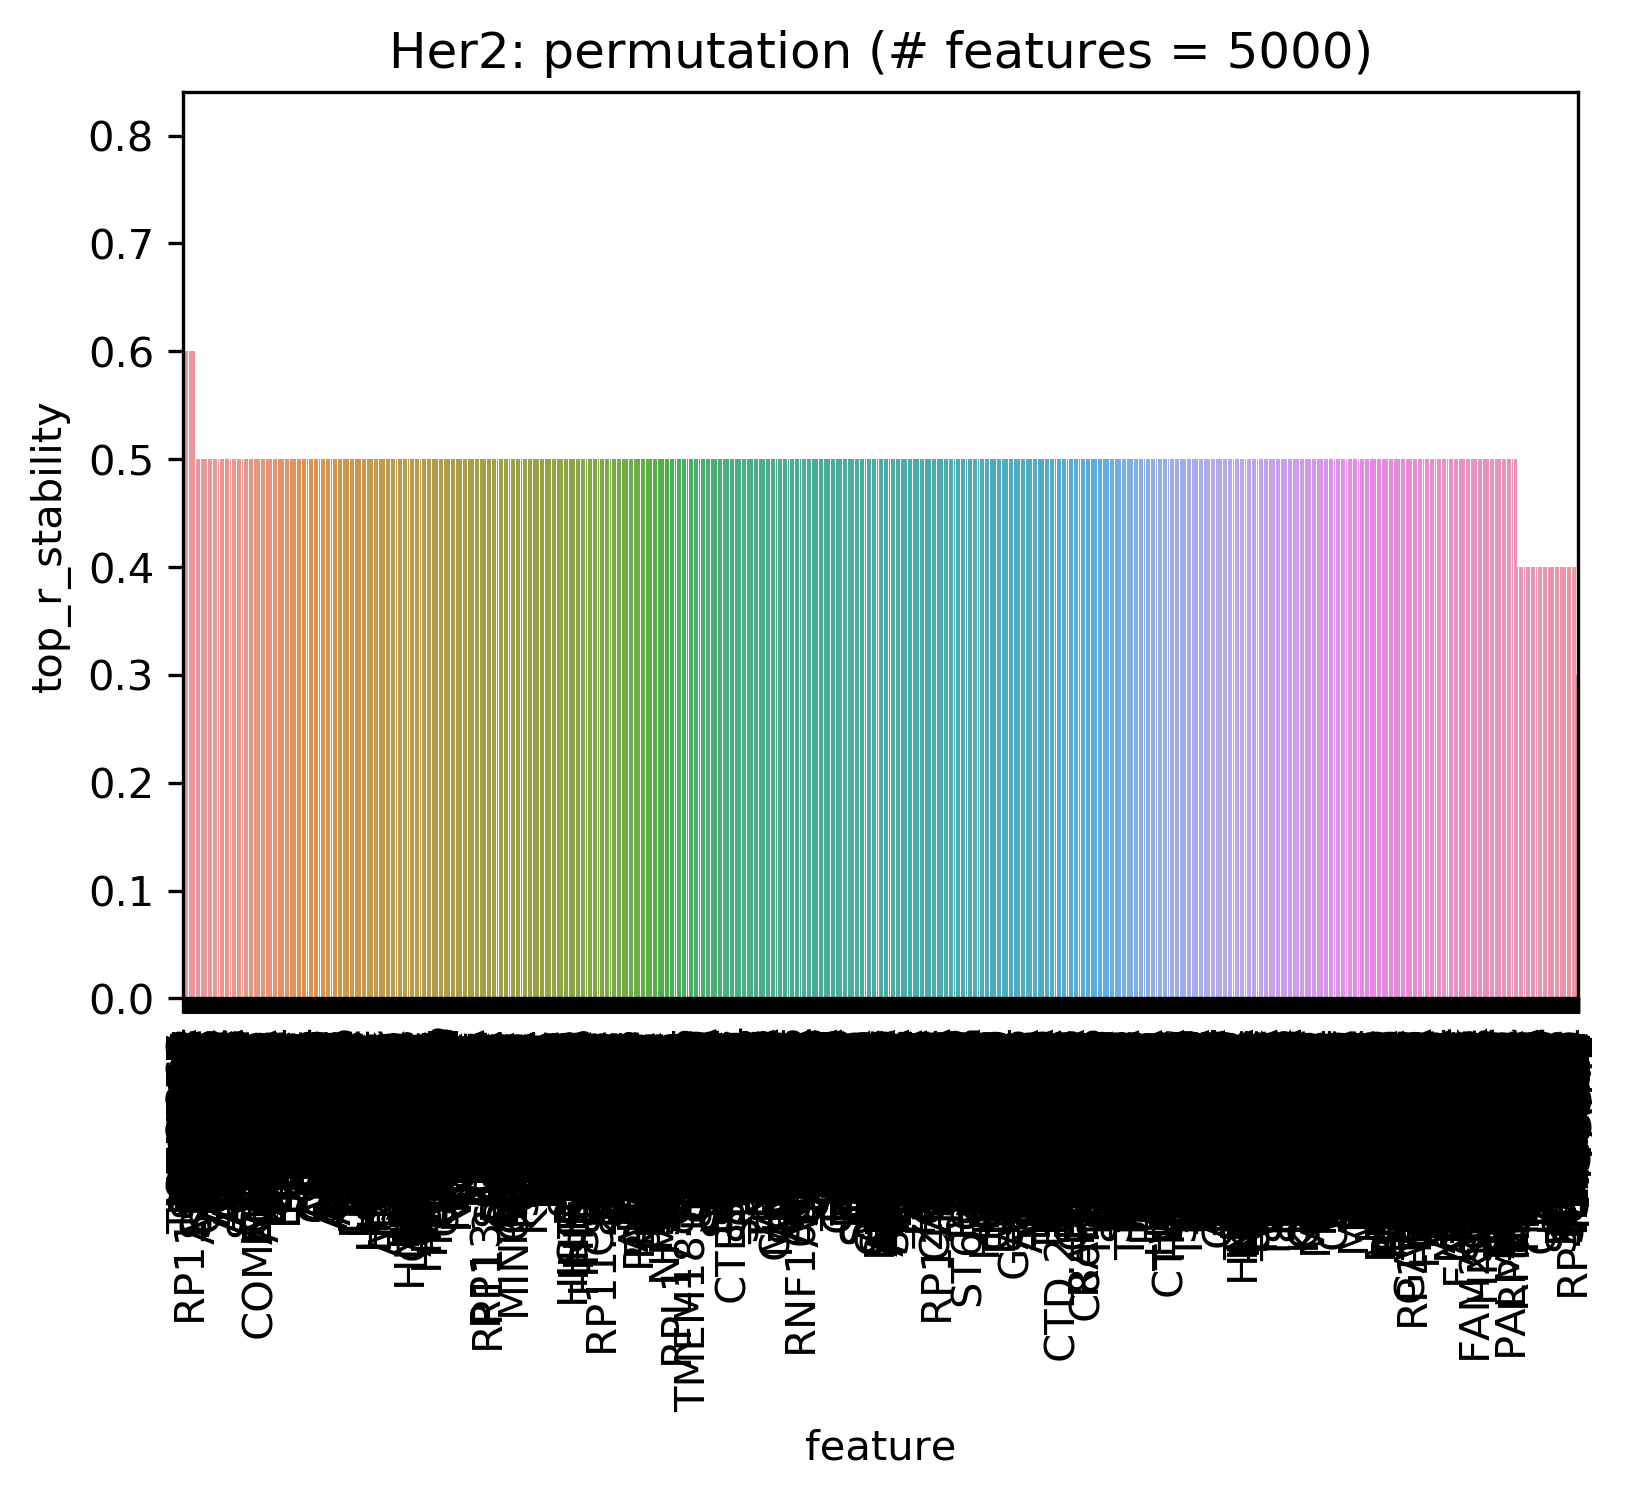

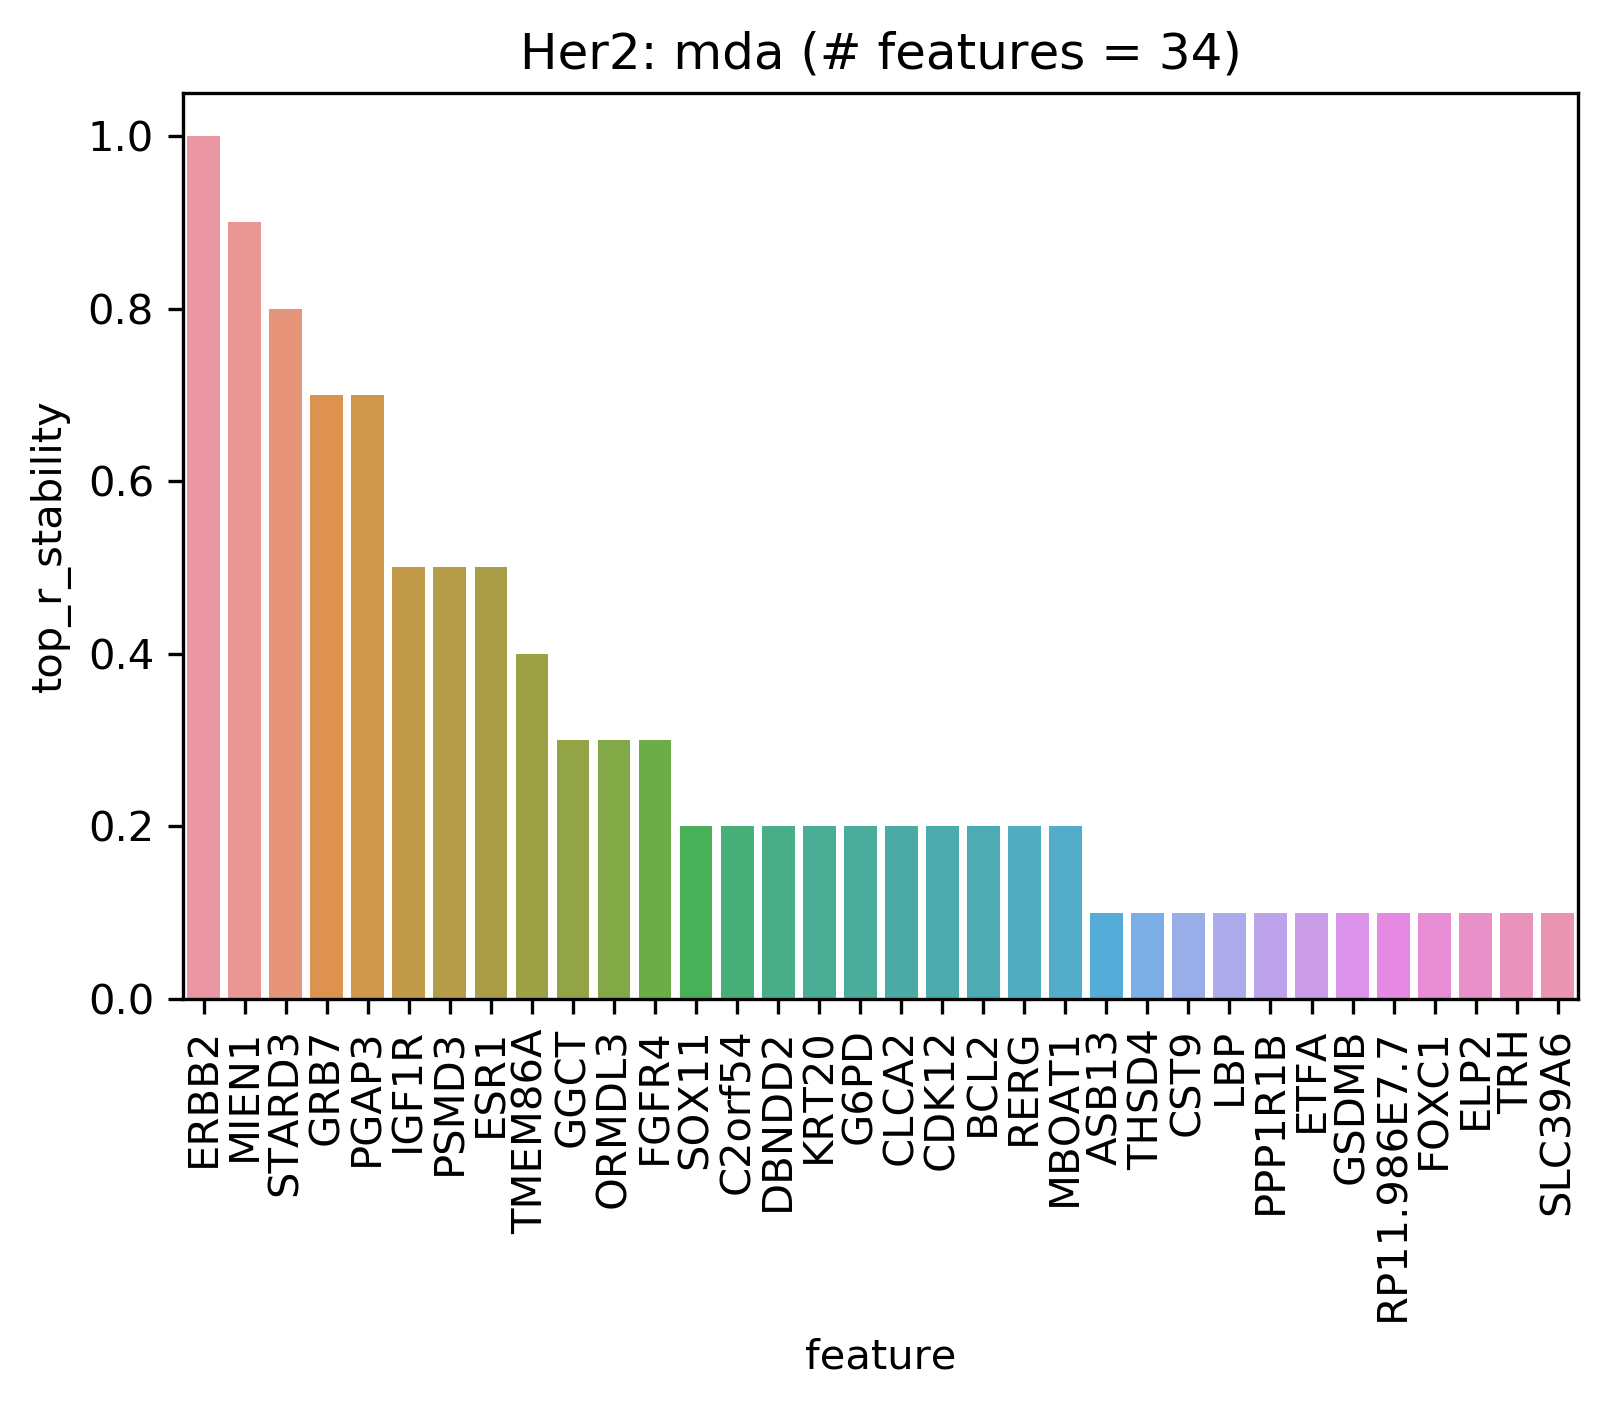

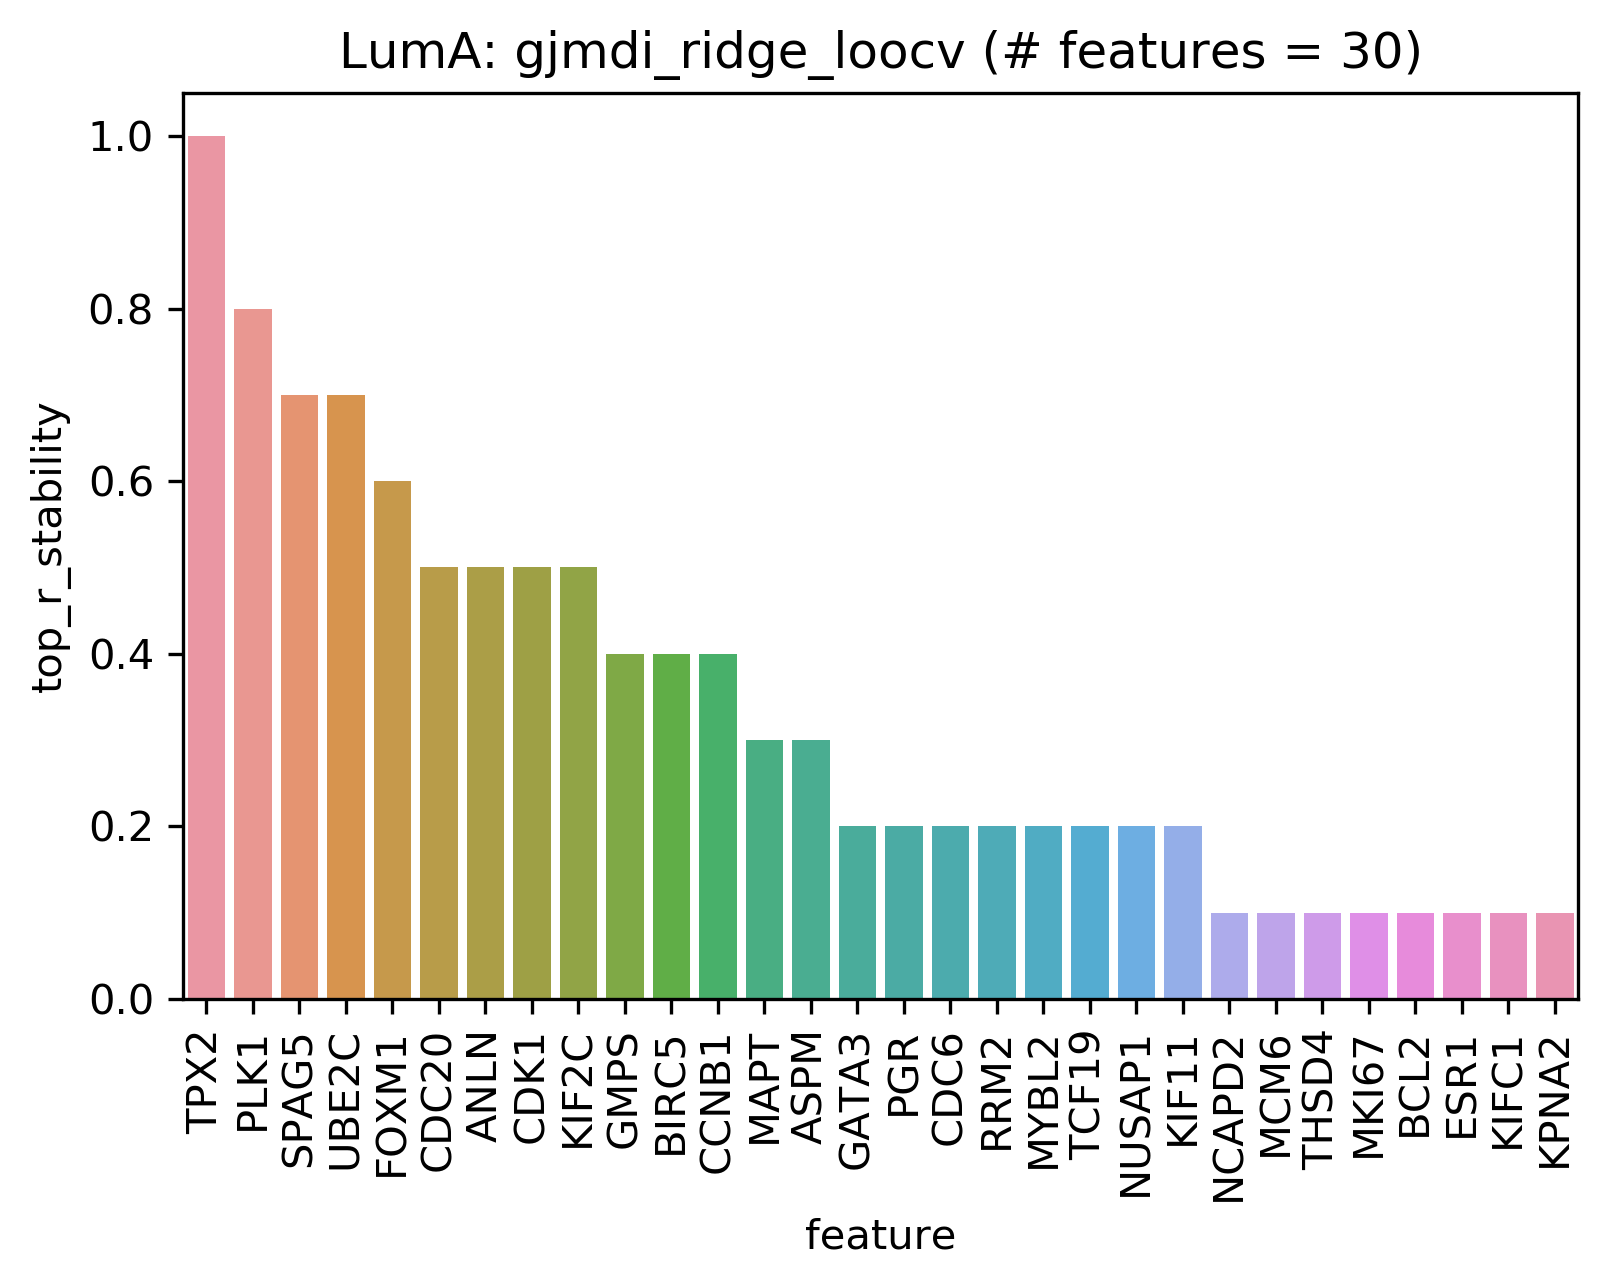

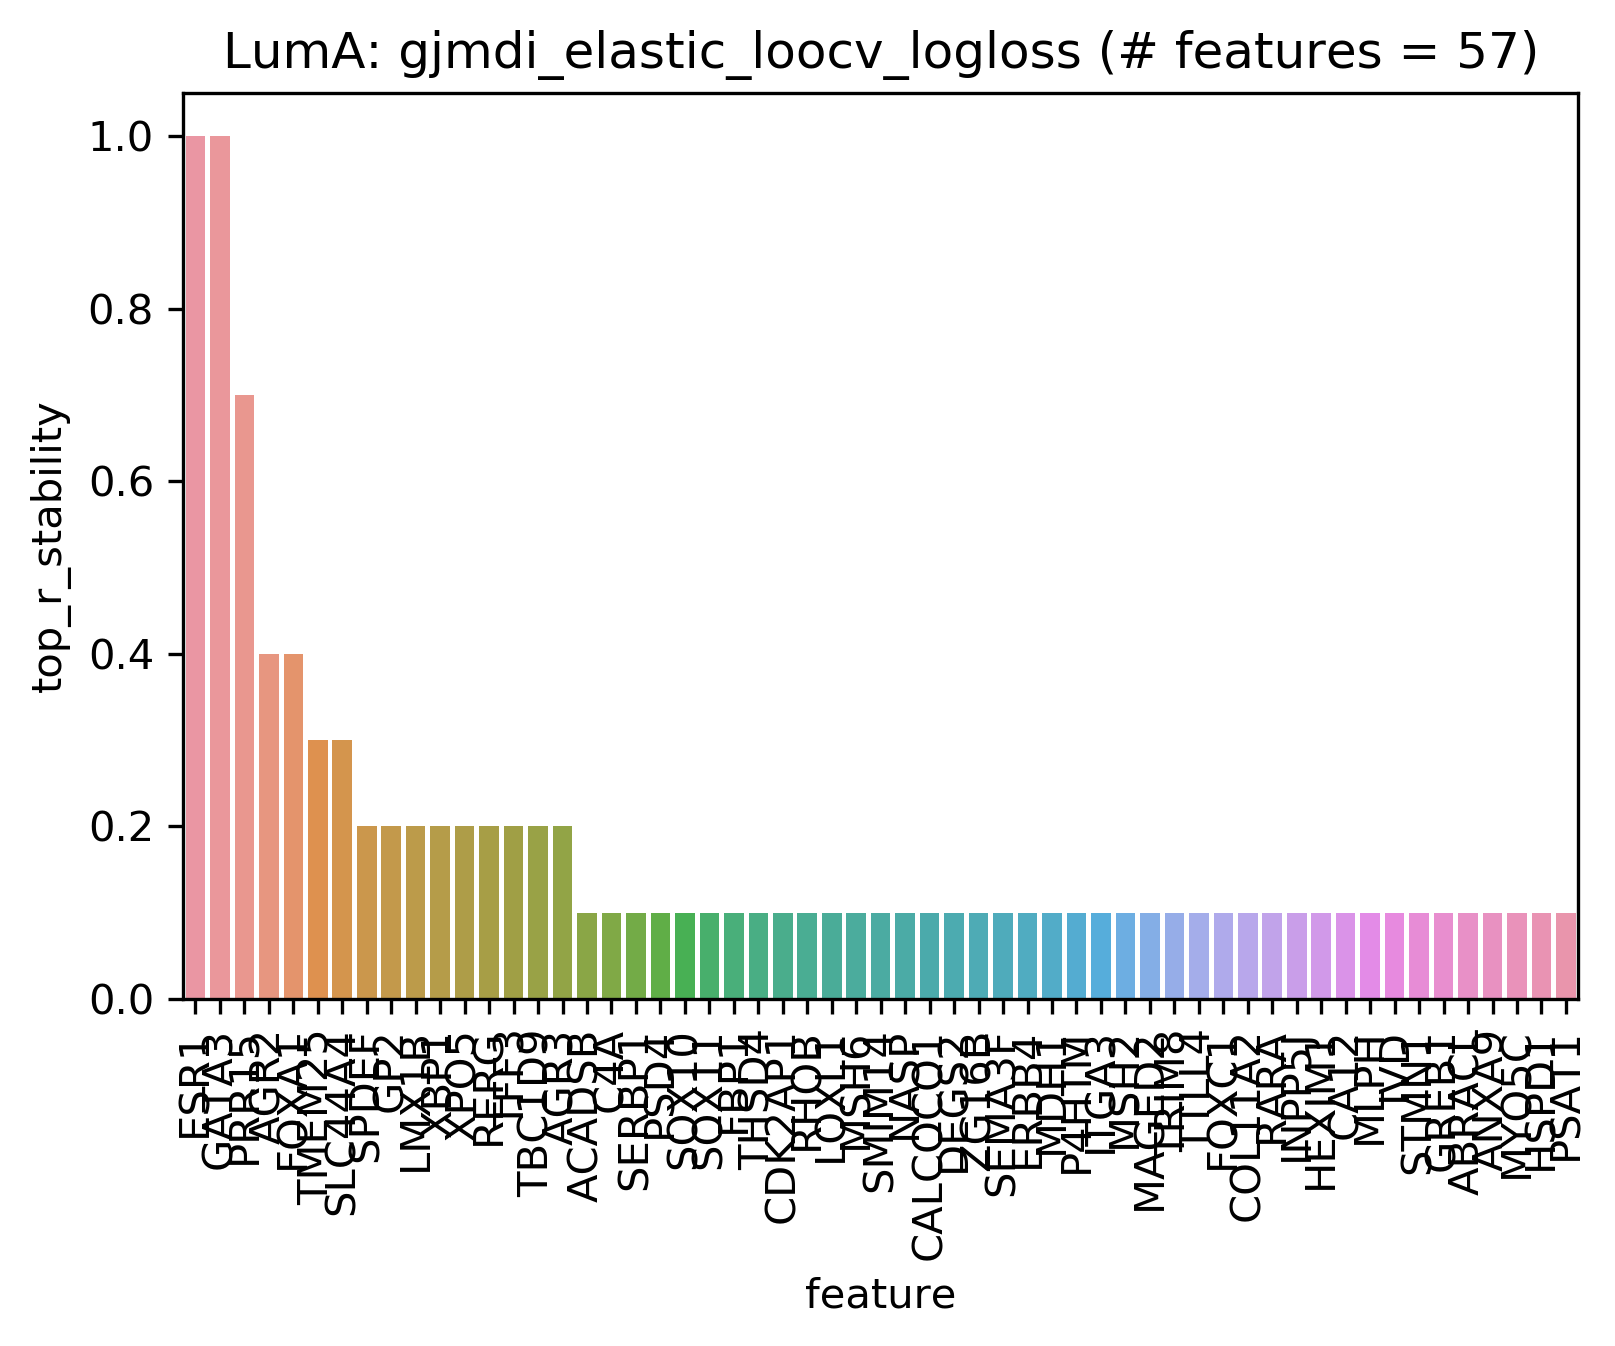

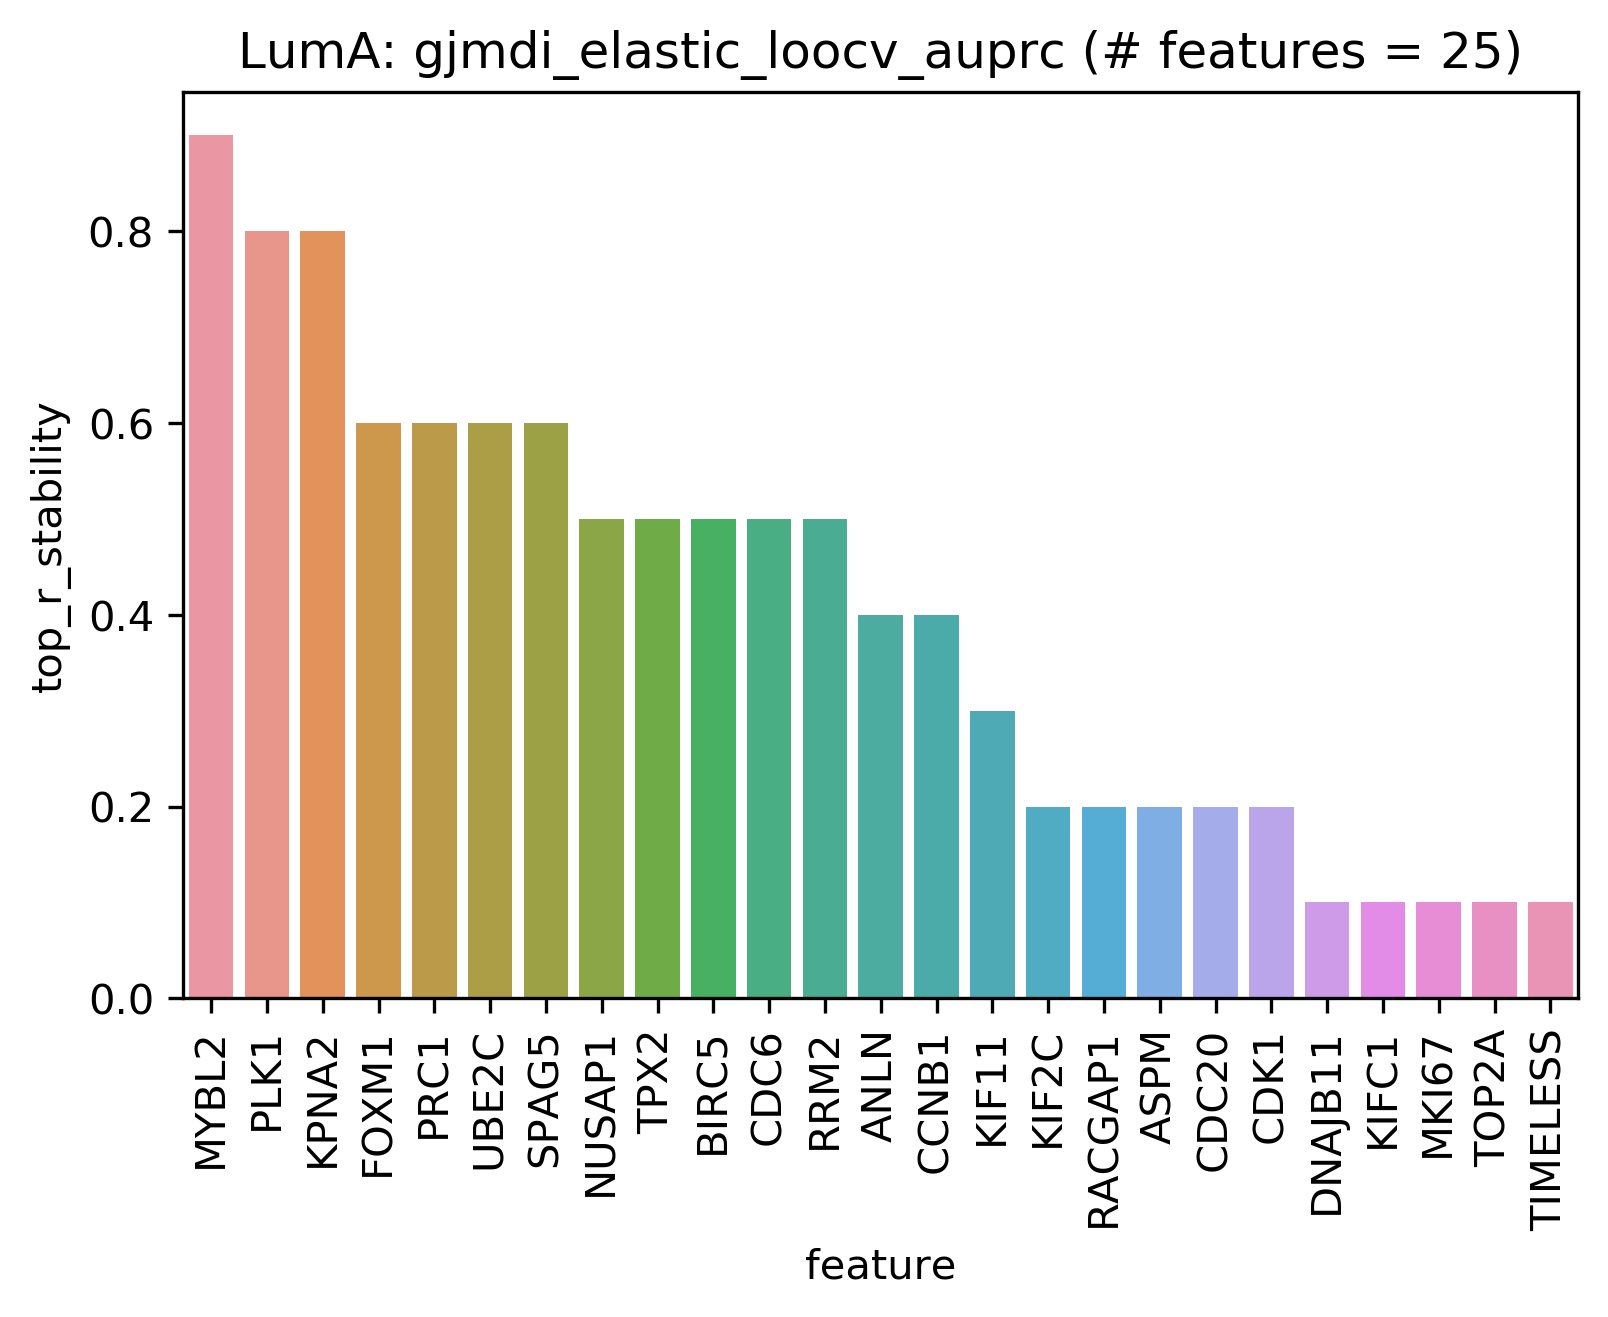

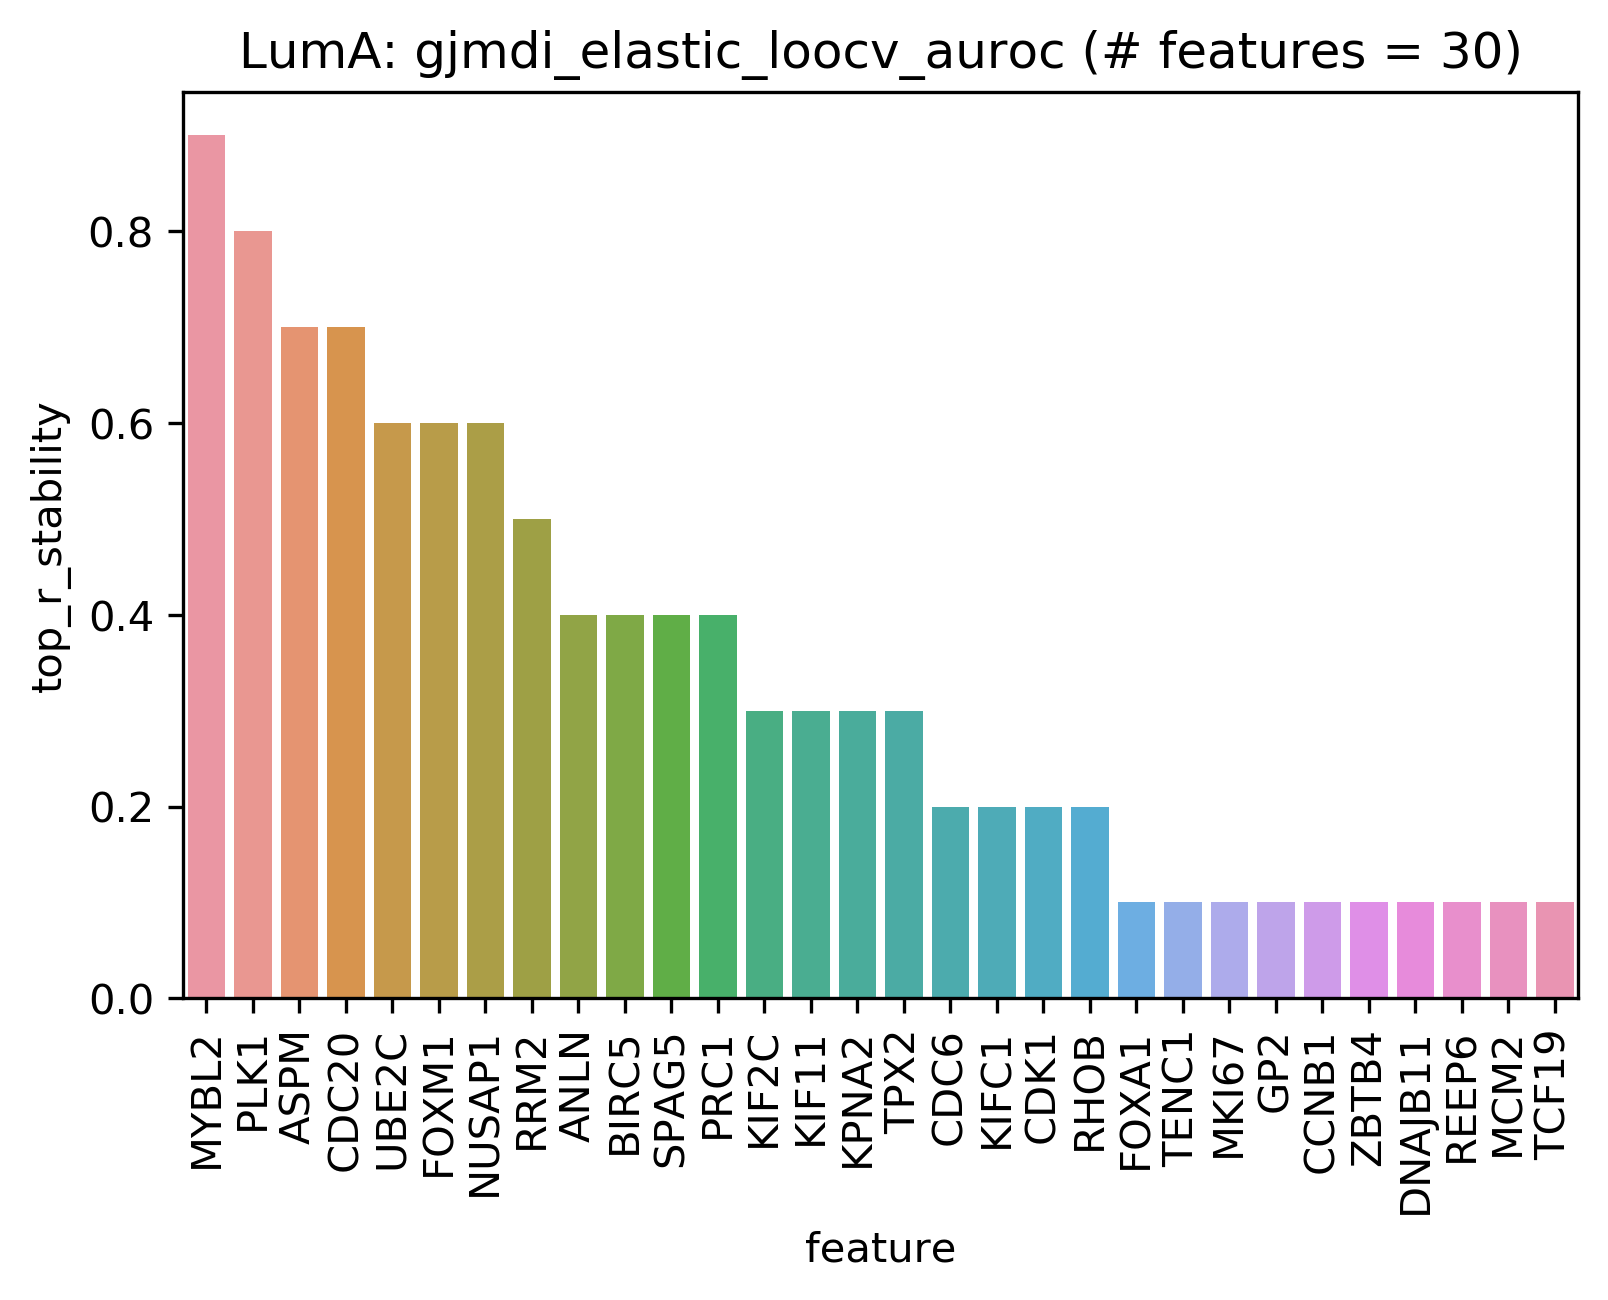

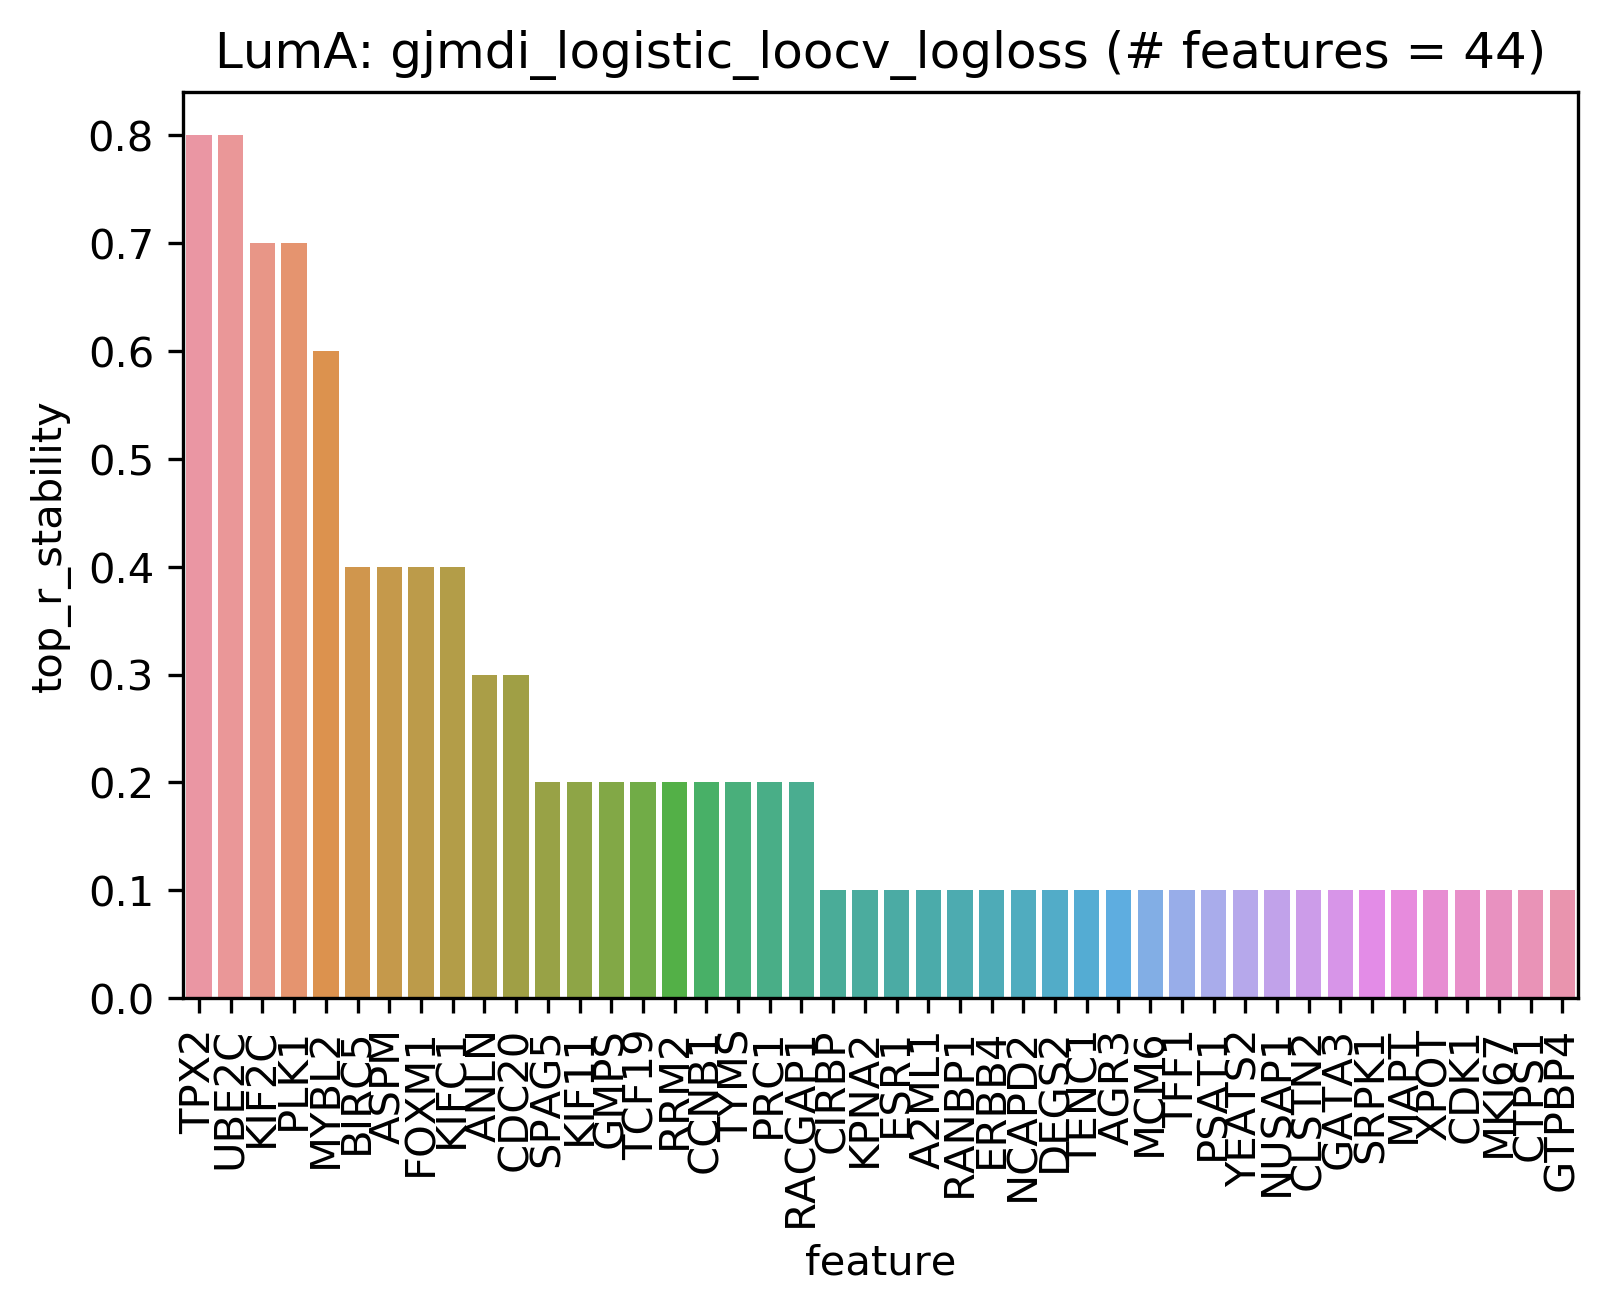

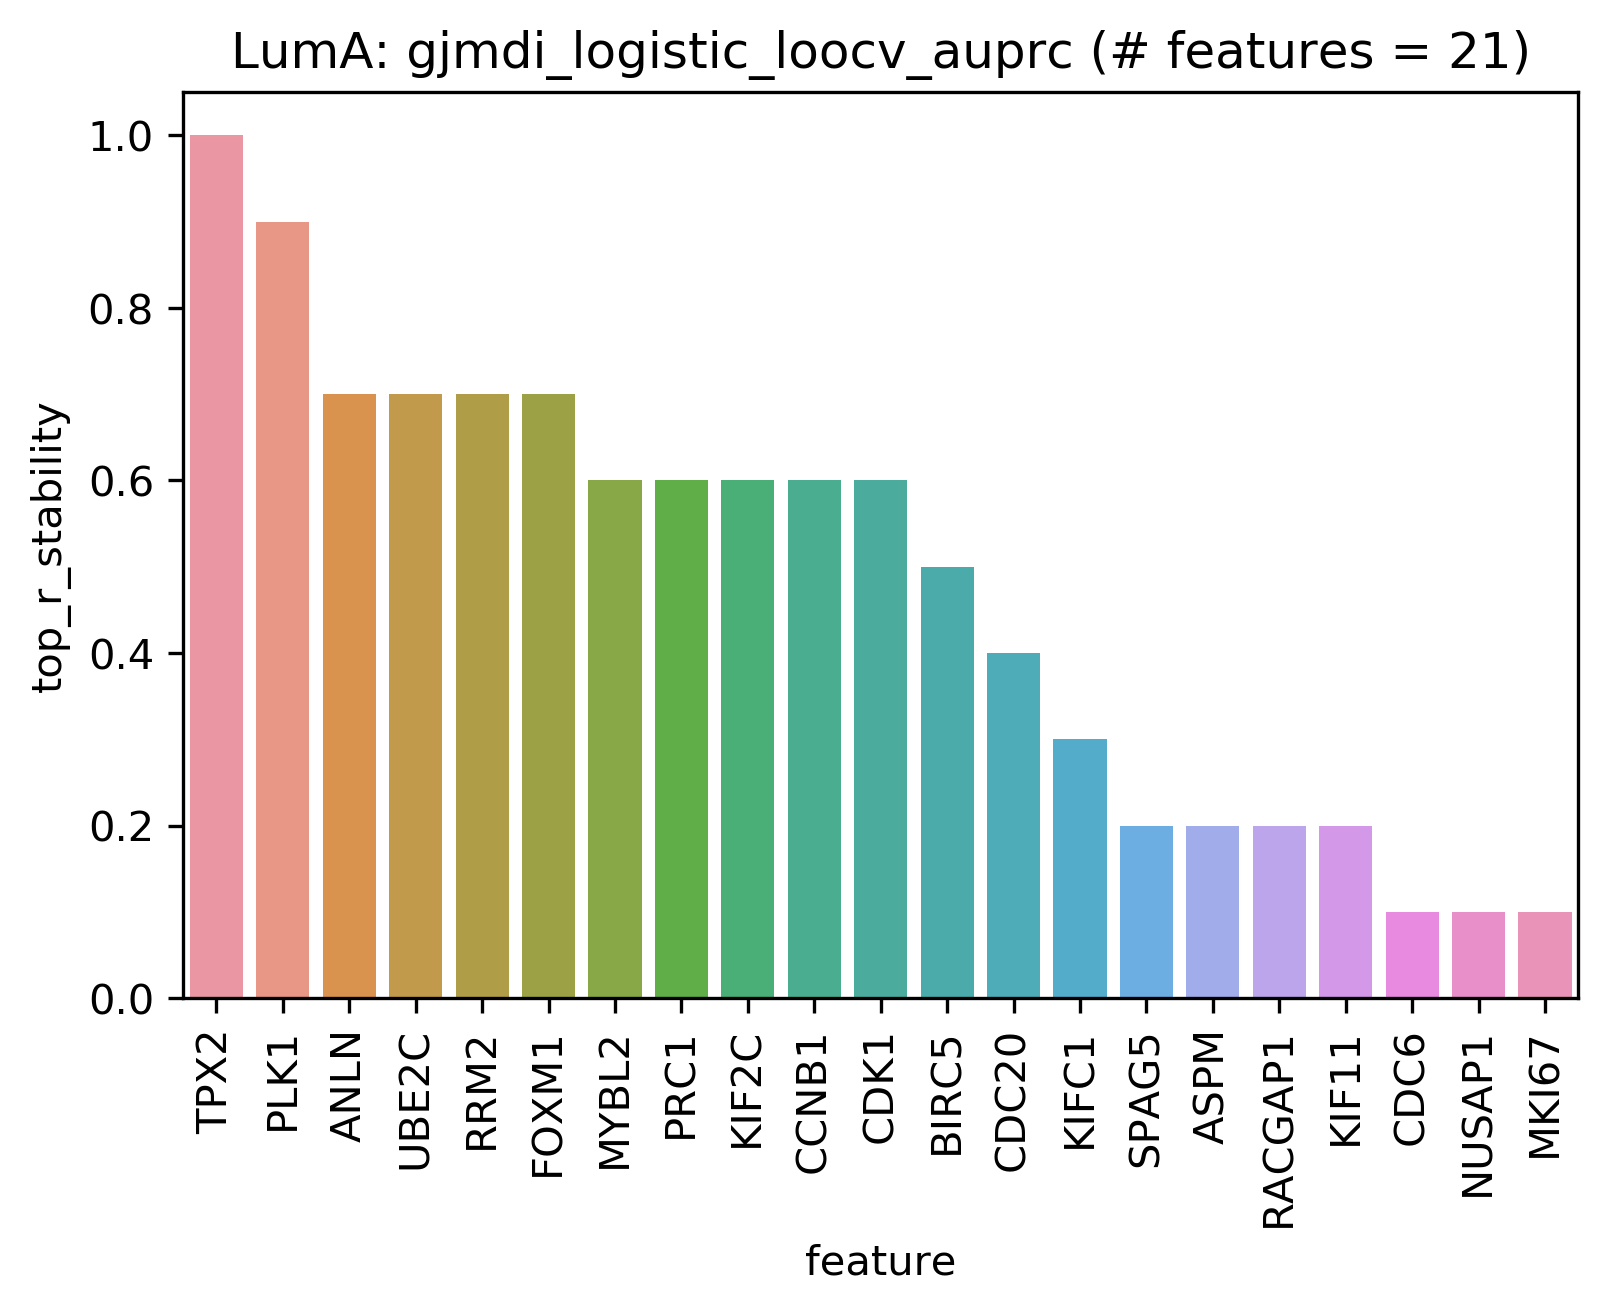

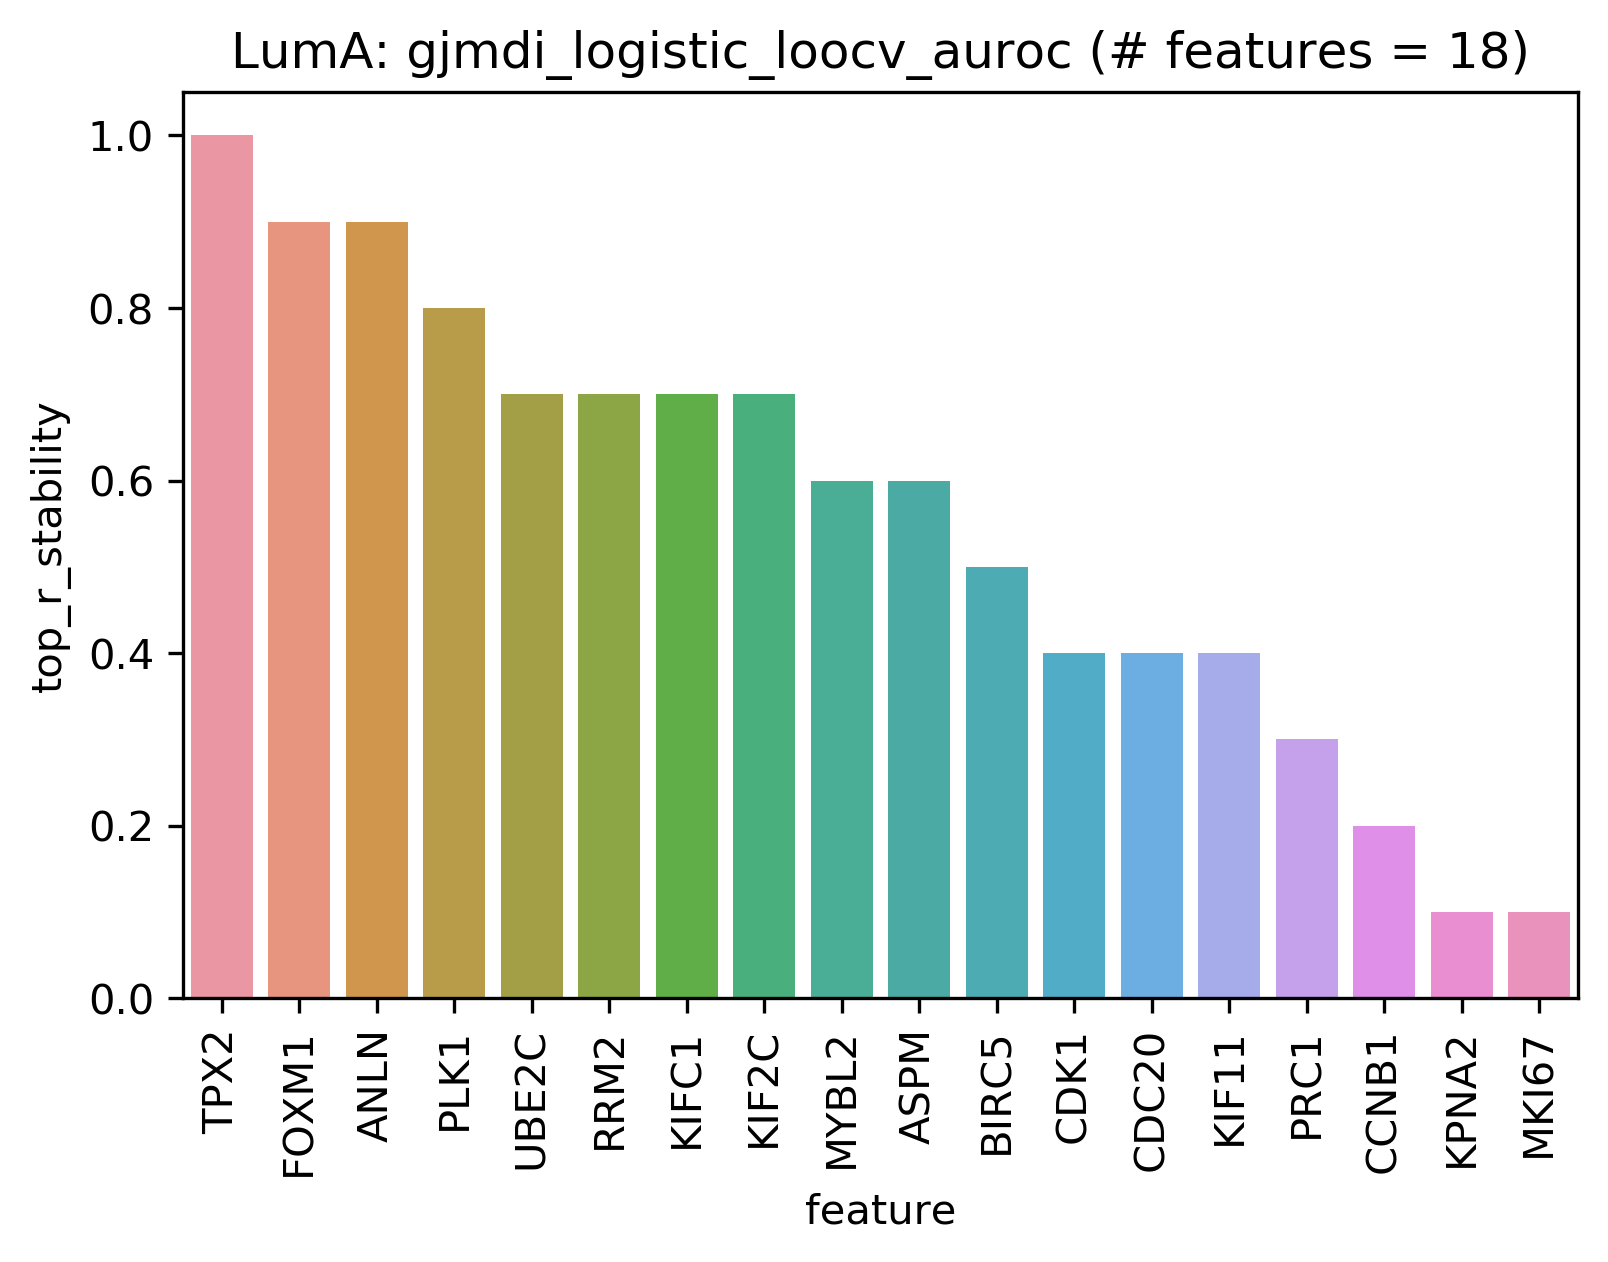

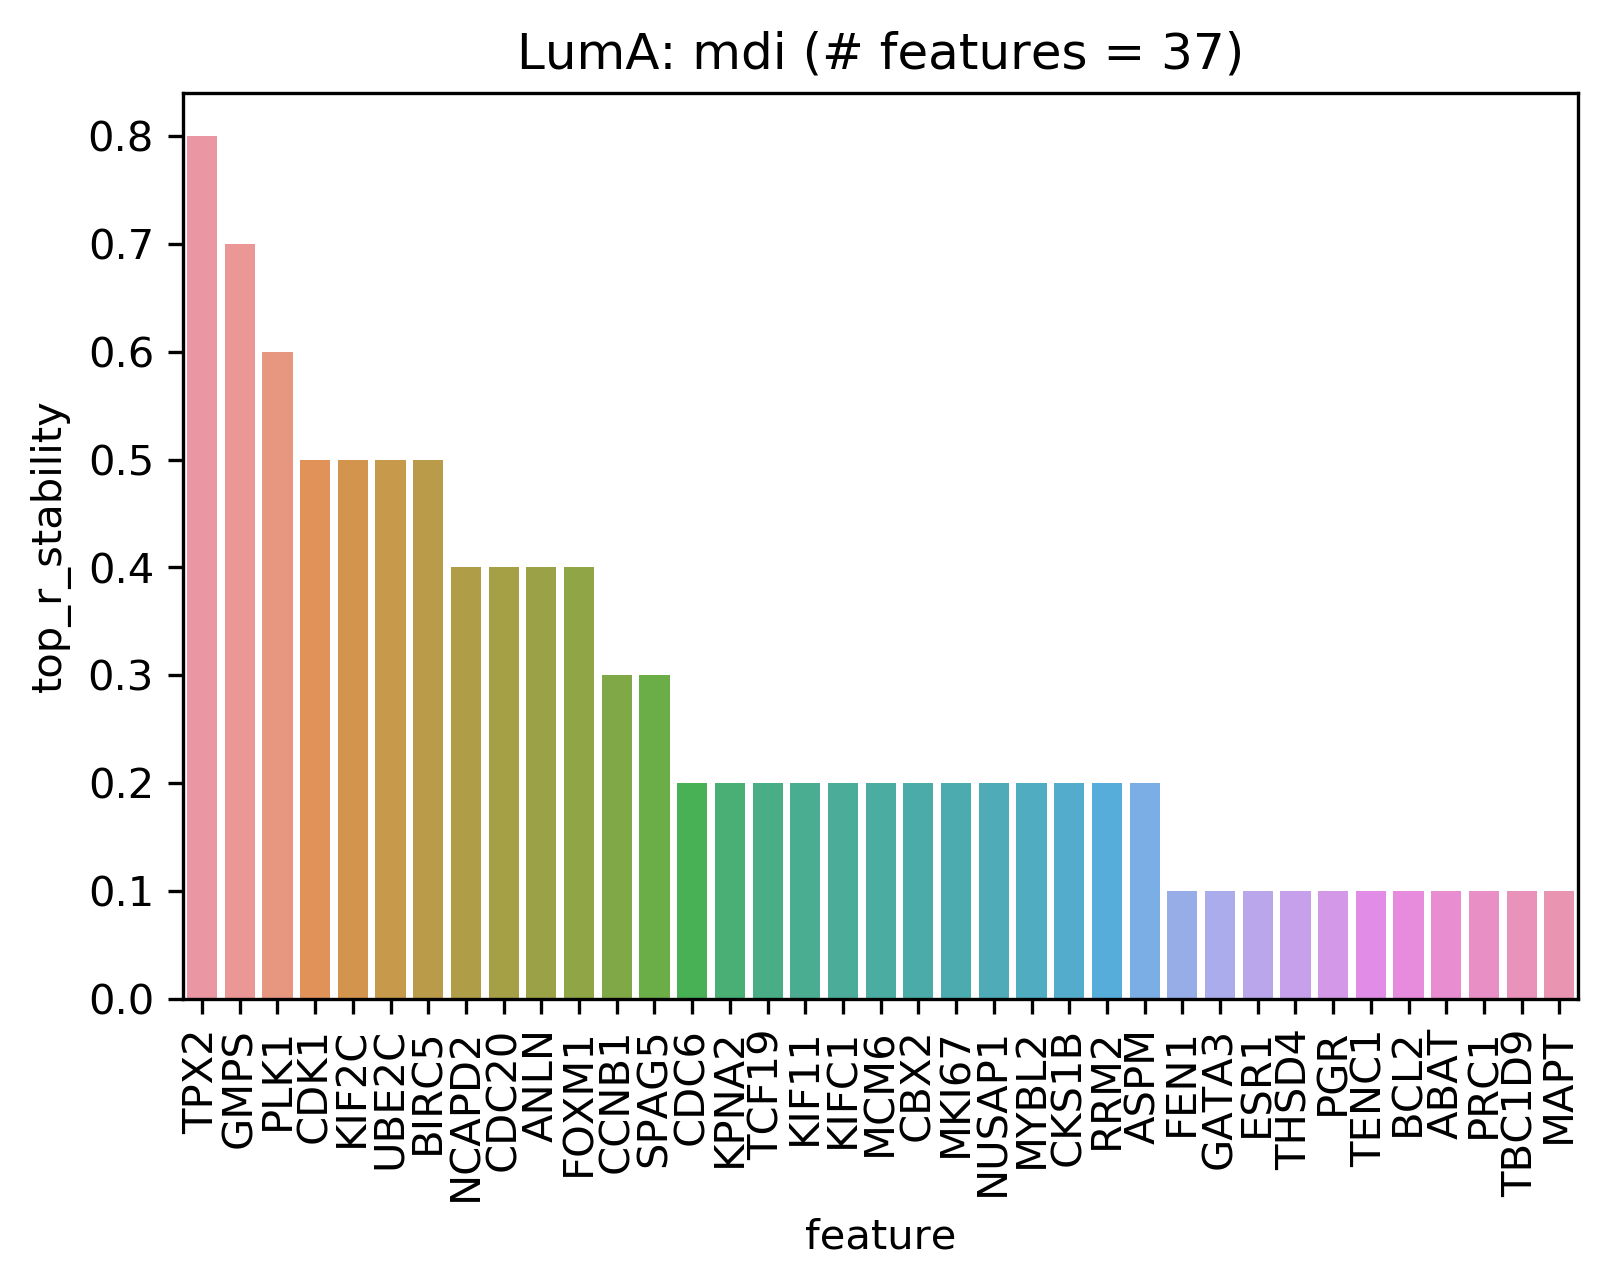

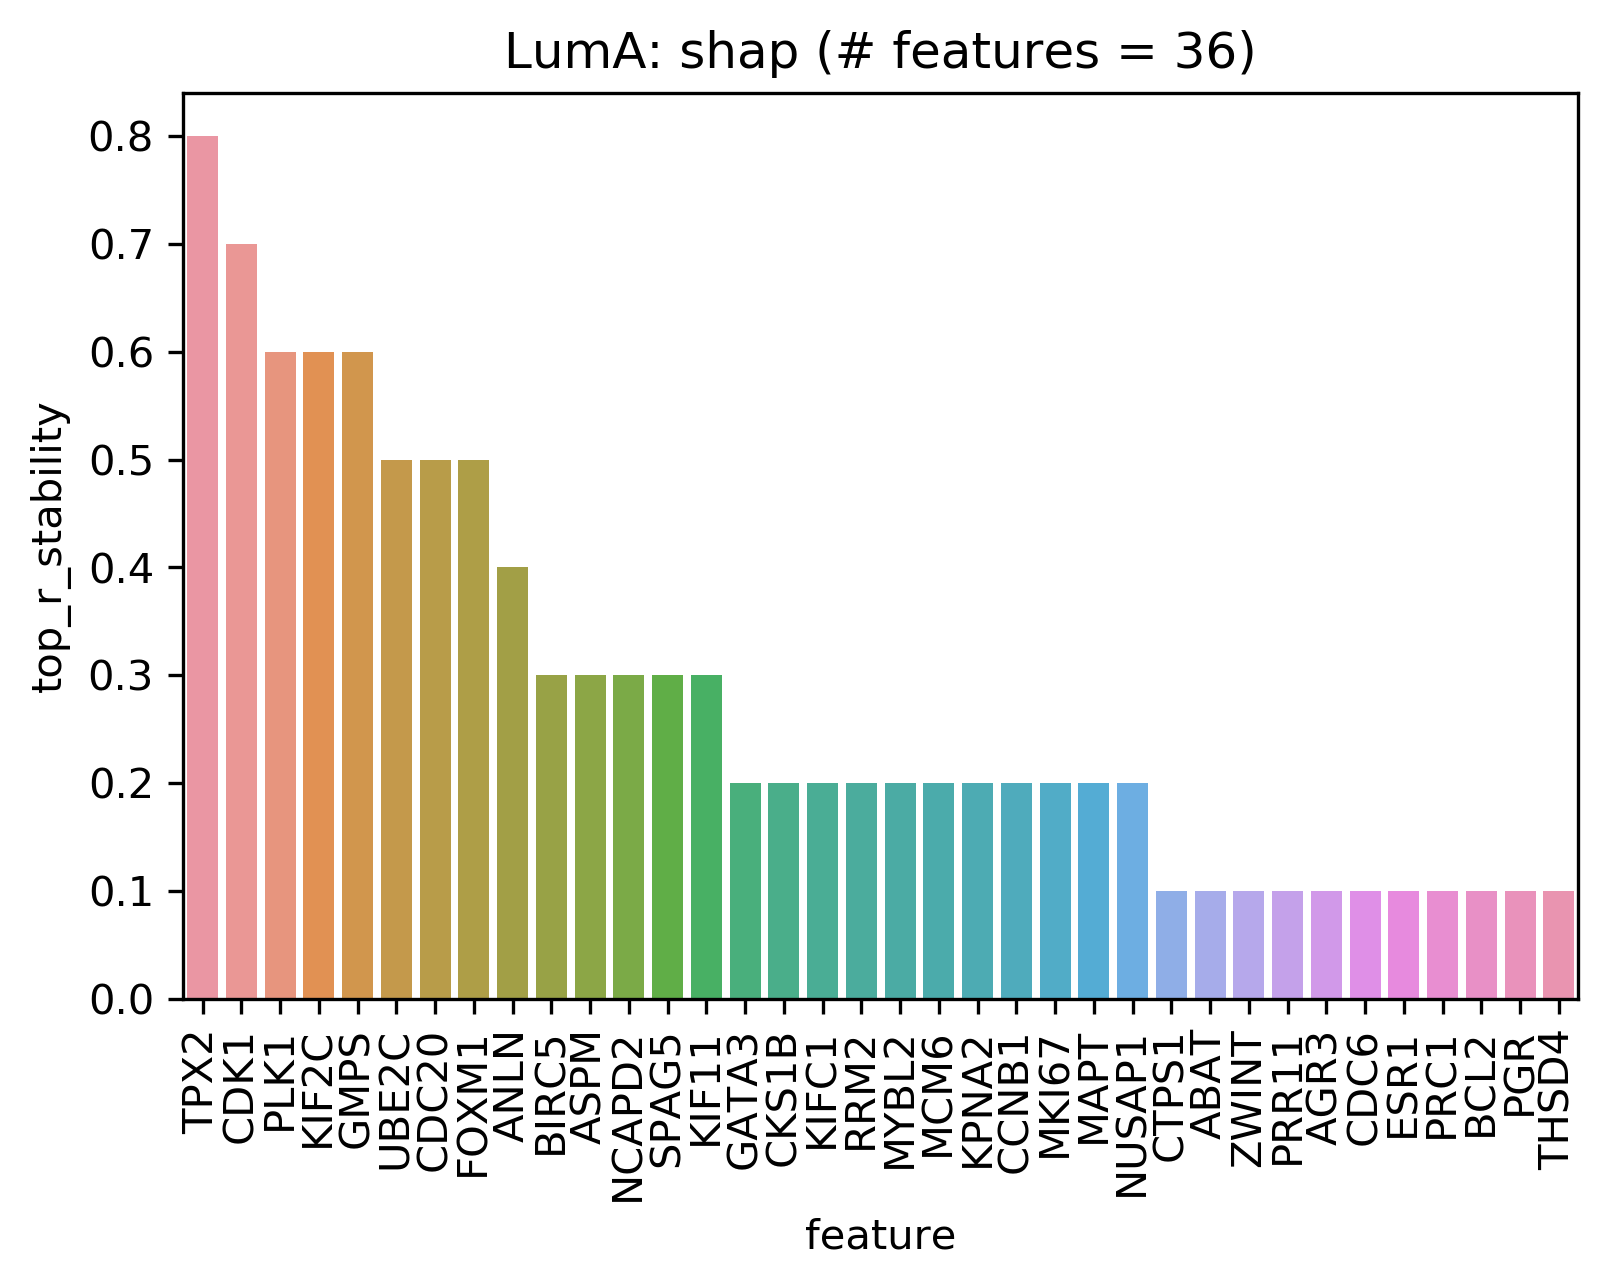

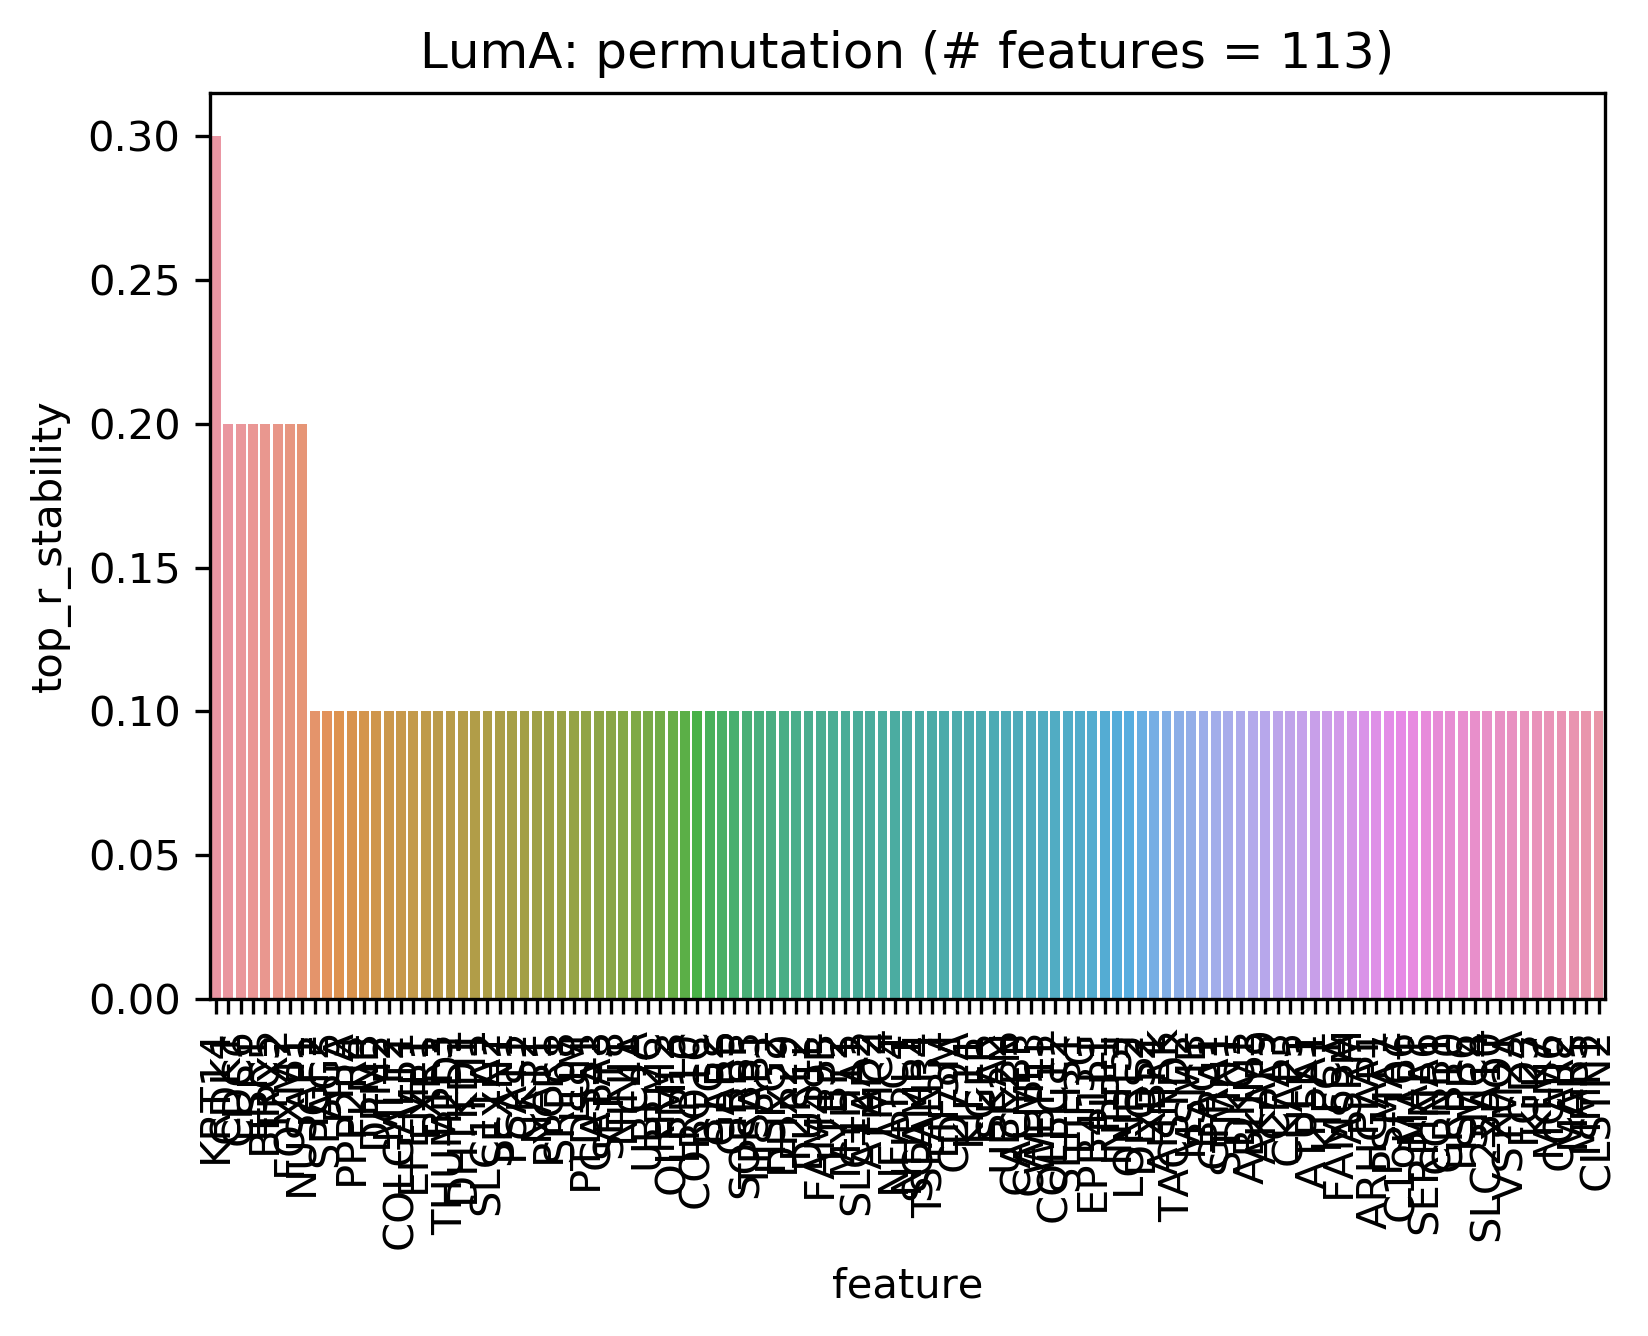

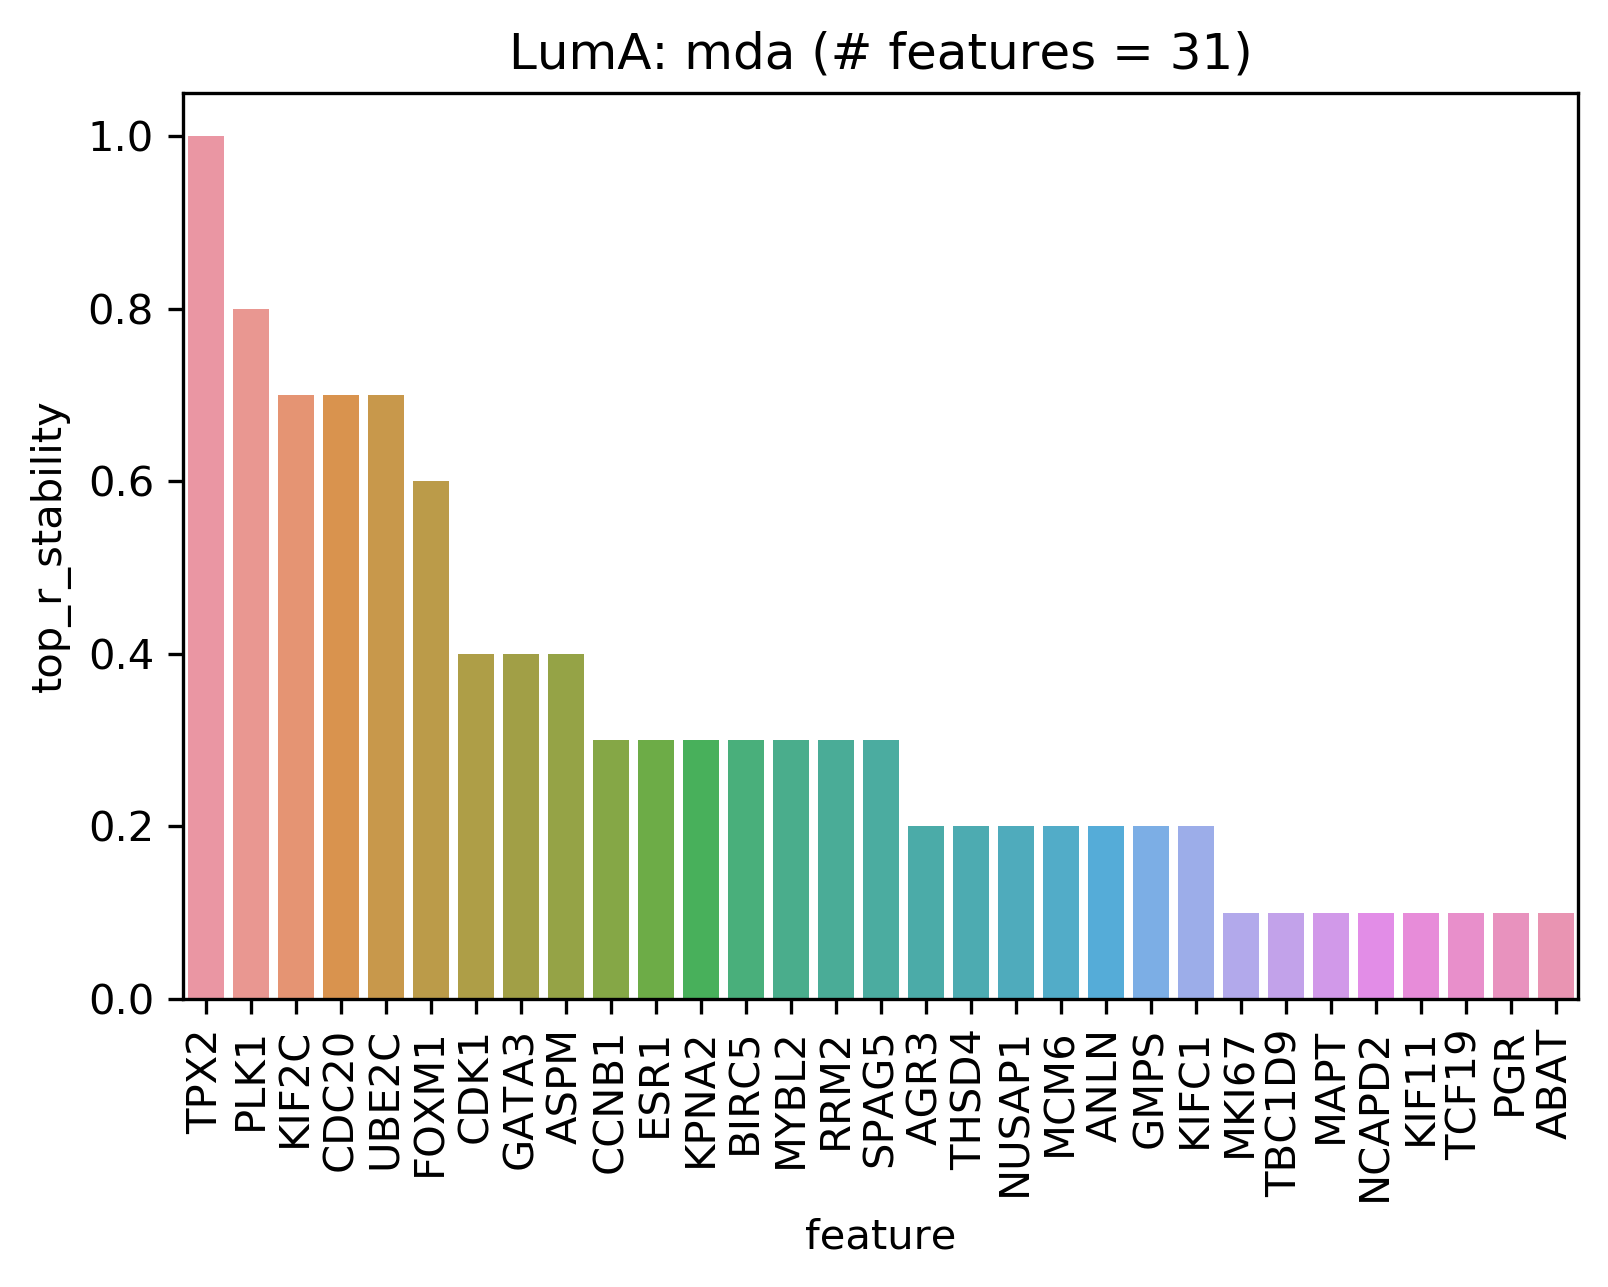

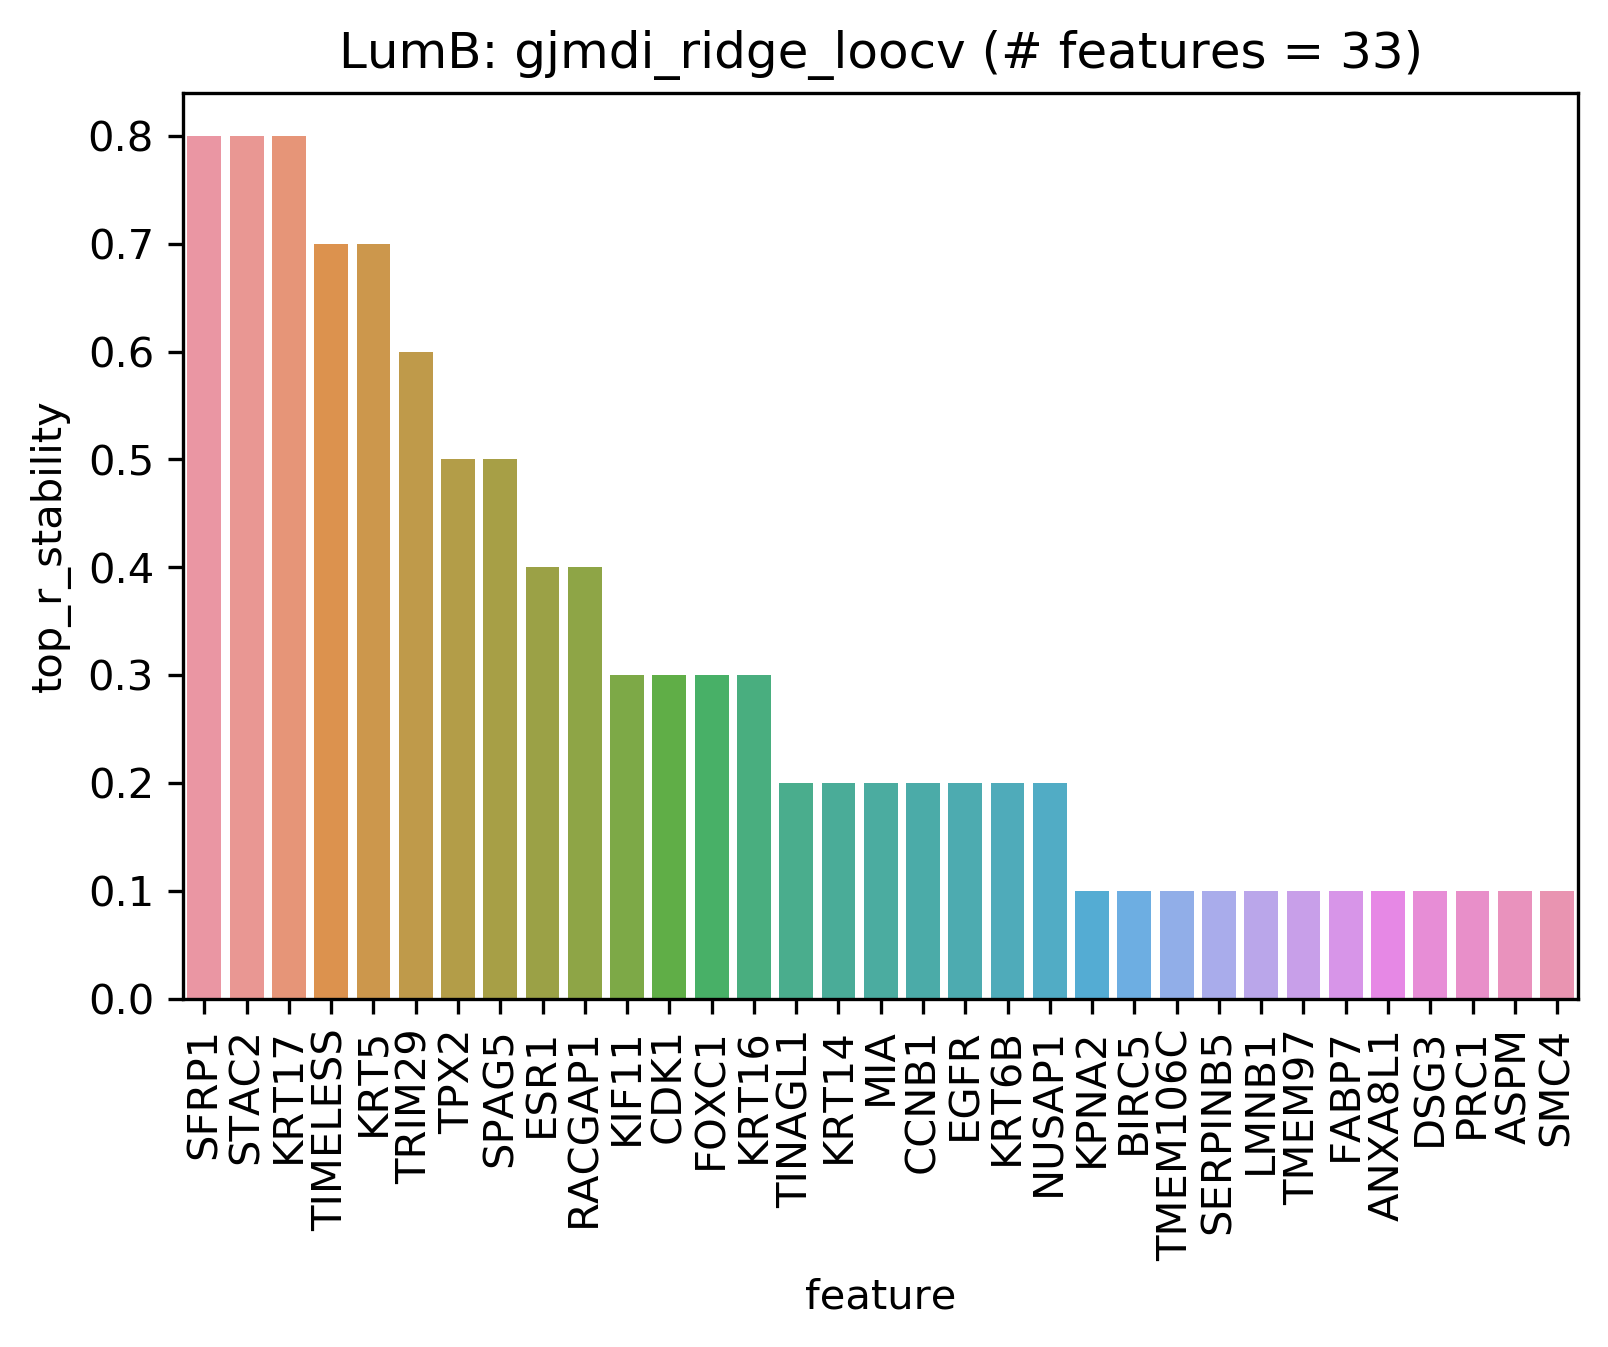

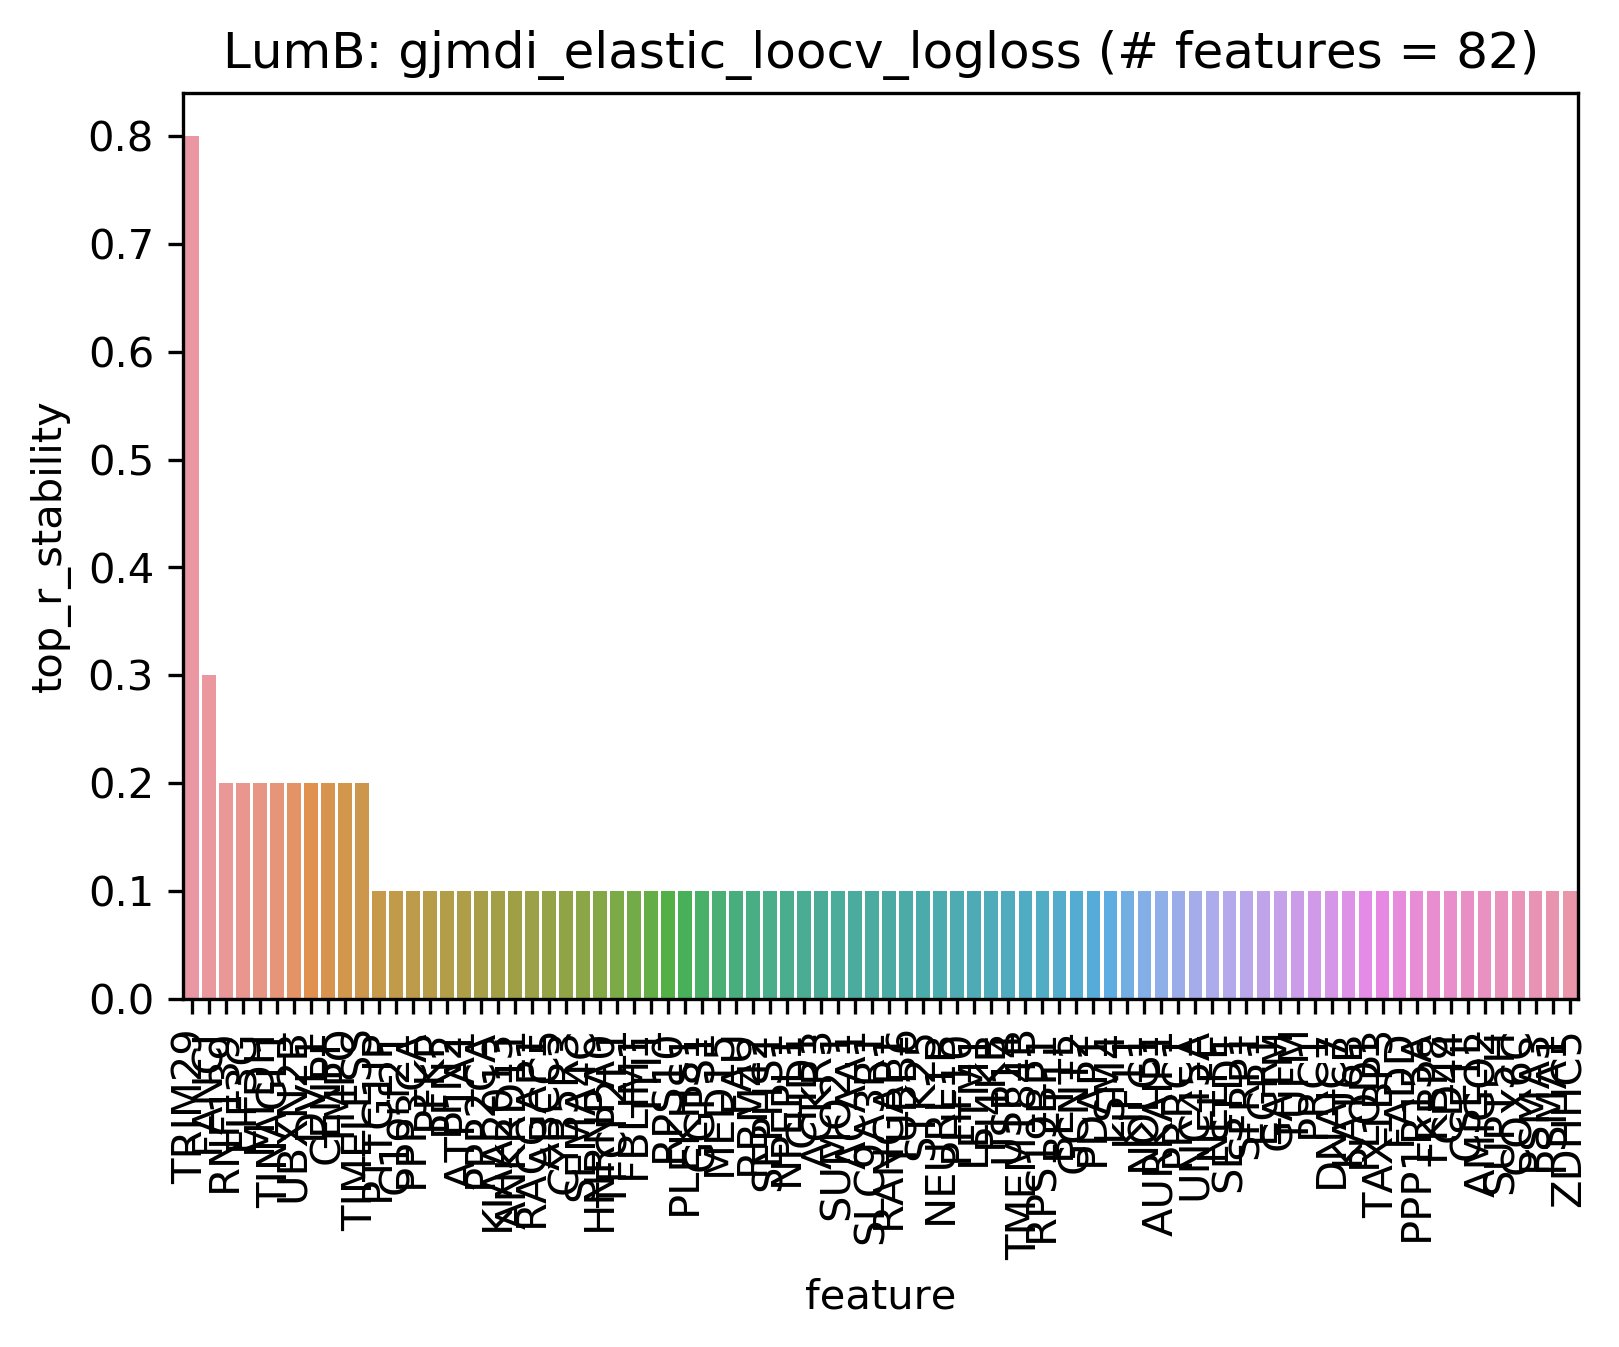

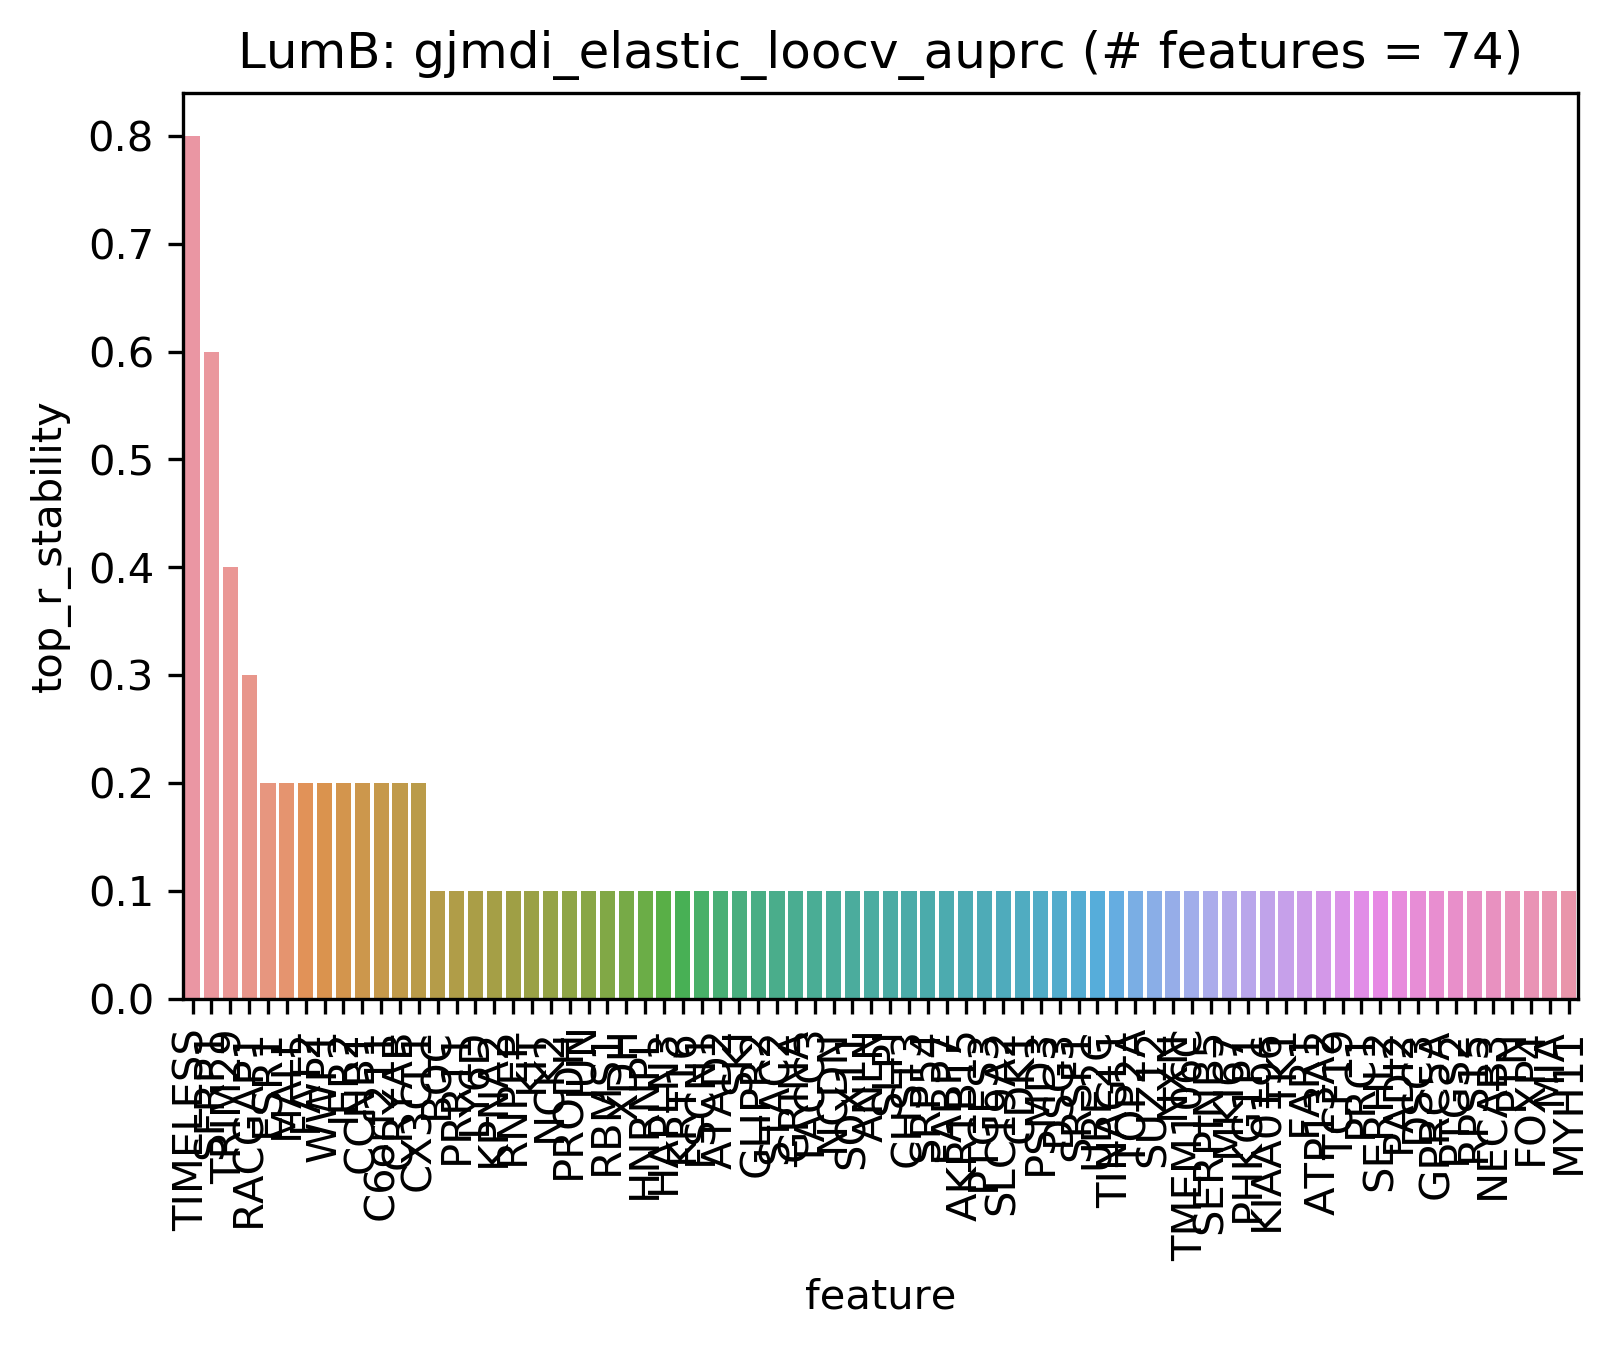

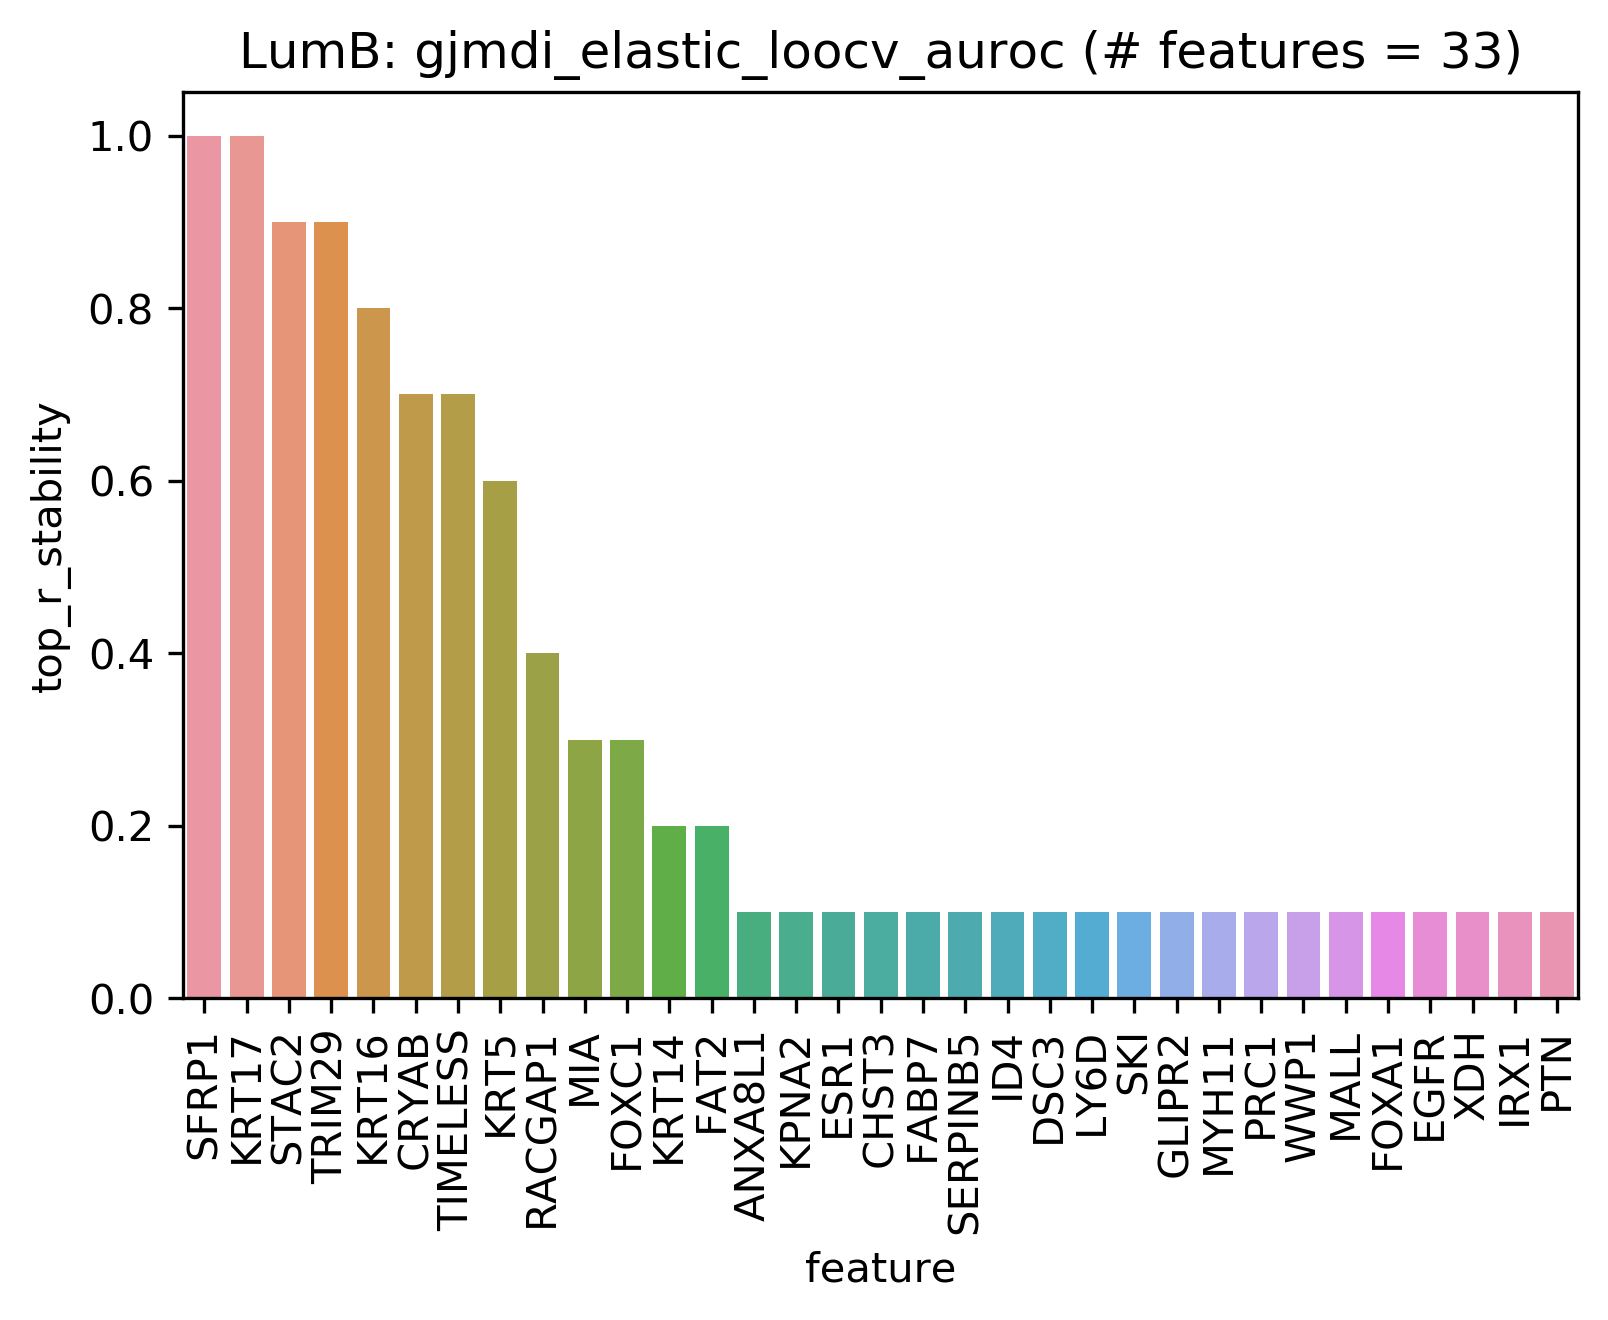

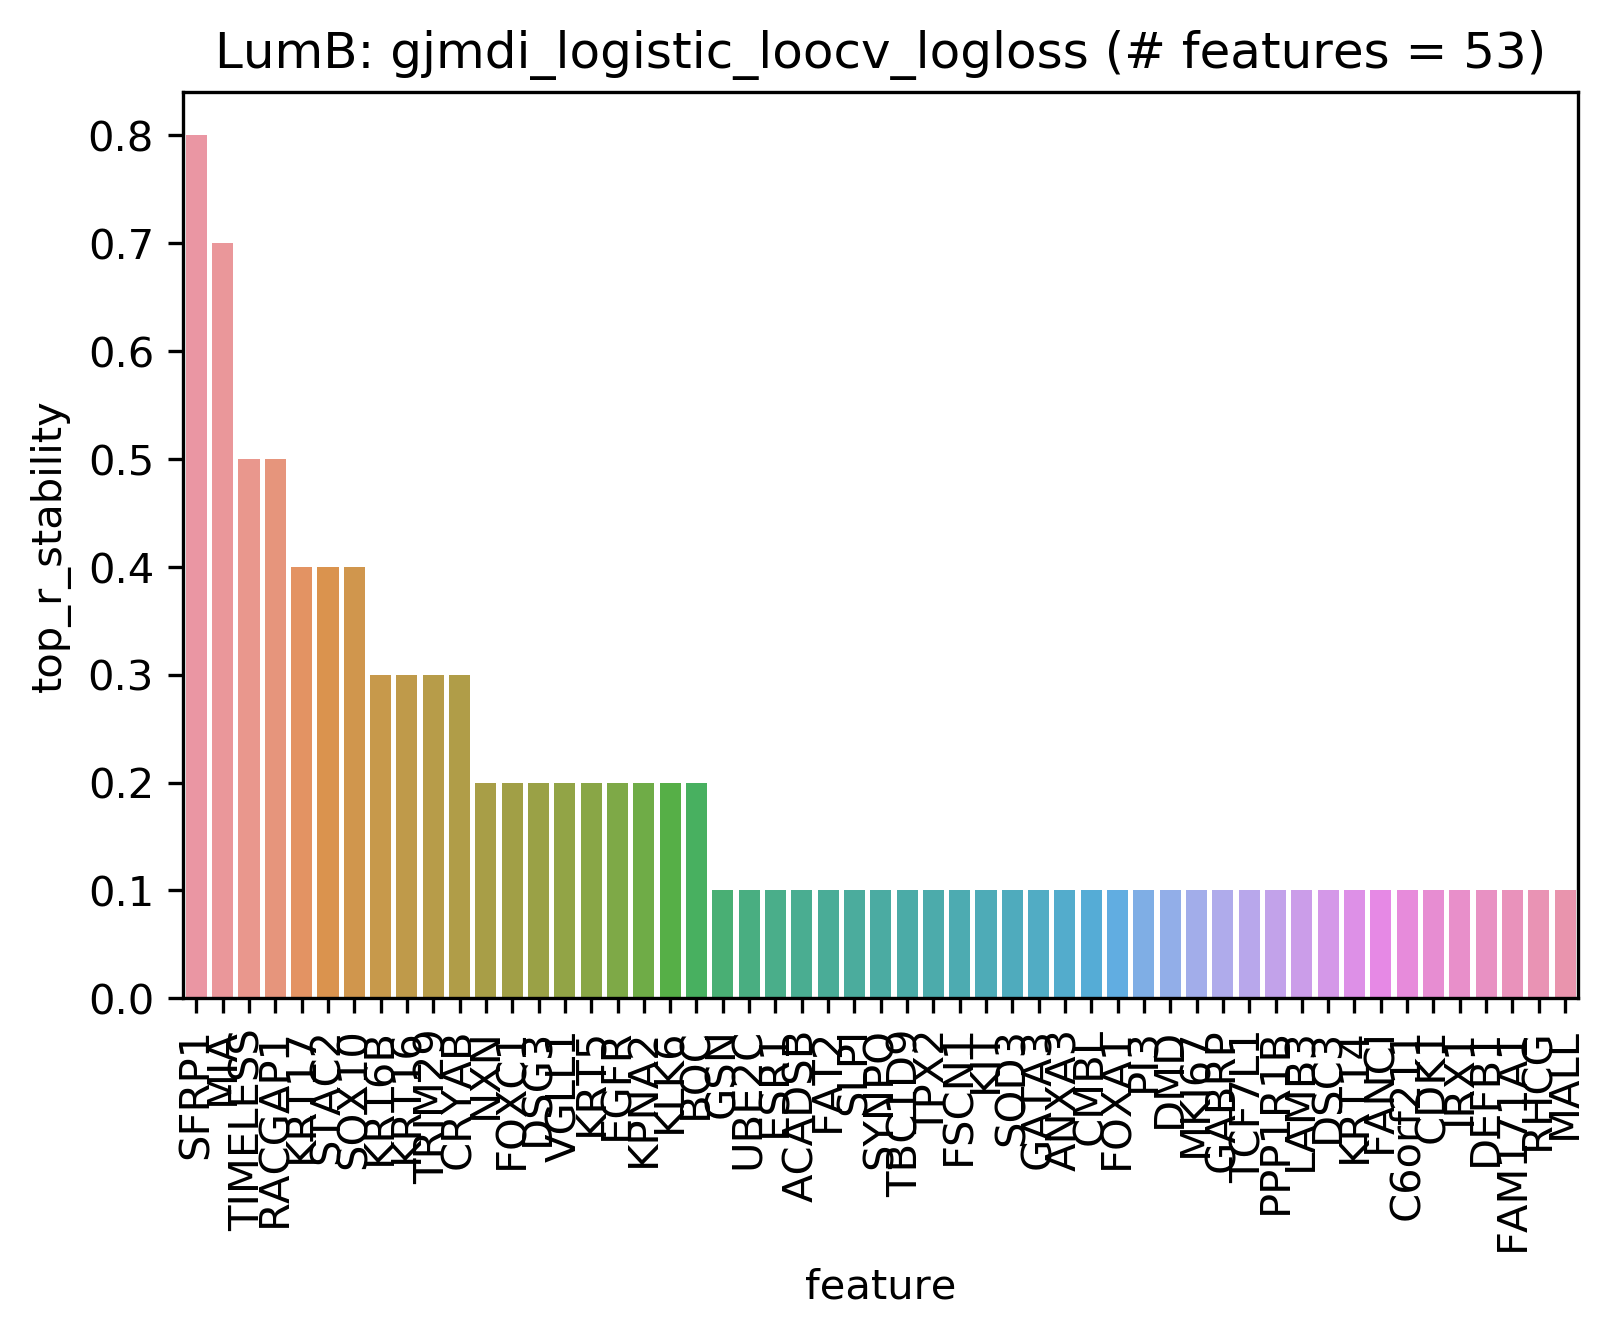

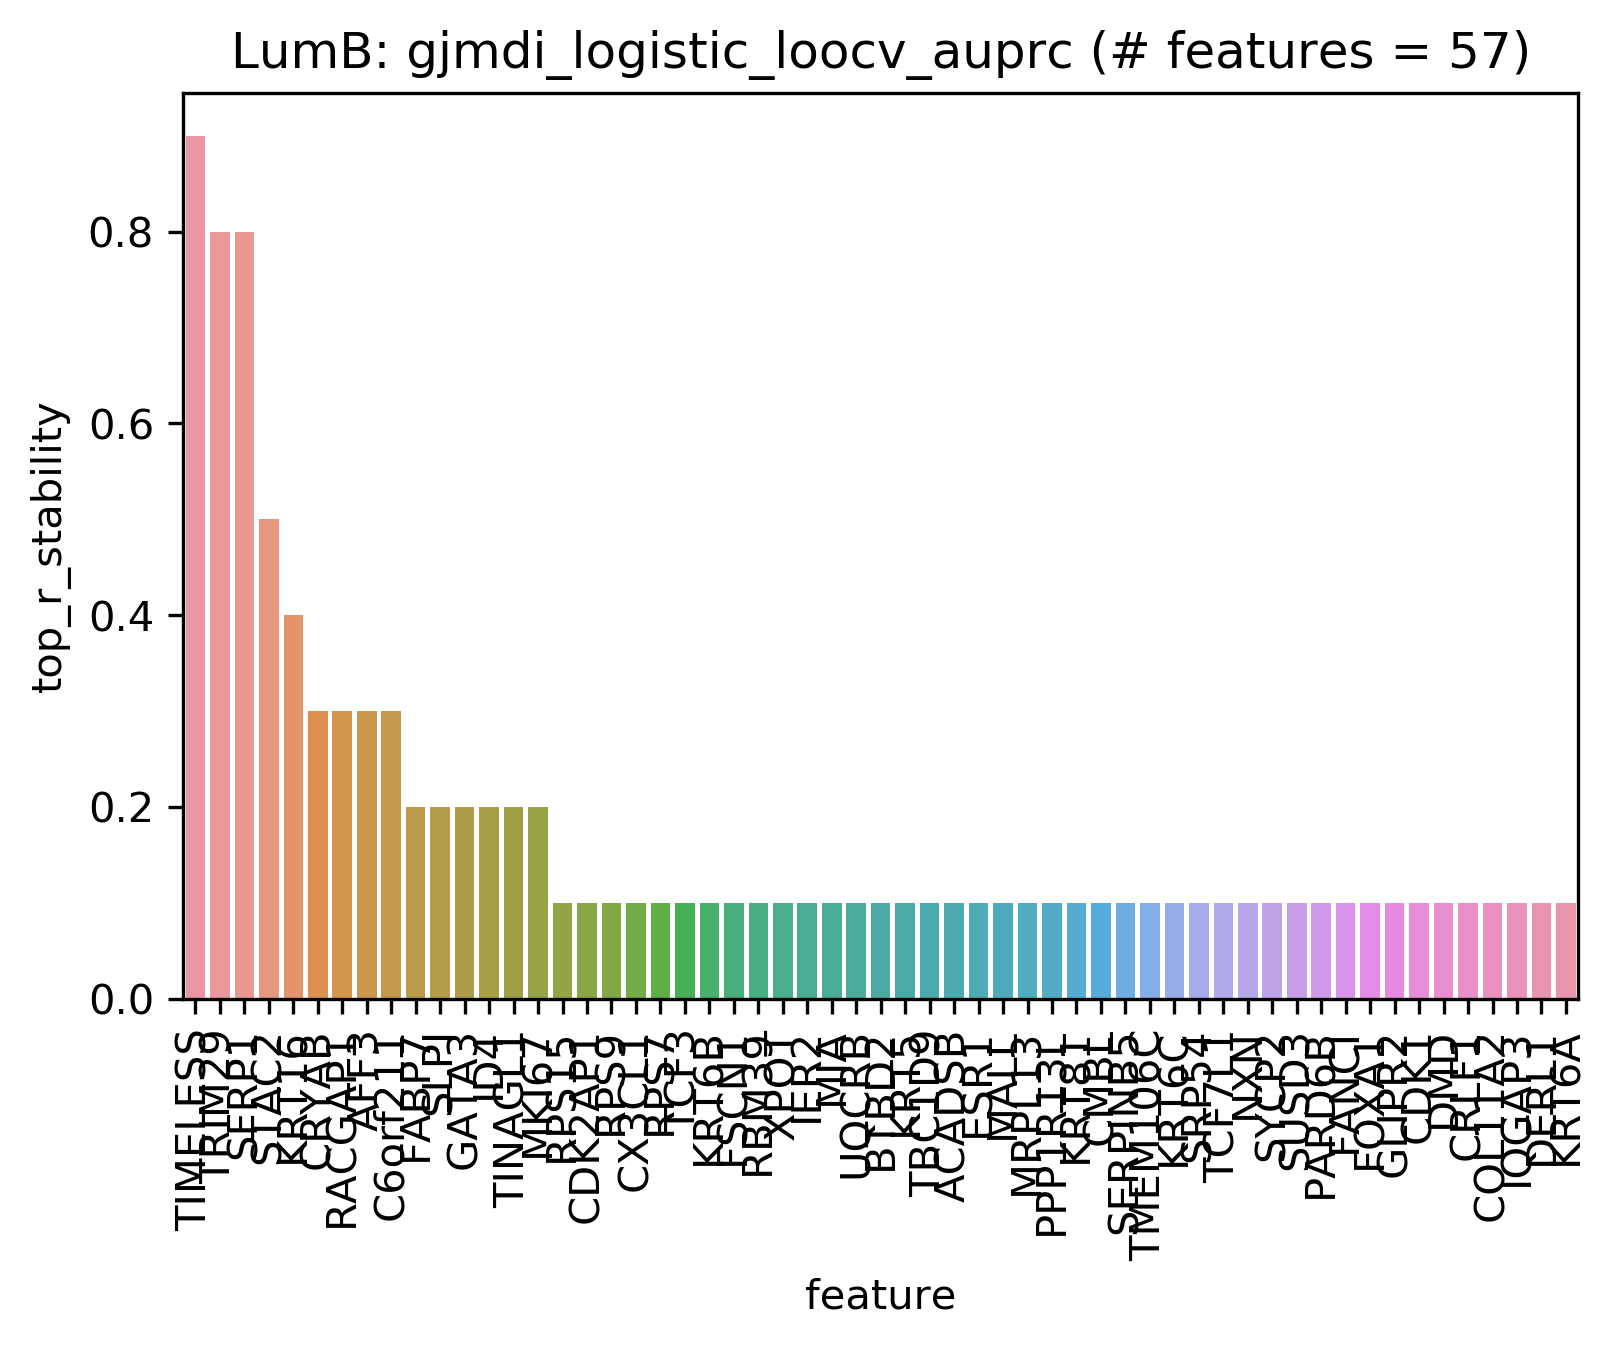

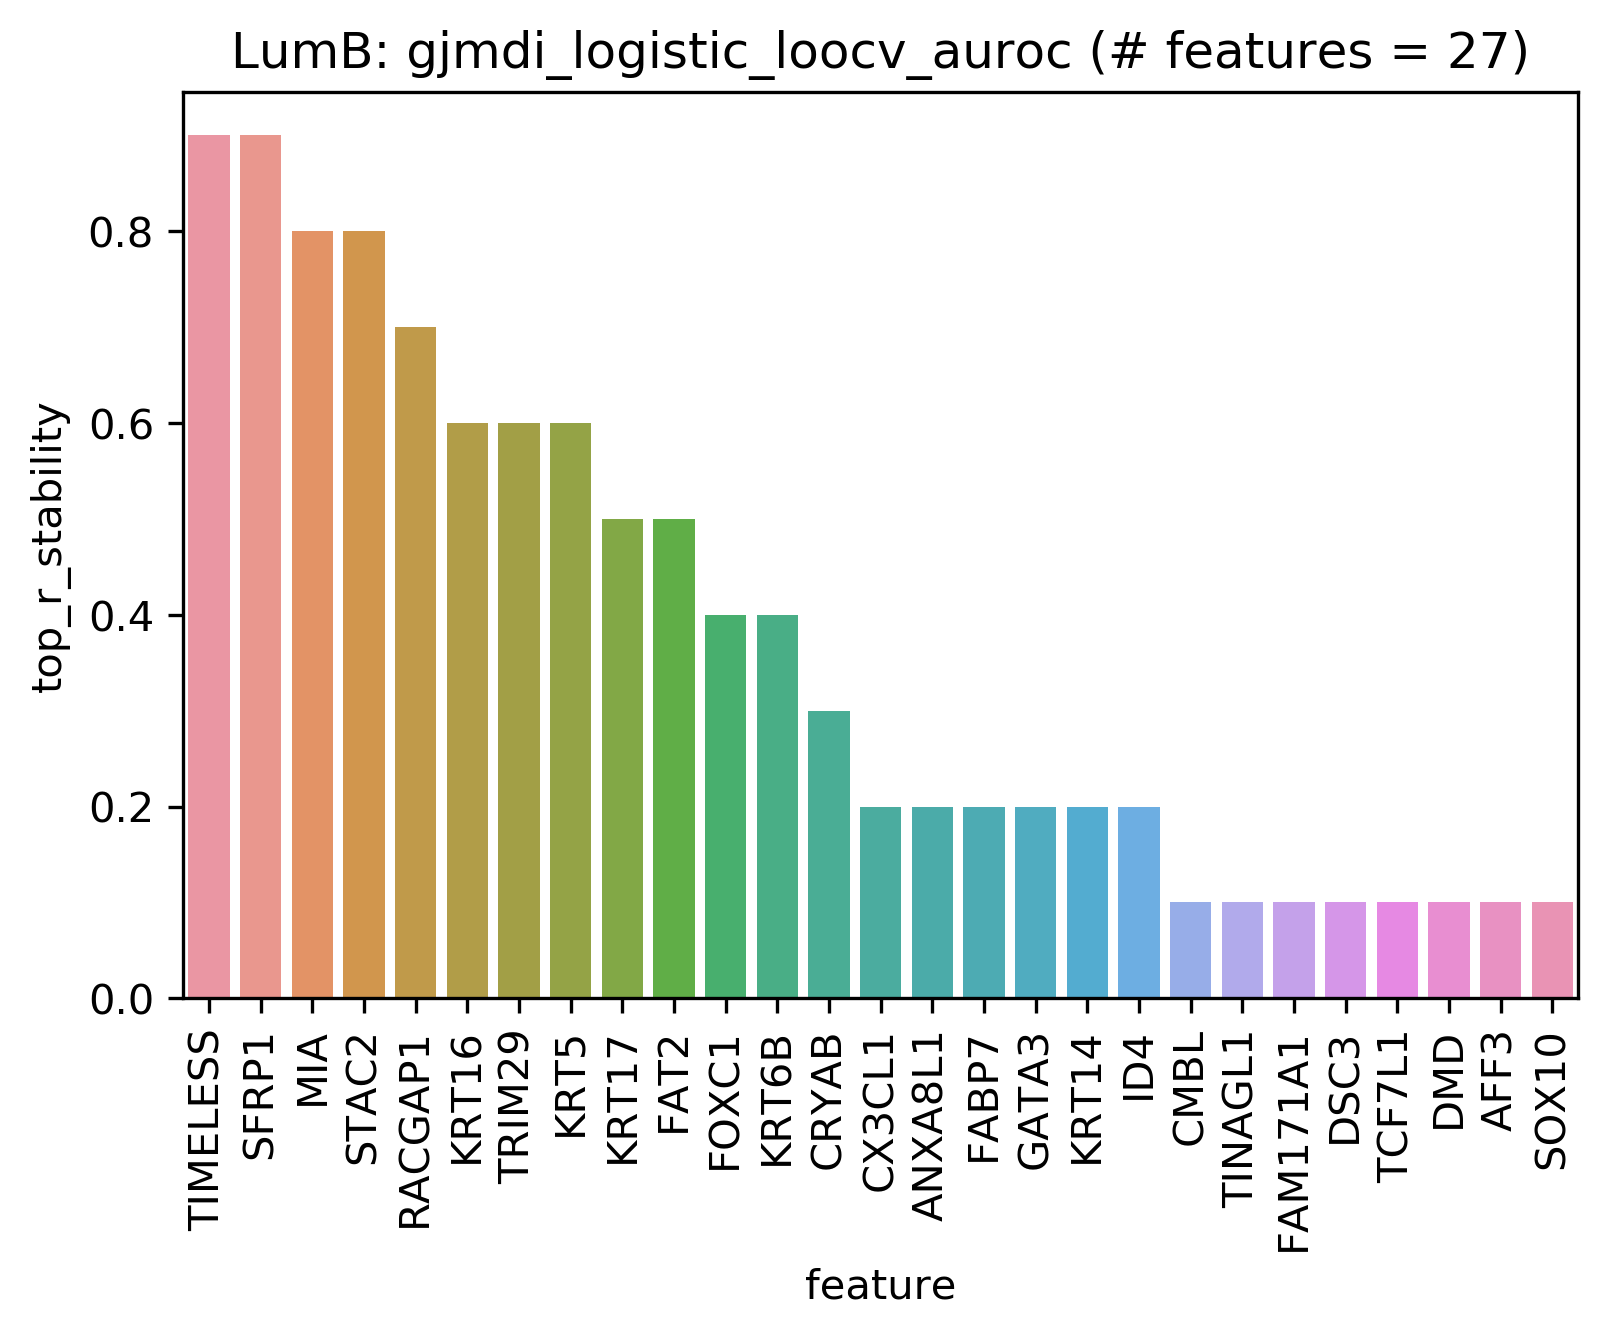

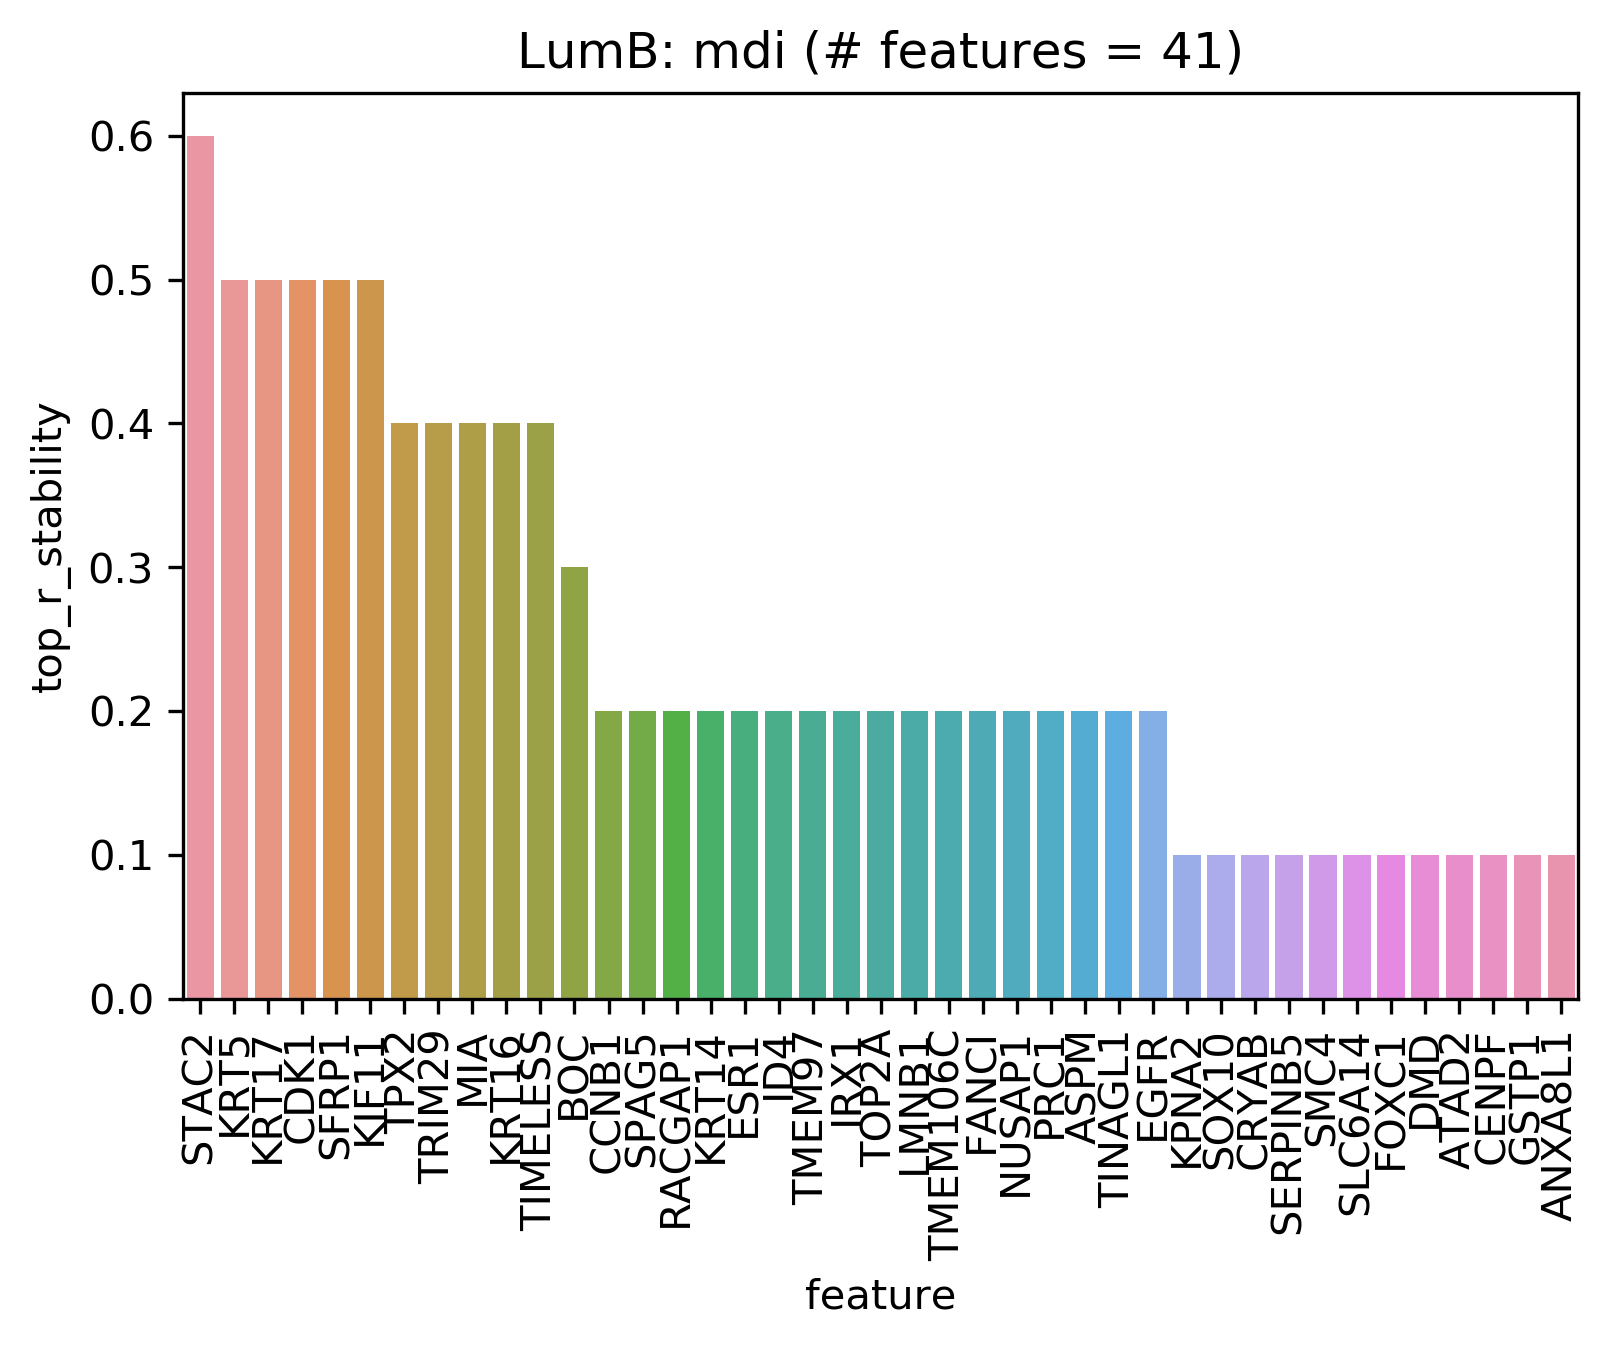

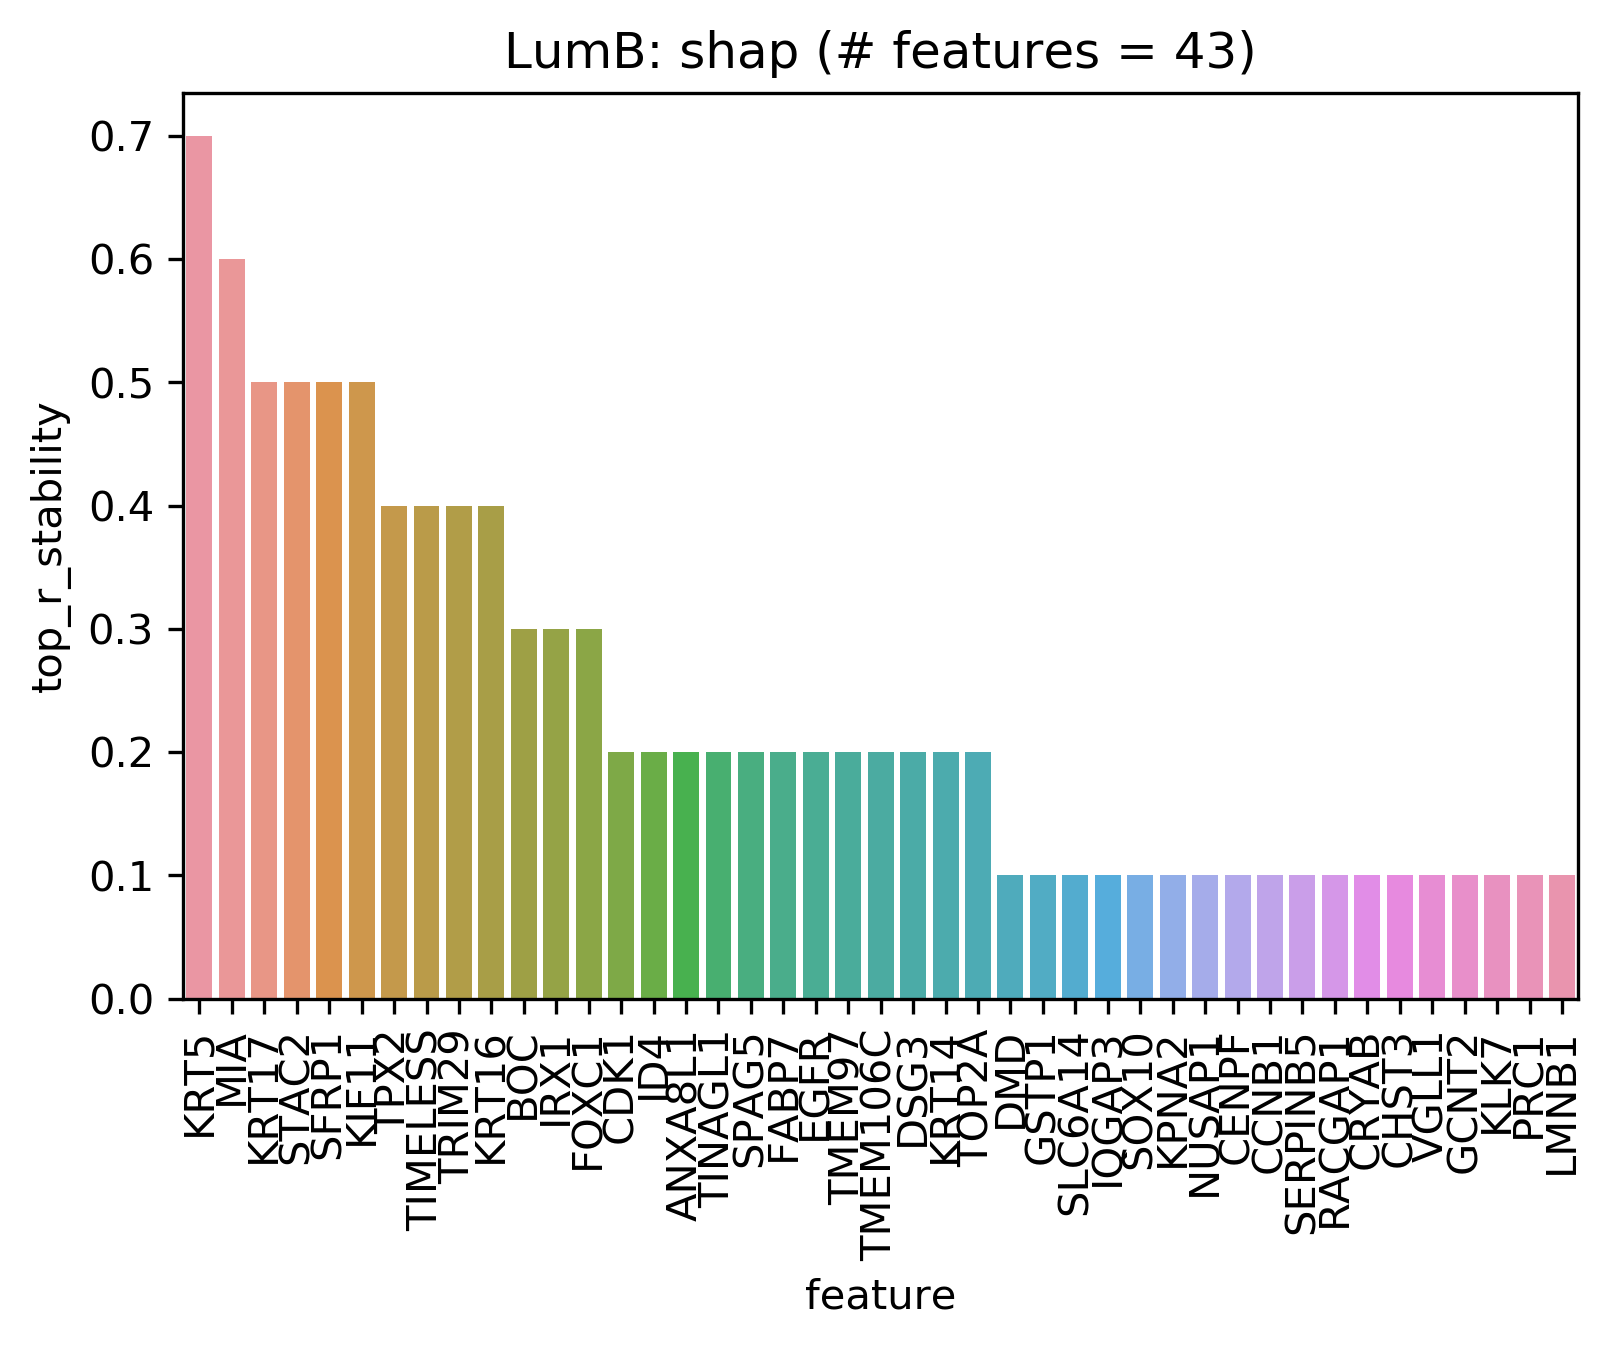

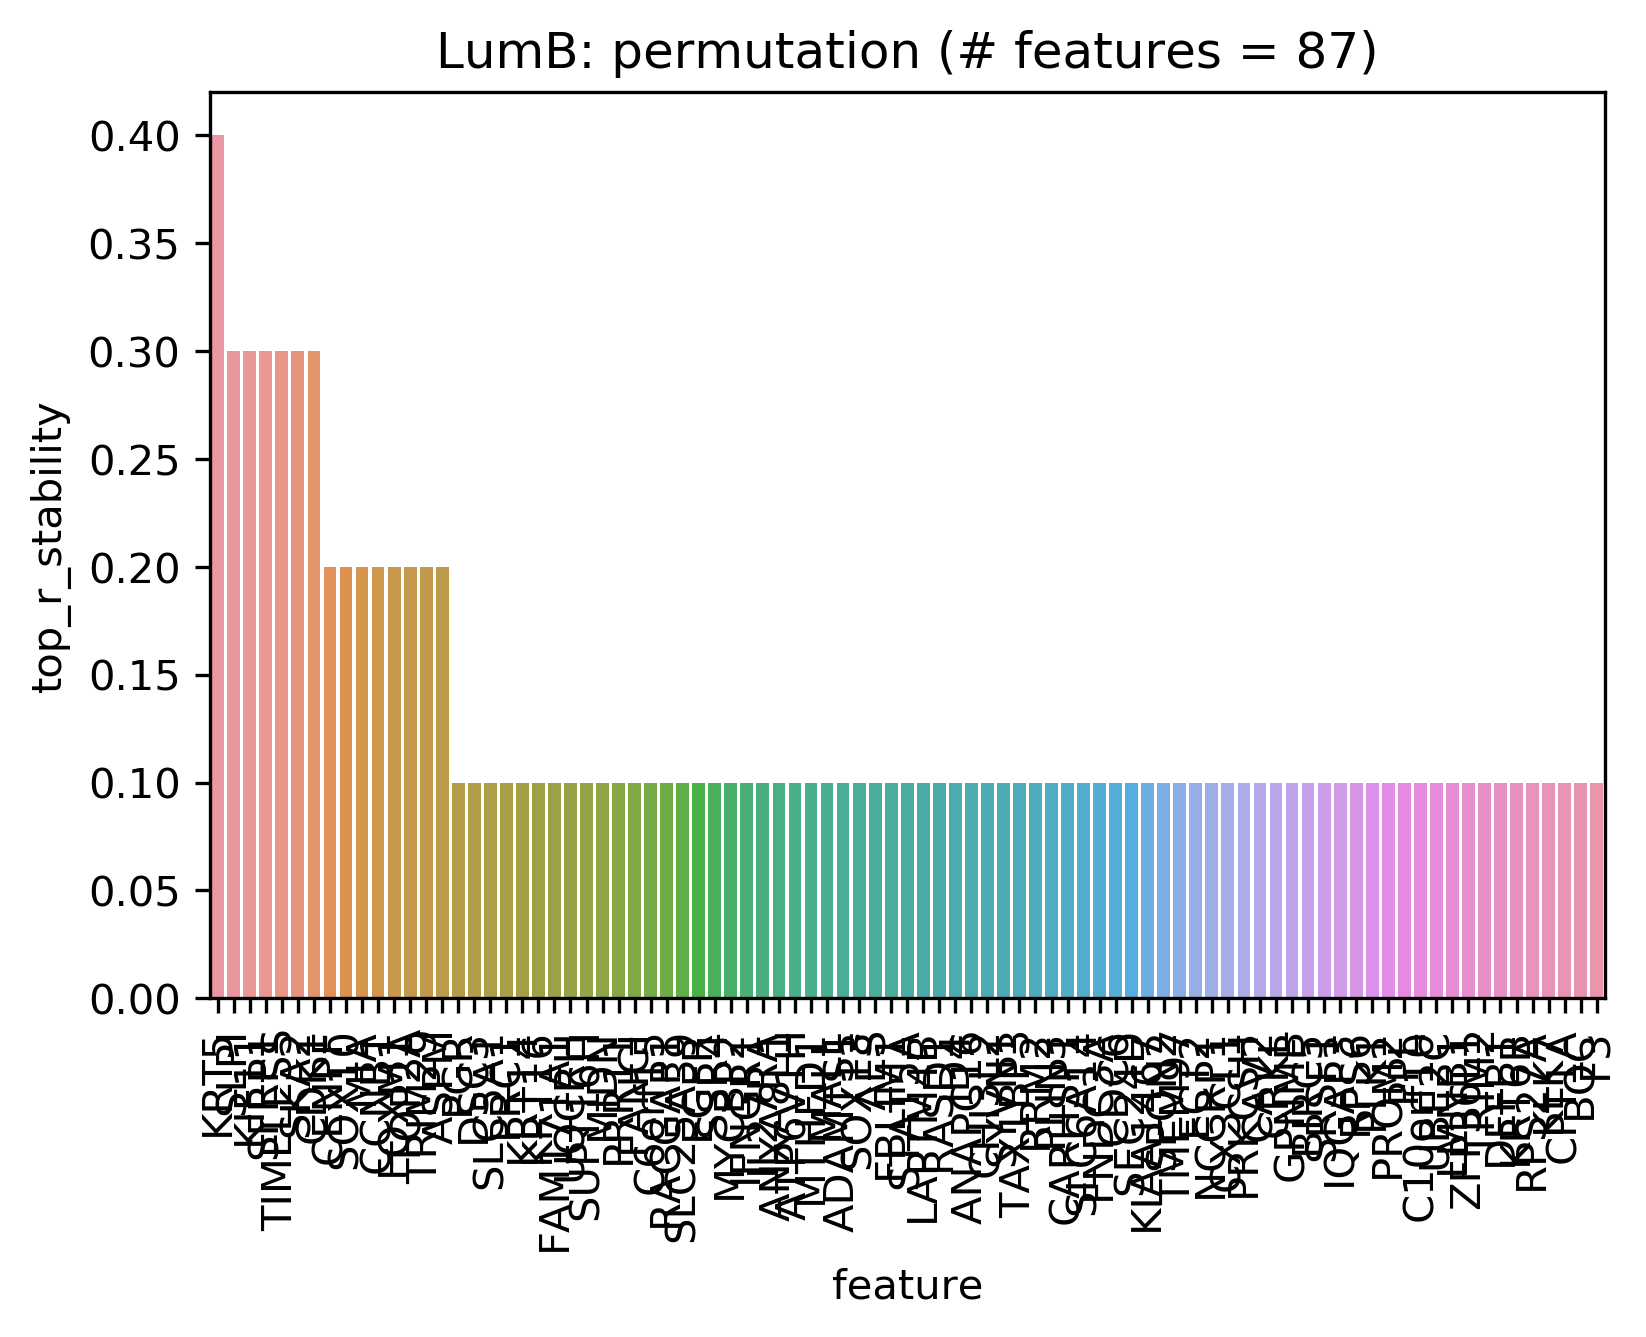

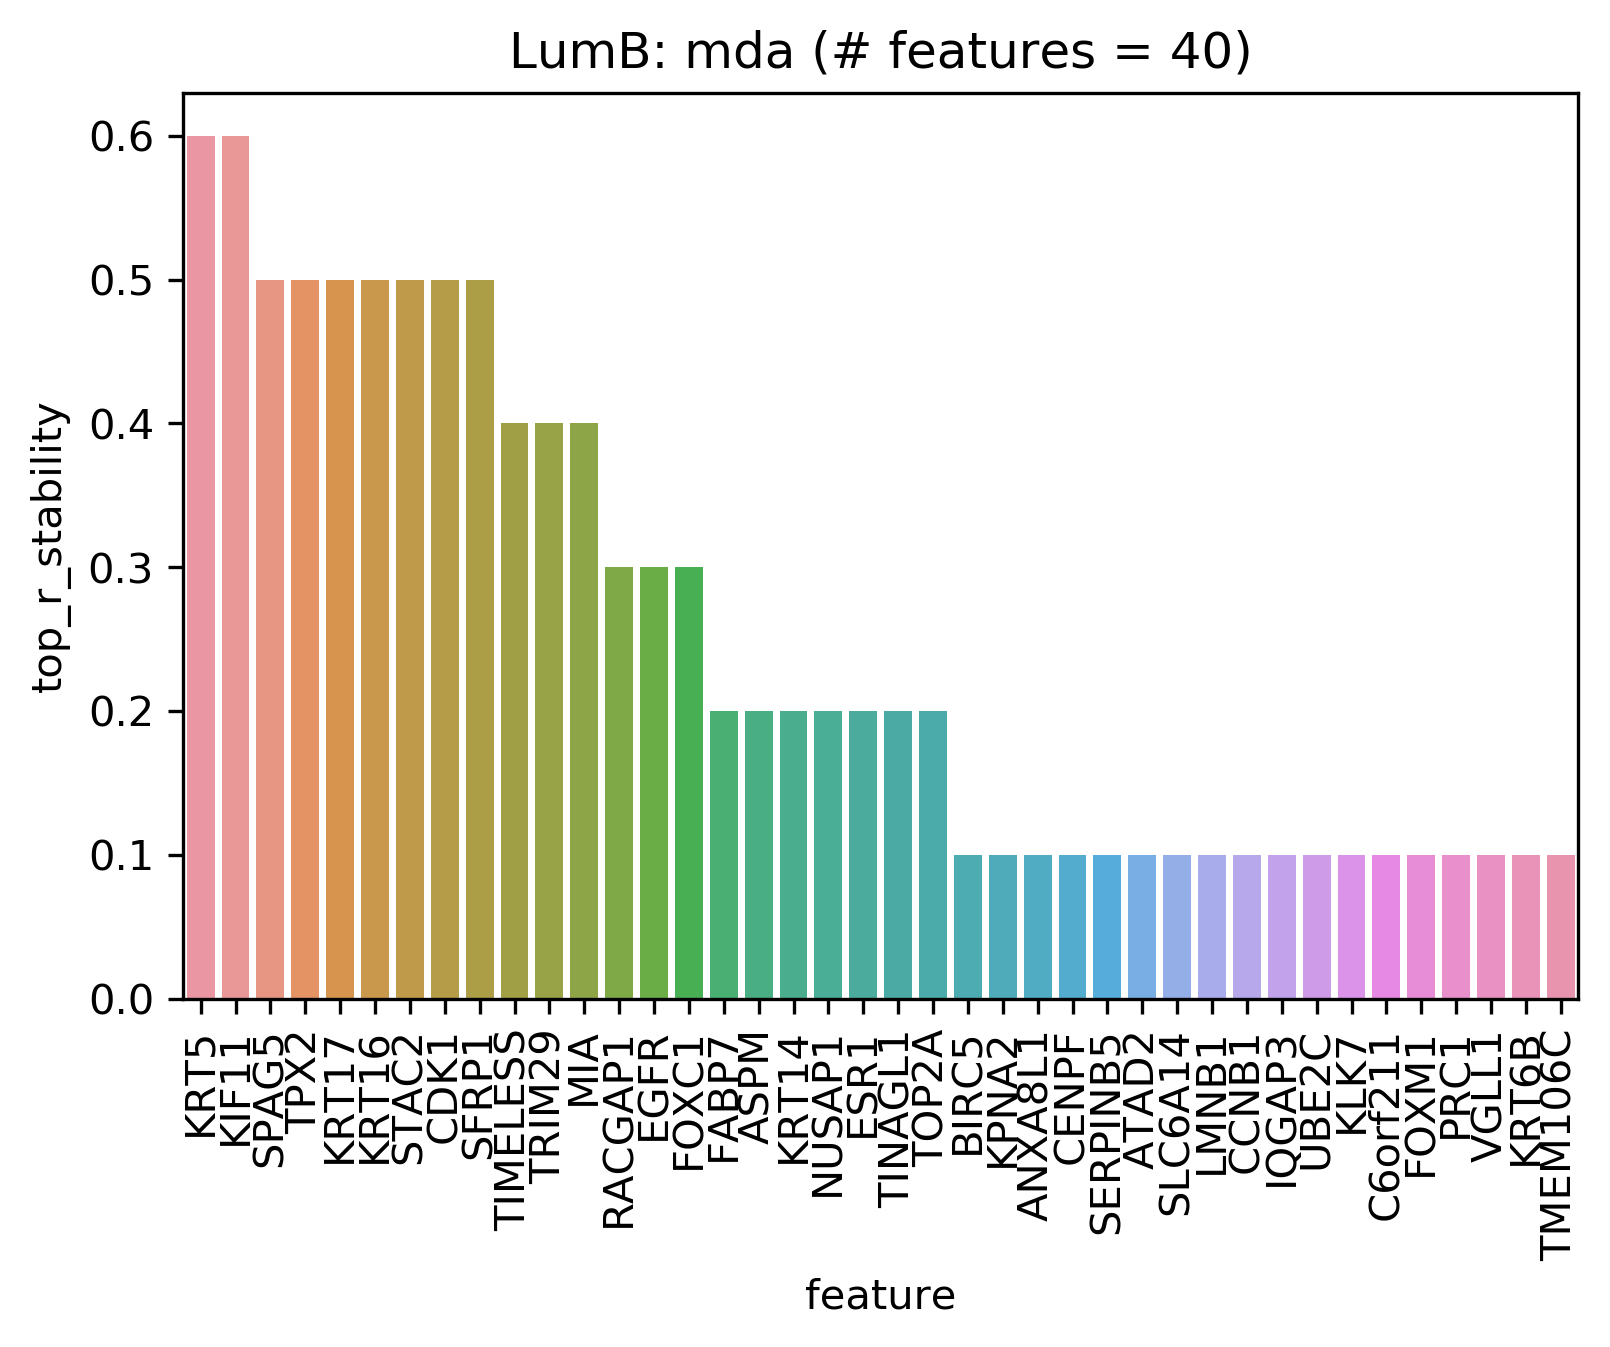

In [40]:
for subtype in stability_dict.keys():
    for method_name, df in stability_dict[subtype].items():
        df = df[df["top_r_stability"] > 0]
        ax = sns.barplot(
            x="feature", y="top_r_stability", data=df,
            order=df.sort_values("top_r_stability", ascending=False)["feature"]
        )
        ax.set_title("{}: {} (# features = {})".format(subtype, method_name, df.shape[0]))
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        plt.show()

In [42]:
n_features_dict = {"subtype": [], "method": [], "n_features": [], "stability_1": []}
for subtype in stability_dict.keys():
    for method_name, df in stability_dict[subtype].items():
        df = df[df["top_r_stability"] > 0]
        n_features_dict["subtype"].append(subtype)
        n_features_dict["method"].append(method_name)
        n_features_dict["n_features"].append(df.shape[0])
        # n_features_dict["stability_sum"].append(df["top_r_stability"].sum())
        n_features_dict["stability_1"].append((df["top_r_stability"] == 1).sum())
n_features_table = pd.DataFrame(n_features_dict)

for subtype in stability_dict.keys():
    df = n_features_table[n_features_table["subtype"] == subtype].sort_values("n_features")
    print(df)

   subtype                        method  n_features  stability_1
5    Basal    gjmdi_logistic_loocv_auprc          27            1
10   Basal                           mda          28            3
6    Basal    gjmdi_logistic_loocv_auroc          30            0
0    Basal             gjmdi_ridge_loocv          33            2
3    Basal     gjmdi_elastic_loocv_auroc          33            1
8    Basal                          shap          34            0
2    Basal     gjmdi_elastic_loocv_auprc          40            2
7    Basal                           mdi          40            0
4    Basal  gjmdi_logistic_loocv_logloss          51            0
1    Basal   gjmdi_elastic_loocv_logloss          75            0
9    Basal                   permutation        5000            3
   subtype                        method  n_features  stability_1
14    Her2     gjmdi_elastic_loocv_auroc          20            1
11    Her2             gjmdi_ridge_loocv          25            2
17    Her2